# Sparse coding for natural images
See [Olshausen, 1996](https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf) for reference.  The goal is to recover the receptive fields of simple cell neurons in the visual cortex using this training algorithm.  Simple cell neurons respond well to oriented edges, as found by [Hubel and Wiesel](https://www.youtube.com/watch?v=IOHayh06LJ4)  with the help of some cats.

Our algorithm has a set of artificial neurons, which each have a receptive field (basis function) $\phi_i$.  For a given image presentation, we imagine the neurons fire in response to the image according to a vector of weights $a_i$.  With the appropriate weights, we achieve perfect image reconstruction for an image $I$:
$I(x,y) = \sum_i a_i \phi_i(x,y)$,
that is the image can be represented as a linear combination of the basis functions with the weights as coefficients.  For each training image, the error in this reconstruction is minimized with the constraint that the image be 'sparsely' coded by the neurons.  This means relatively few large weights (a small number of neurons firing rapidly in response to the image) are preferred over evenly distributed weights (all neurons firing in response to an image).

In the algorithm, the basis functions are held fixed while this minimization is performed for a set of training images.  Then the basis functions are updated according to reconstruction errors from the past set of training images.



## Initialize basis functions

In [129]:
import numpy as np
pixels = 10   #training image patches will be of size (pixels, pixels)
size = 100    #there will be 100 basis functions of size (pixels, pixels)
bases = np.random.uniform(-0.1,0.1,(pixels*pixels,size))   #intiate random basis functions

## Get ready for Cython magic

In [38]:
%load_ext cython   

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


## Everything needed for basis function training

In [130]:
%%cython
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import ndimage
import numpy as np
from math import log

cdef int pixels = 10     #training image patches are of size (pixels, pixels)
cdef int size = 100      #there are 100 basis functions of size (pixels, pixels)
cdef int buffer = 5      #training image patches are at least 5 pixels from the edge of the training image
cdef int num_trials = 5 #the number of training trials in each 'batch'; basis functions are updated after each batch
cdef double eta = 5.0    #basis function learning rate



def get_random_image(images):
    """Randomly returns one of the 10 natural training images
    images: array of training images
    """
    cdef int image_number = np.random.randint(0, 10)
    return images[:,:,image_number]

def get_random_patch(image):
    """Randomly returns (pixels, pixels) patch from a training image;
    the patch is at least (buffer) pixels away from the image edge
    image: natural training image
    """
    cdef int x = np.random.randint(buffer, 512 - pixels - buffer)
    cdef int y = np.random.randint(buffer, 512 - pixels - buffer)
    patch = np.reshape(image[x:x+pixels,y:y+pixels], pixels*pixels)
    return patch
    

cdef double S(x):
    """Sparseness cost function, promotes sparseness in the weights 
    basis functions
    """
    return(log(1 + x*x))

cdef double Sprime(double x):
    """Derivative of sparseness cost function, used for gradient descent
    """
    return(2*x/(1 + x*x))

def get_sparseness(weights, double sigma):
    """Returns measure of sparseness for the weights
    weights: coefficients of basis functions for a given training patch
    """
    cdef int i
    sparseness = 0
    for i in range(len(weights)):
        sparseness += S(weights[i]/sigma)
    return(-sparseness)

def get_preservation(image, weights, bases):
    """Returns measure of image preservation for the weights
    image: training patch
    weights: coefficients of basis functions for a given training patch
    """
    cdef int x, i
    cdef double info
    info = 0
    for x in range(image.shape[0]):
        model = 0
        for i in range(bases.shape[1]):
            model += weights[i]*bases[x][i]  #reconstructed image is a linear combination of the basis functions, with the weights as coefficients
        info += (image[x] - model)**2
    return(-info)
    
def get_energy(weights, *args):
    """Overall cost function for training; this is what (hopefully) gets minimize
    during the gradient descent process
    weights: coefficients of basis functions for a given training patch
    """
    patch, bases, sigma, lam = args
    sparseness = get_sparseness(weights,sigma)
    preservation = get_preservation(patch,weights,bases)
    return(-preservation-lam*sparseness)

def get_gradient(weights, *args):
    """Returns the gradient of the above get_energy() (Cost) function in order
    to minimize the cost function
    weights: coefficients of basis functions for a given training patch
    """
    cdef double sigma, lam
    cdef double grad_i
    image, bases, sigma, lam = args
    grad = []
    cdef int i, j
    for i in range(len(weights)):
        grad_i = 0.0
        grad_i -= np.dot(bases[:,i], image)
        for j in range(len(weights)):
            grad_i += weights[j]*np.dot(bases[:,i], bases[:,j])
        grad_i += lam*Sprime(weights[i]/sigma)/sigma      
        grad.append(grad_i)
        
    return(np.array(grad))

def gradient_descent(image, bases, double sigma, double lam):
    """Minimize the cost function by moving the weights vector
    down the slope of the energy/cost function; returns weights vector
    after energy/cost difference is small (or after 20 iterations)
    image: training image patch
    bases: basis functions for image reconstruction
    sigma: variance of image
    lam: (lambda) sparseness parameter
    """
    cdef int i,j
    cdef double gamma = 1e-2  #rate of descent
    weights = np.zeros(size)
        
    #Pick starting point for vector of weights
    for i in range(size):
        weights[i] = np.dot(bases[:,i], image)

    last_energy = get_energy(weights,image, bases, sigma, lam)
    #print("-------------------")
    #print(last_energy)
    
    #Move weights vector down the slope of energy/cost function
    for j in range(20):
        weights += -gamma * get_gradient(weights, image, bases, sigma, lam)
        energy = get_energy(weights,image, bases, sigma, lam)
        if np.abs((energy - last_energy)/energy) < 0.02:
            break
        gamma += 5e-3
        last_energy = energy
        
    #print(last_energy)
    #print("-----------------")

    return(weights)

def plot_bases(bases, num_images):
    """Plots num_images**2 of the basis functions in a num_images by num_images grid
    bases: basis functions for image reconstruction5 by 5
    """
    fig, axes = plt.subplots(nrows=num_images, ncols=num_images, sharex=True, sharey=True, figsize = (20,10))
    axes = axes.ravel()
    for i in range(num_images**2):      
        axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[i].axis('off')
    plt.show()

def update_bases(bases,averages):
    """Updates the basis functions according to the 'average'
    update found during the last batch of training; the average is actually
    finished here by when dividing by the number of trials.  We intentionally
    keep the basis functions fixed over many image presentations before updating
    the basis functions; that's why this 'average' update array is here
    bases: basis functions for image reconstruction
    averages: sum of updates needed to implemented over the course of a training batch
    eta (defined globally): learning rate for basis functions
    """
    cdef int i, x
    for i in range(bases.shape[1]):
        for x in range(bases.shape[0]):
            bases[x][i] += eta*averages[x][i]/float(num_trials)
    return(bases)

def sparse_net(bases, num_batches):
    """Trains basis functions according to the SparseNet algorithm.  For each
    batch, an image is loaded.  Then over many trials, a random image patch is
    taken and the weights vector is found using gradient descent.  At the end of
    each batch, the (average) error in reconstruction is used in updating the basis functions.
    bases: basis functions for image reconstruction
    num_batches: number of training batches
    """
    cdef int batch, trial, k, x, n
    cdef variance, sigma, lam
    contents = sio.loadmat('IMAGES.mat')
    for batch in range(num_batches): 
        averages = np.zeros((pixels*pixels,size))
        image = get_random_image(contents['IMAGES'])
        variance = ndimage.variance(image)
        sigma = np.sqrt(variance)
        lam = 0.1*sigma  #suggested value of lambda/sigma from Olshausen paper
        for trial in range(num_trials):
            patch = get_random_patch(image)
            if ndimage.variance(patch) > 0.1*variance:
                weights = gradient_descent(patch, bases, sigma, lam)
                for k in range(averages.shape[1]):
                    for x in range(averages.shape[0]):
                        reconstruction = 0
                        for n in range(len(weights)):
                            reconstruction += weights[n]*bases[x][n]
                        averages[x][k] += weights[k]*(patch[x] - reconstruction)
        
        #Update basis functions
        bases = update_bases(bases, averages)
        
        #Normalize basis functions, to keep them from growing without bound
        bases = np.dot(bases, np.diag(1/np.sqrt(np.sum(bases**2, axis = 0))))
        print("Basis functions after batch number #" + str(batch))
        plot_bases(bases, 10)

    return bases
        
    

## Run sparse coding algorithm, displays basis functions after each batch

Basis functions after batch number #0


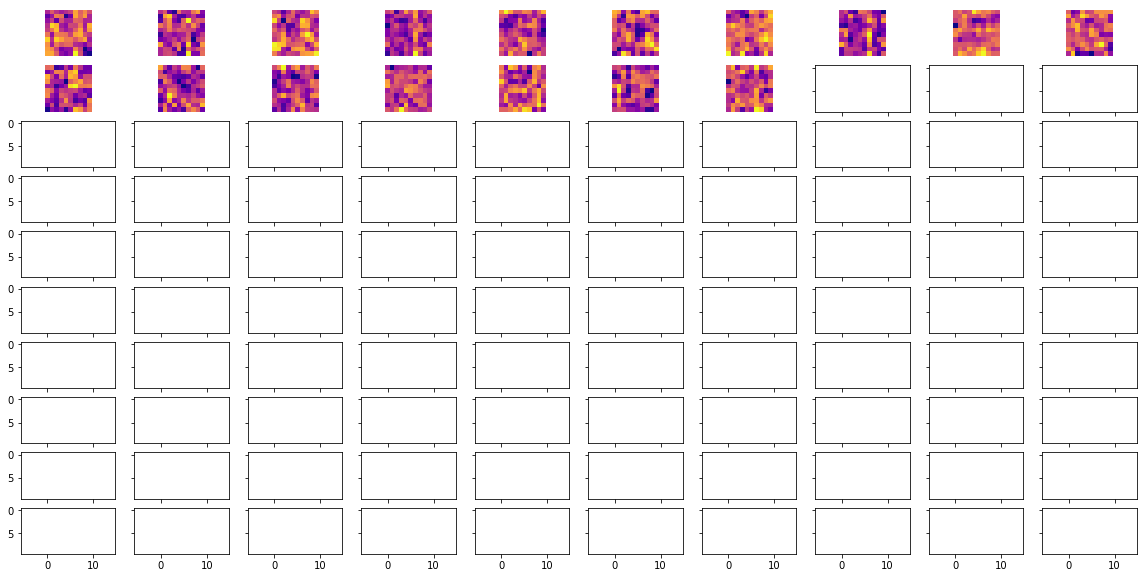

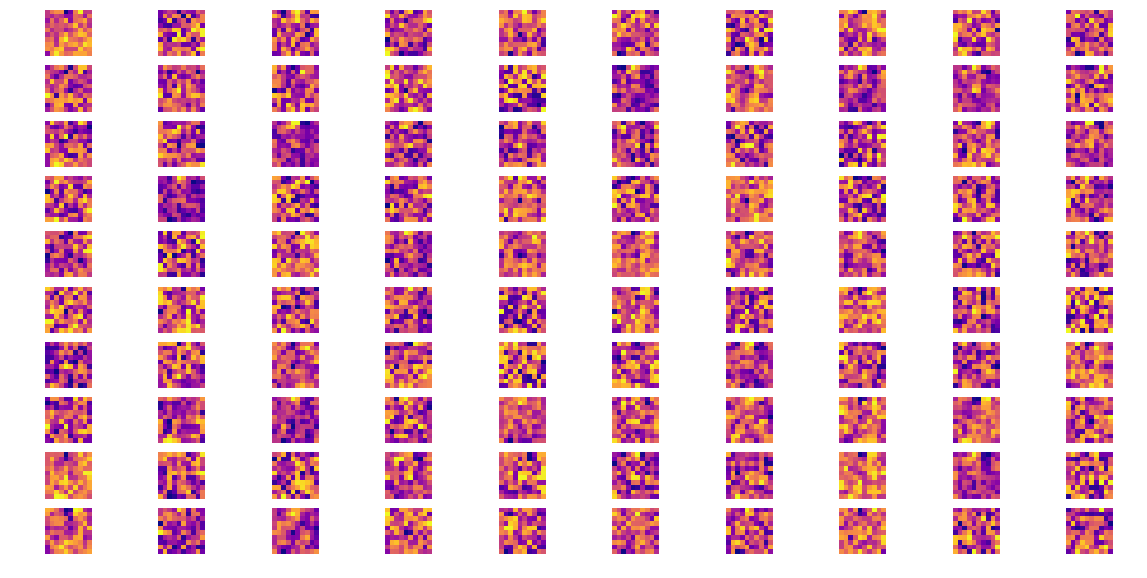

Basis functions after batch number #1


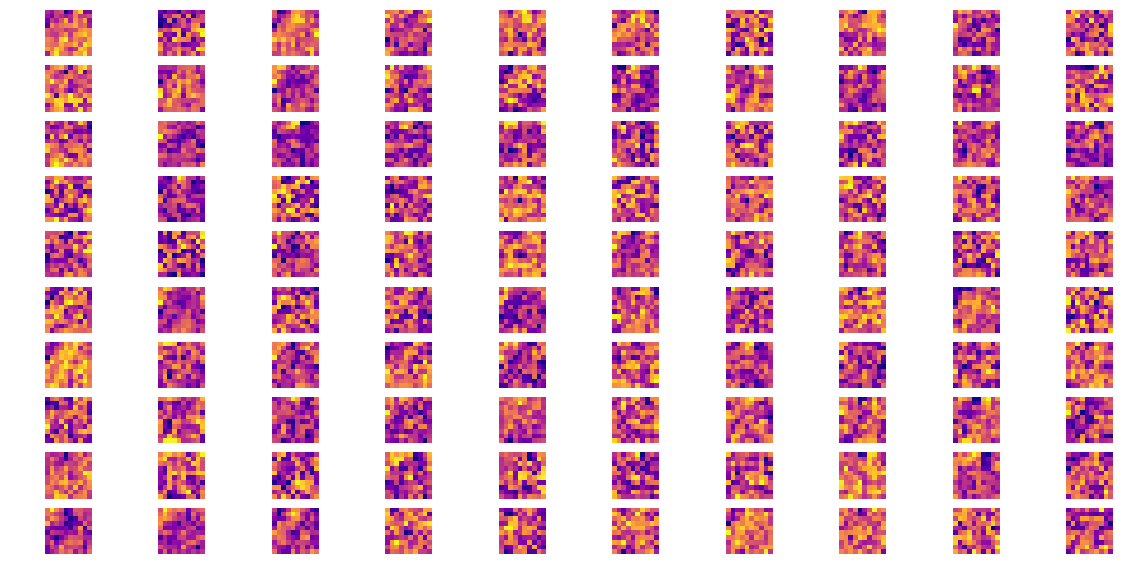

Basis functions after batch number #2


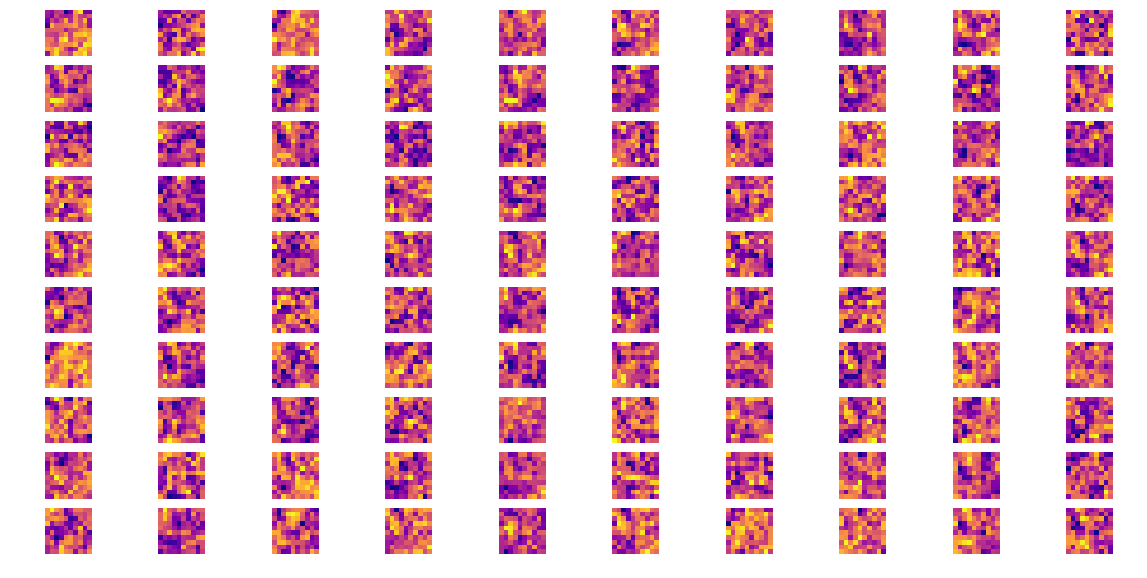

Basis functions after batch number #3


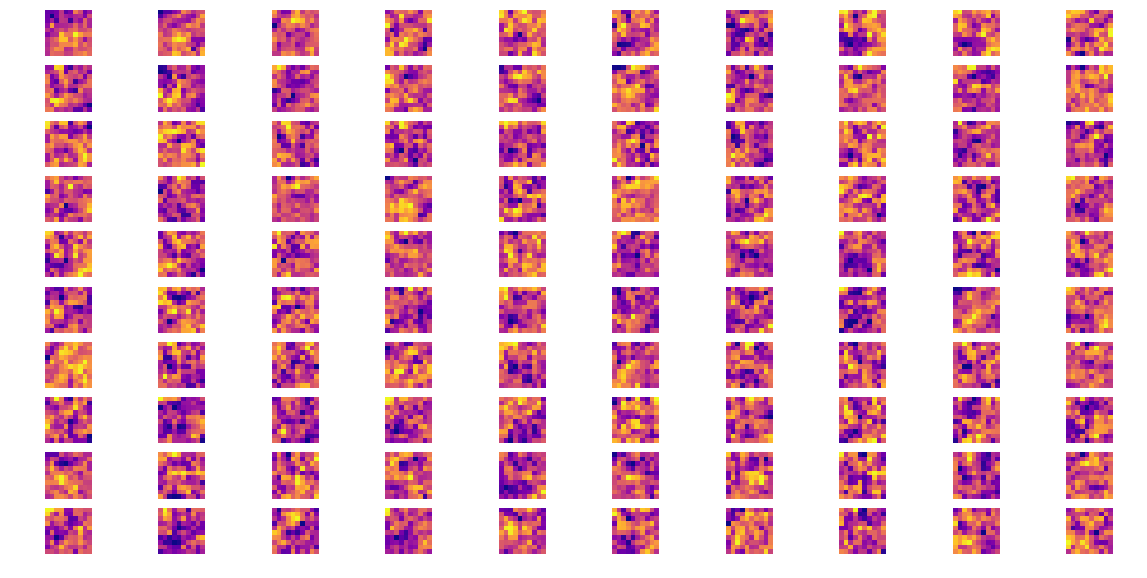

Basis functions after batch number #4


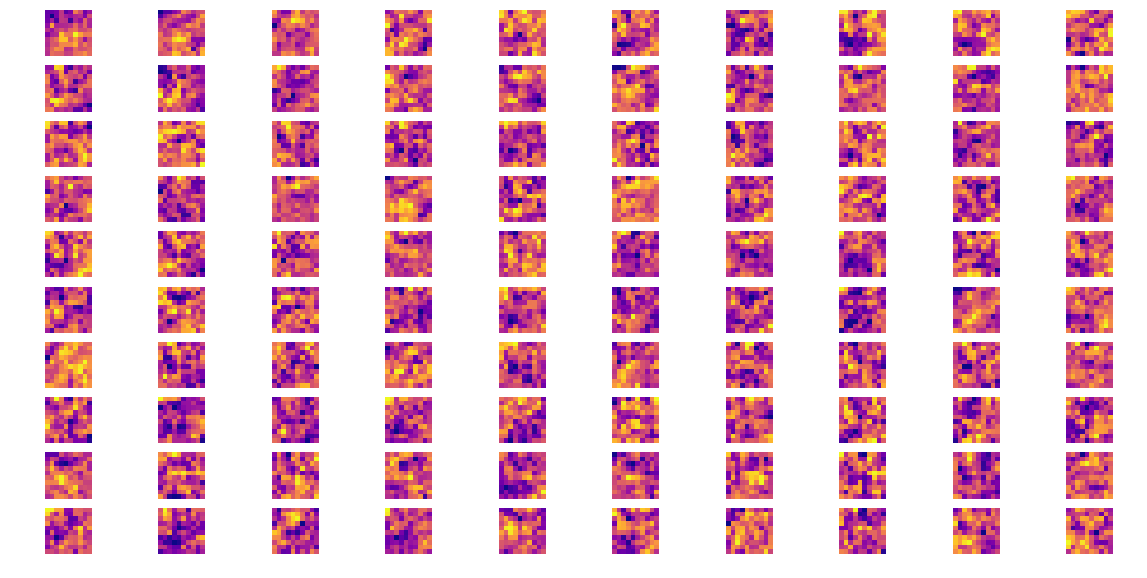

Basis functions after batch number #5


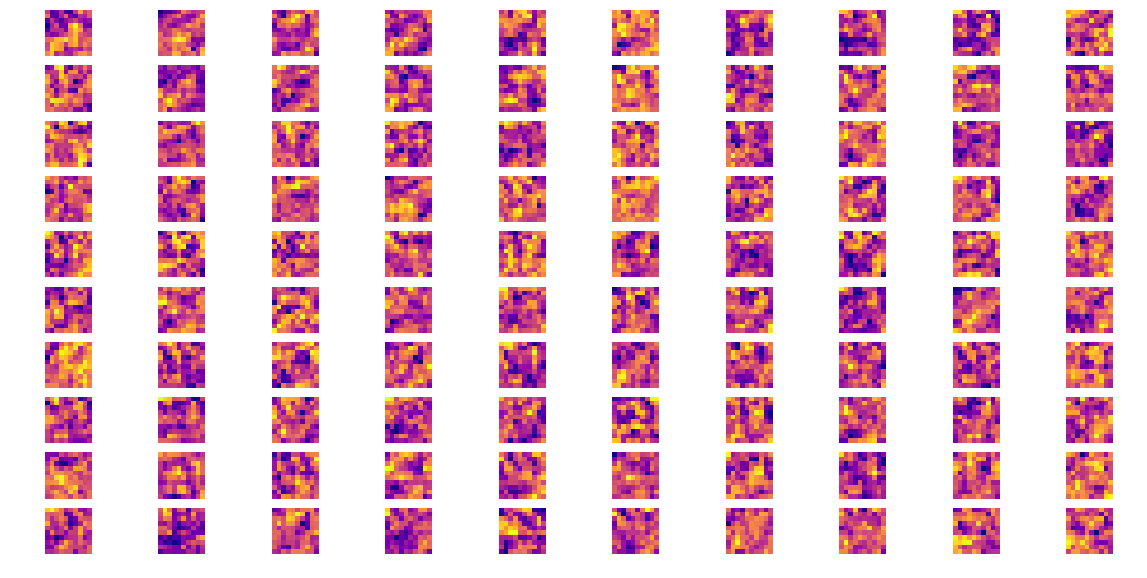

Basis functions after batch number #6


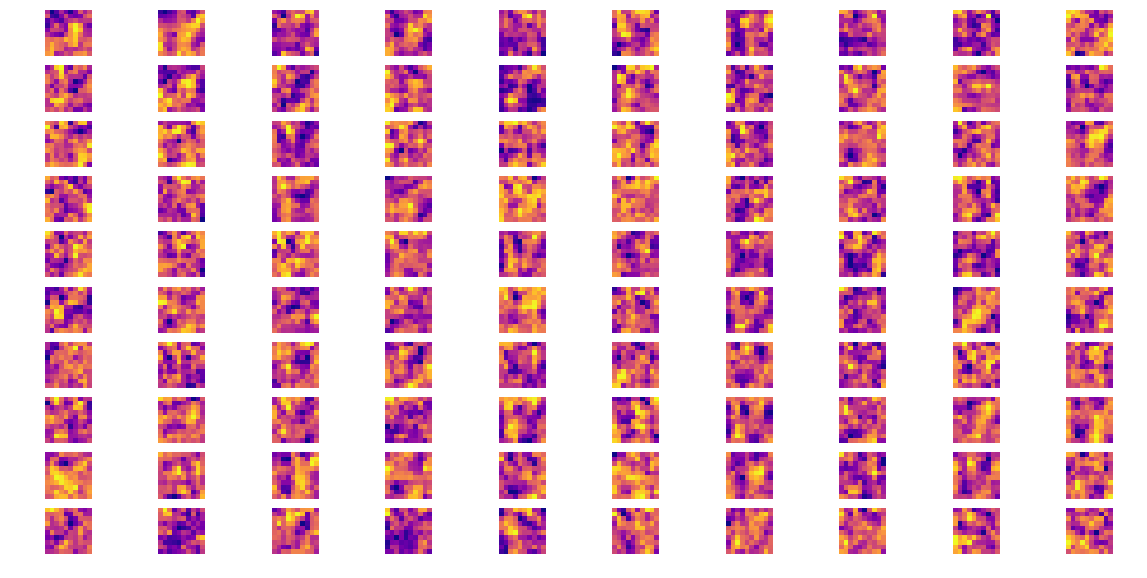

Basis functions after batch number #7


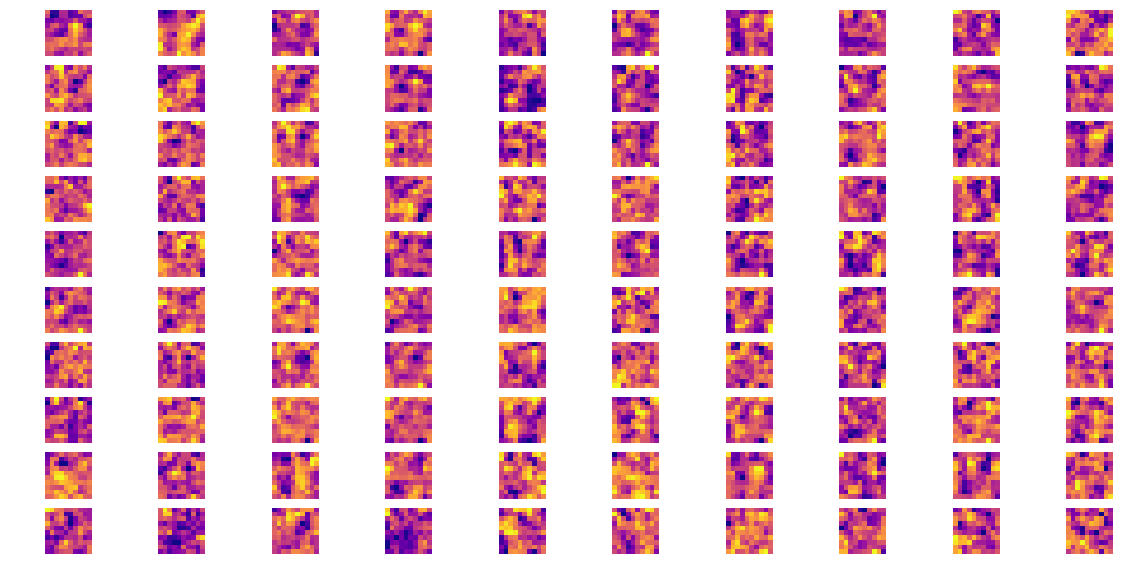

Basis functions after batch number #8


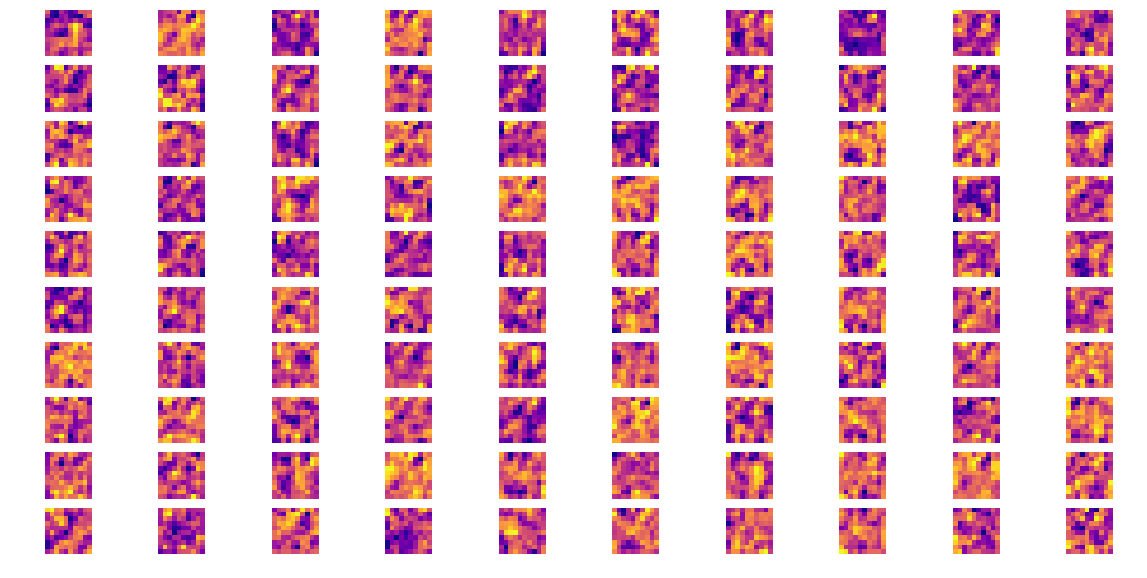

Basis functions after batch number #9


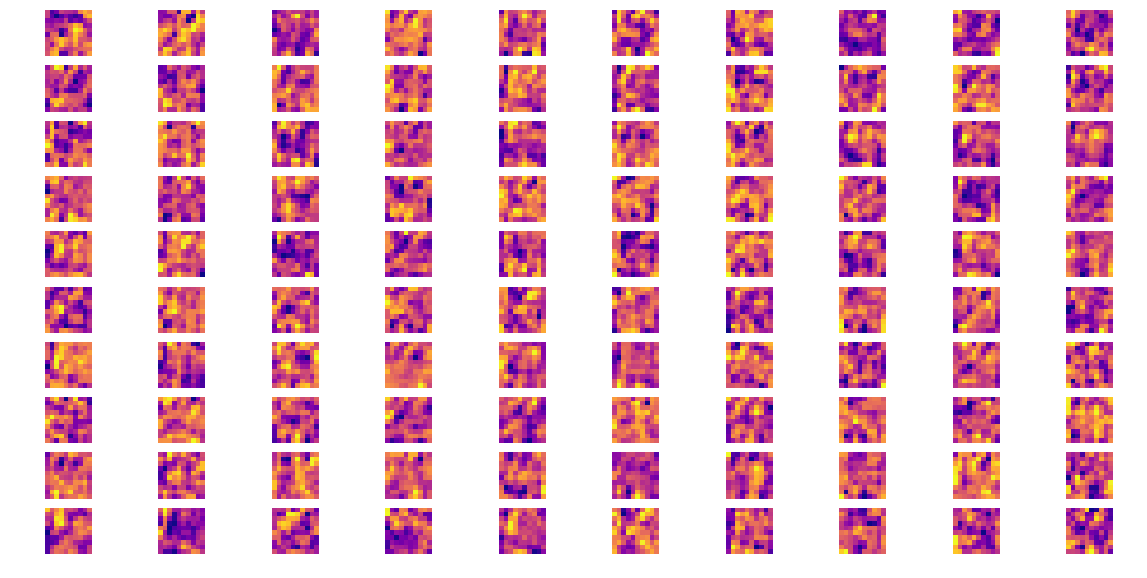

Basis functions after batch number #10


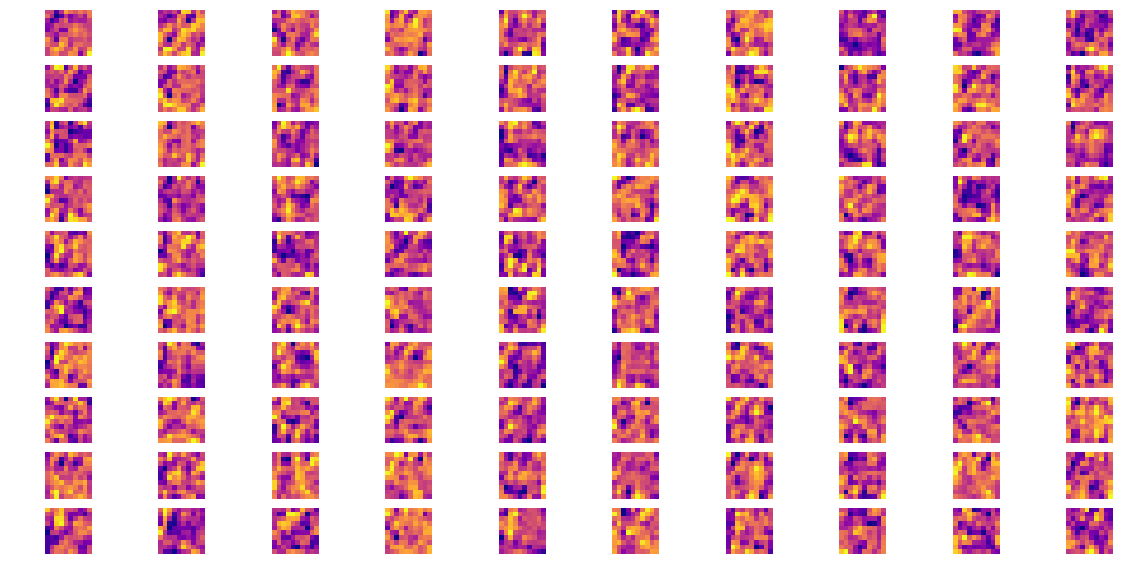

Basis functions after batch number #11


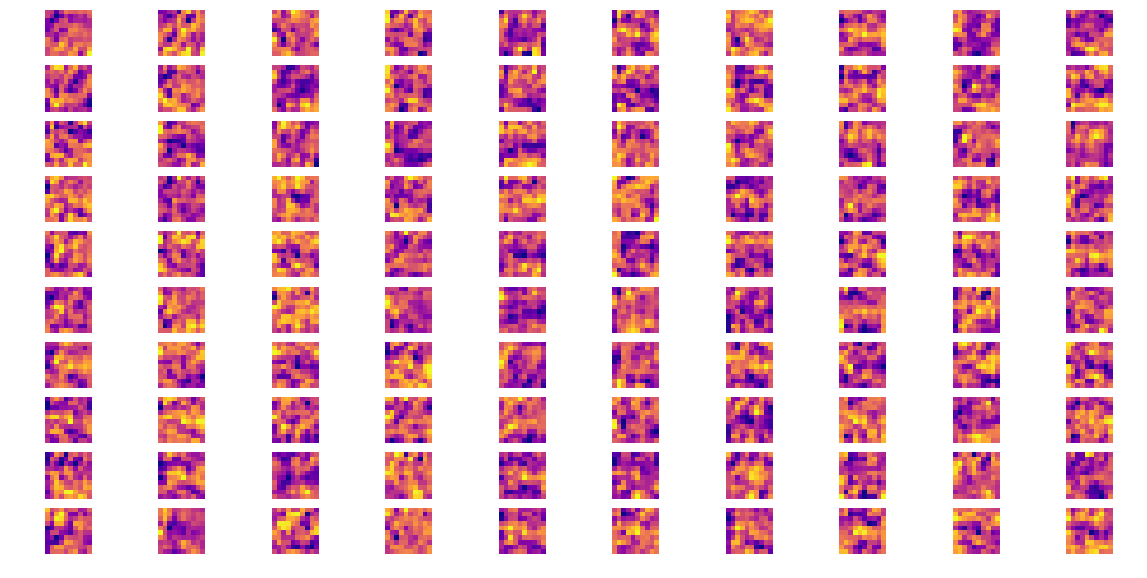

Basis functions after batch number #12


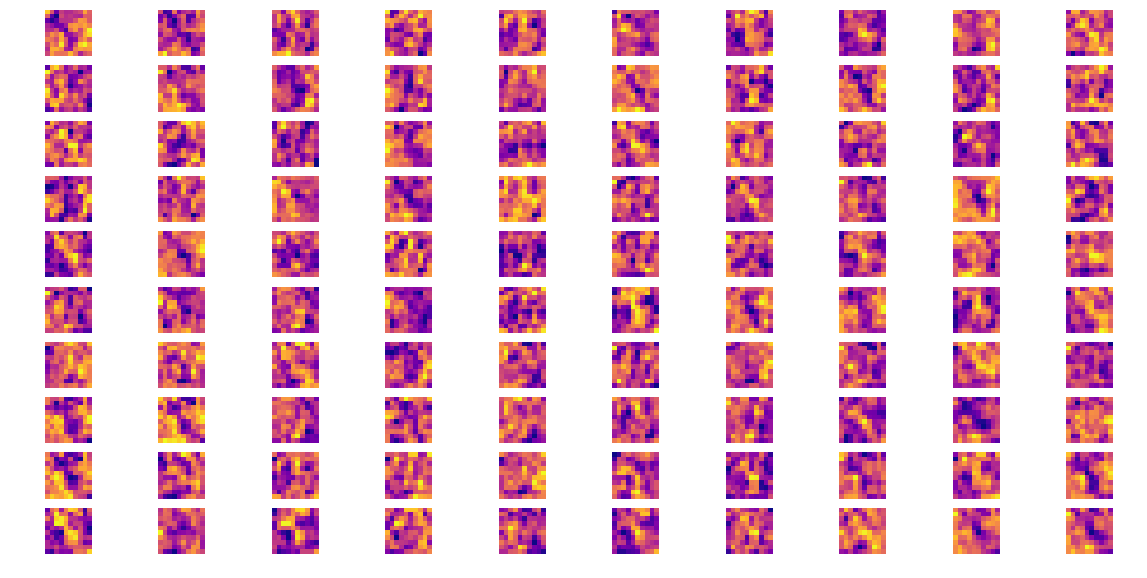

Basis functions after batch number #13


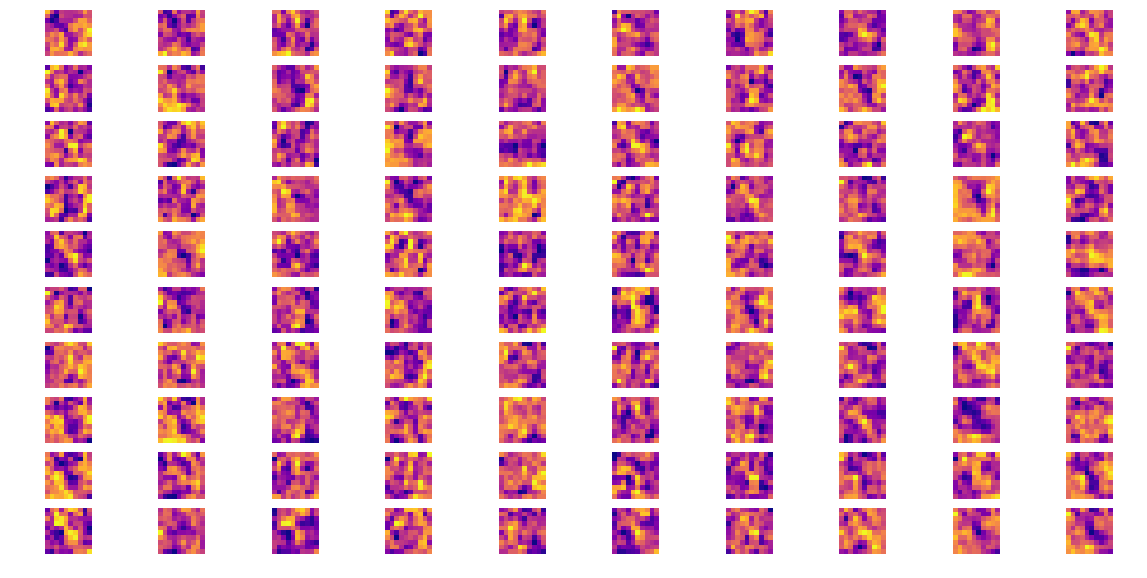

Basis functions after batch number #14


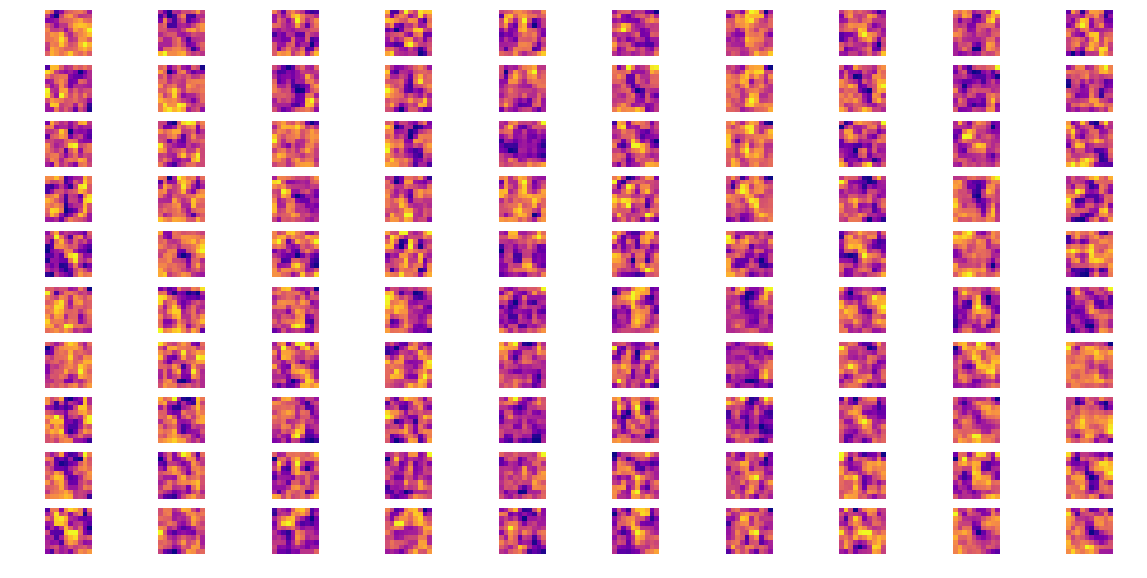

Basis functions after batch number #15


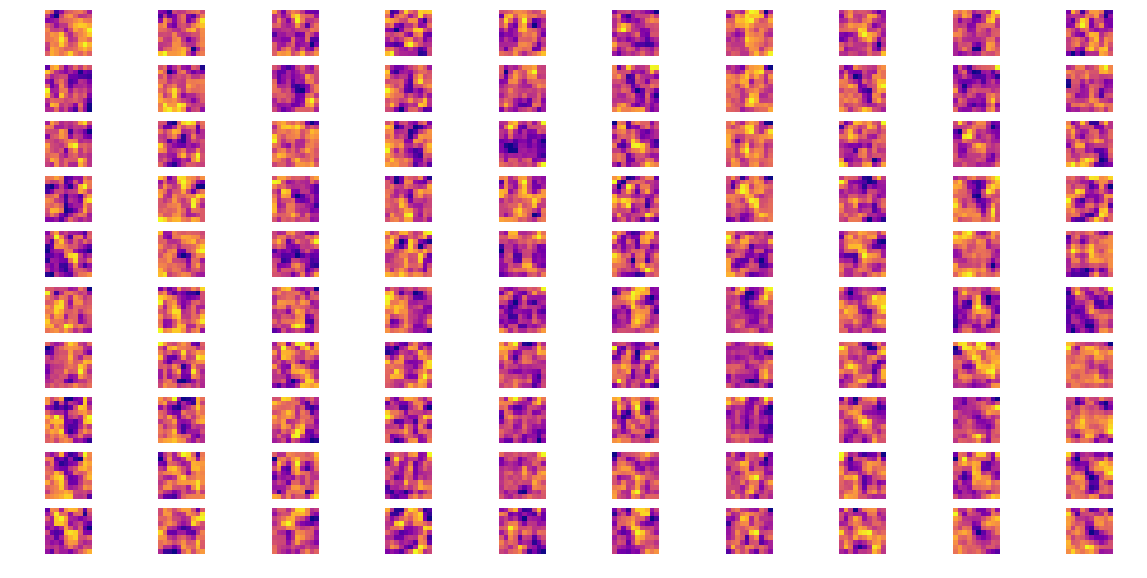

Basis functions after batch number #16


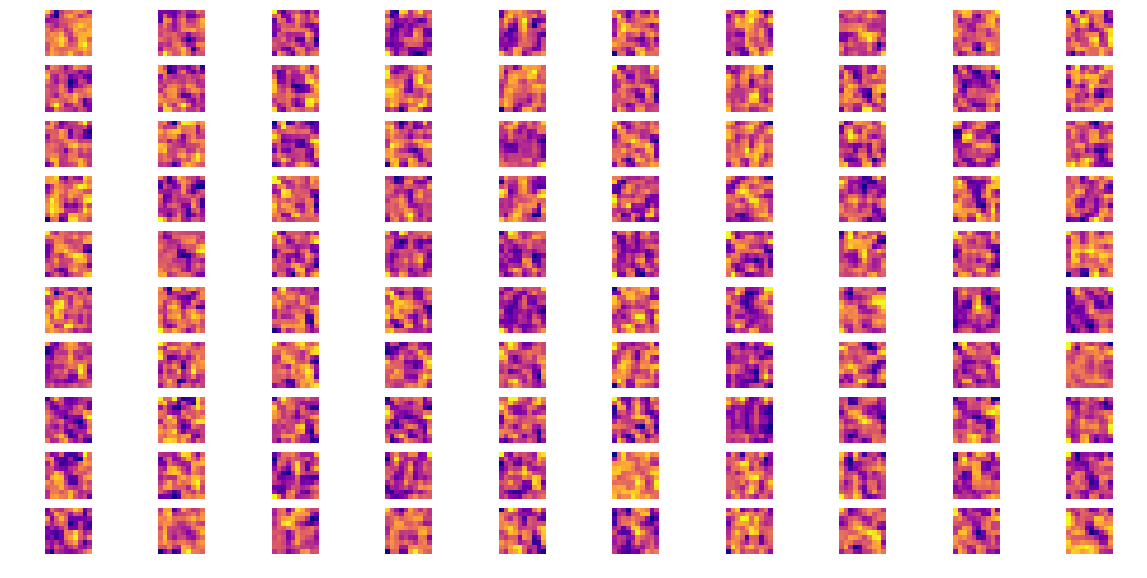

Basis functions after batch number #17


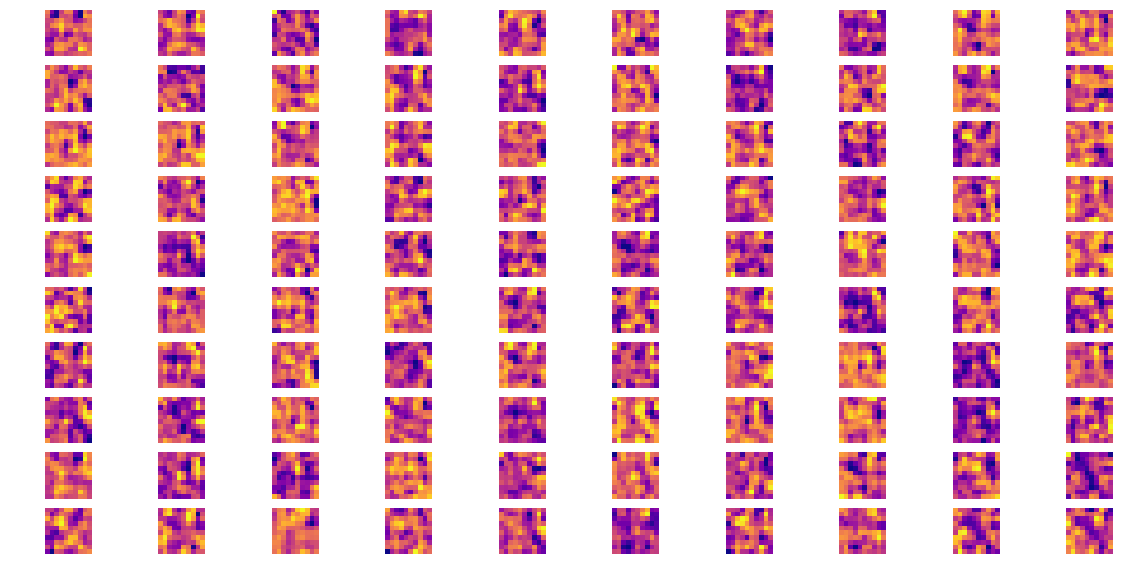

Basis functions after batch number #18


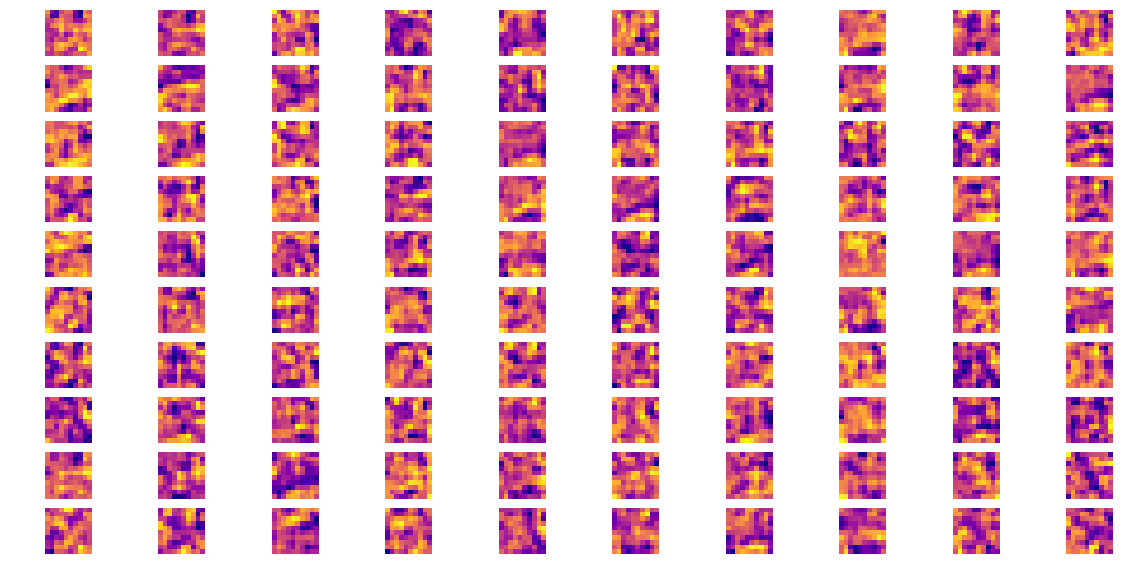

Basis functions after batch number #19


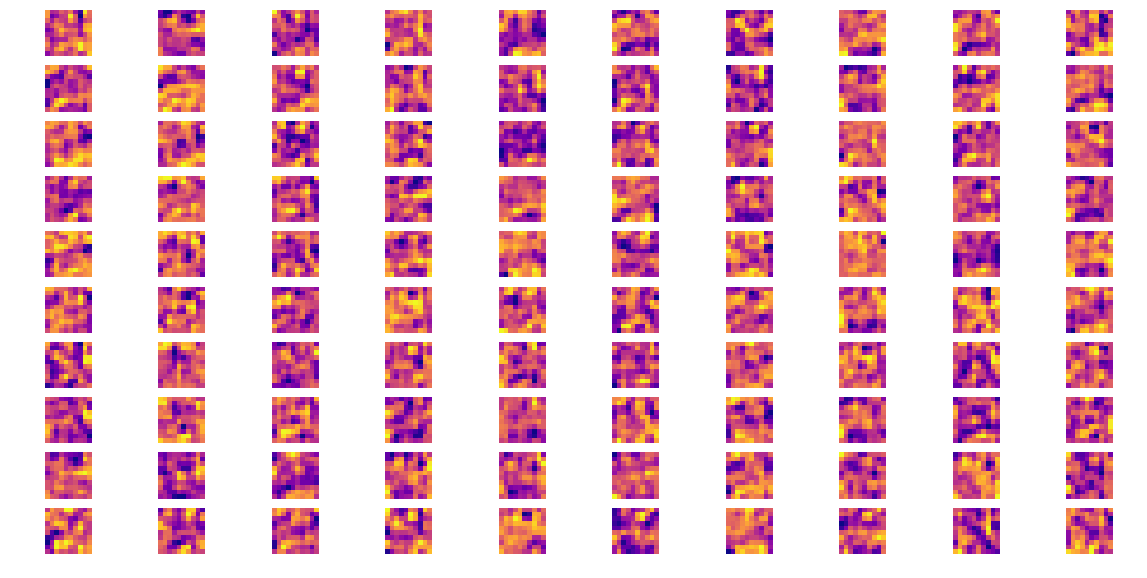

Basis functions after batch number #20


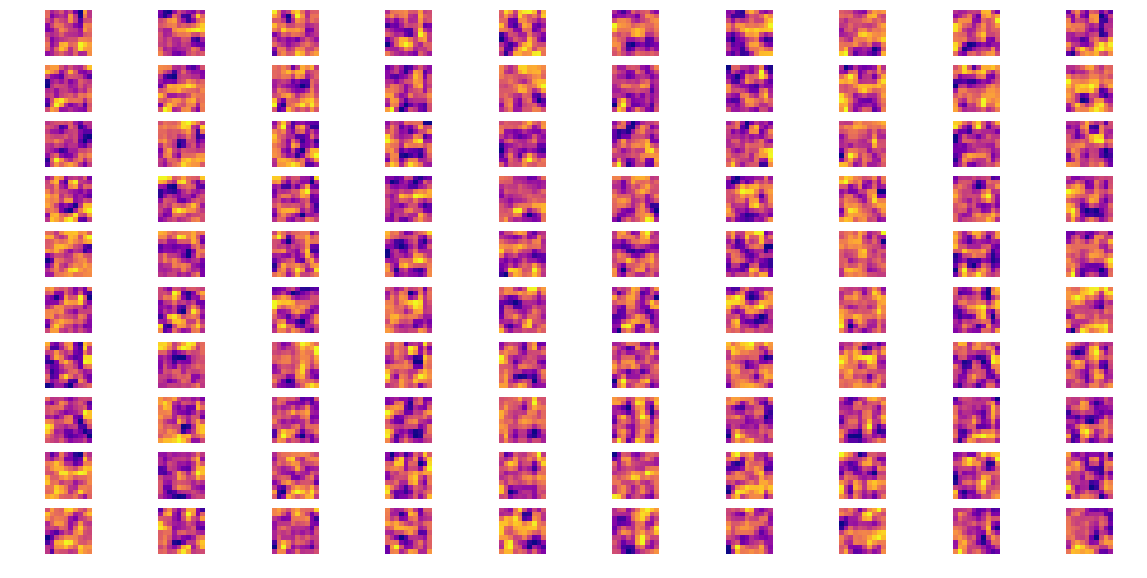

Basis functions after batch number #21


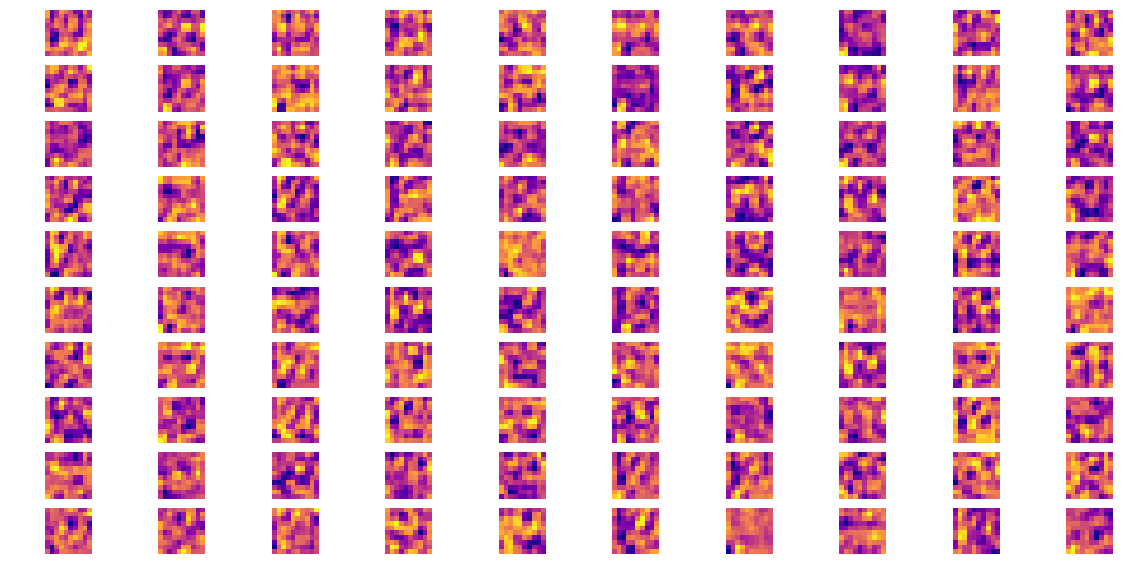

Basis functions after batch number #22


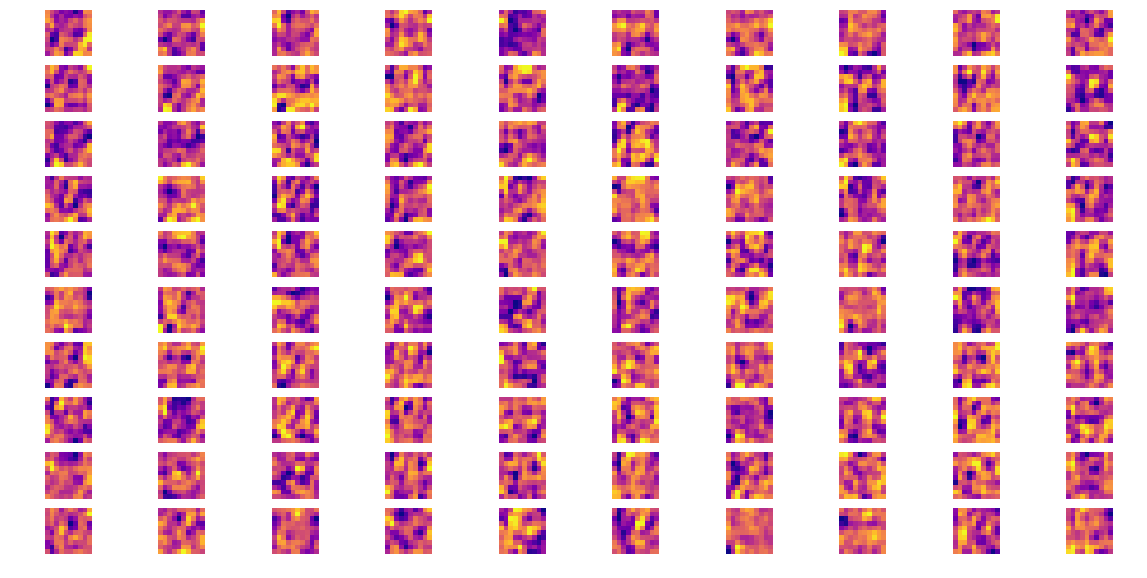

Basis functions after batch number #23


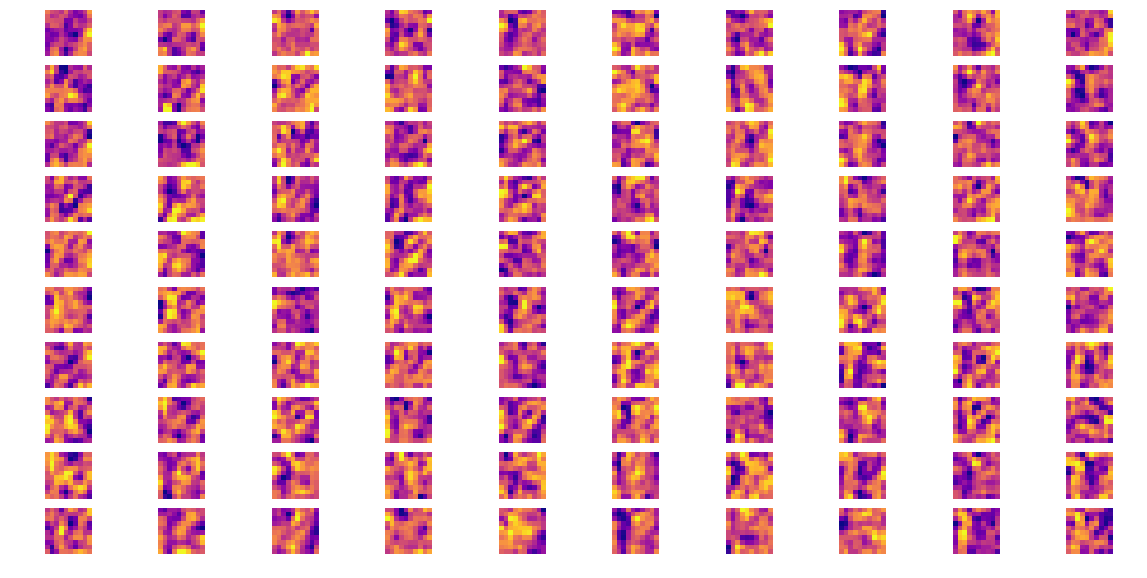

Basis functions after batch number #24


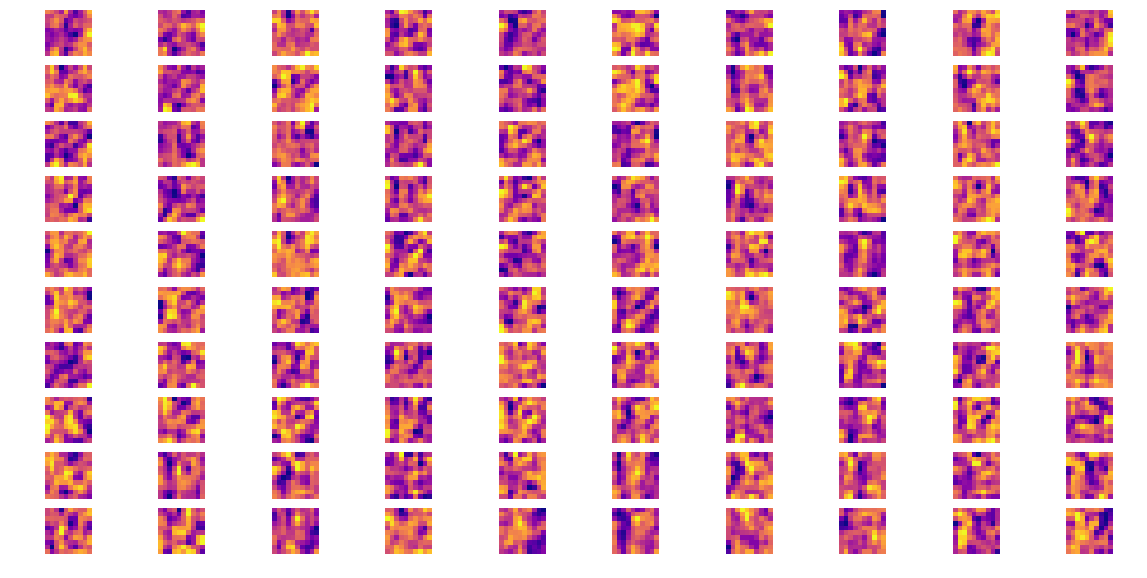

Basis functions after batch number #25


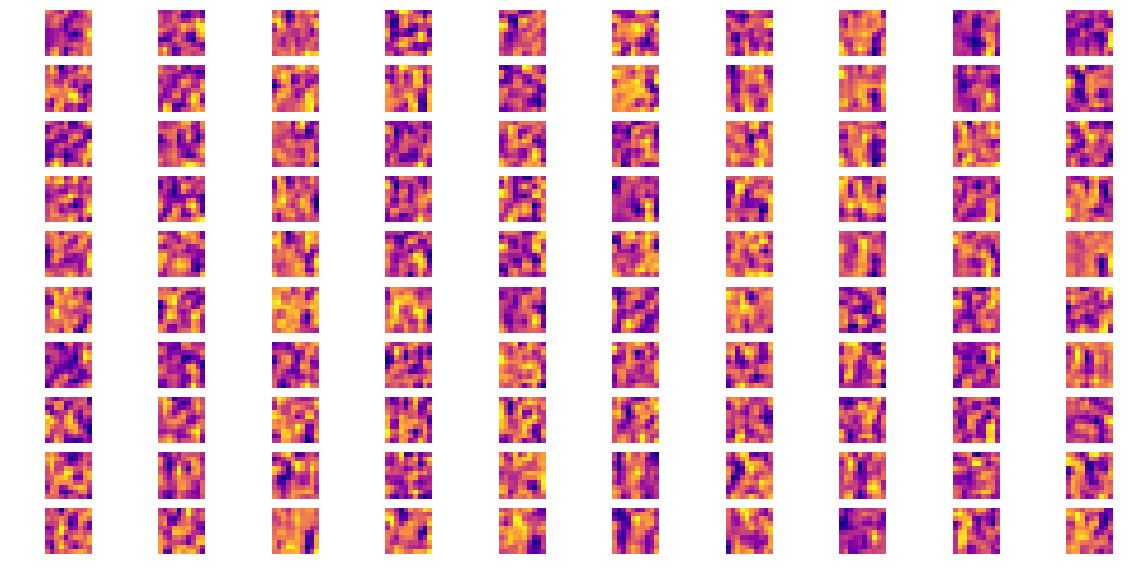

Basis functions after batch number #26


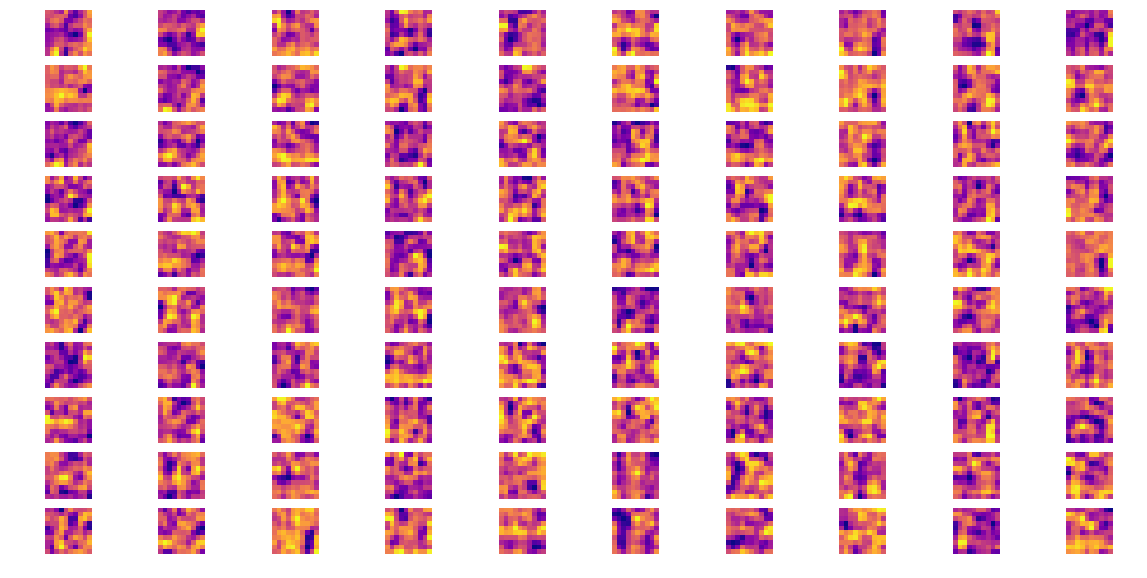

Basis functions after batch number #27


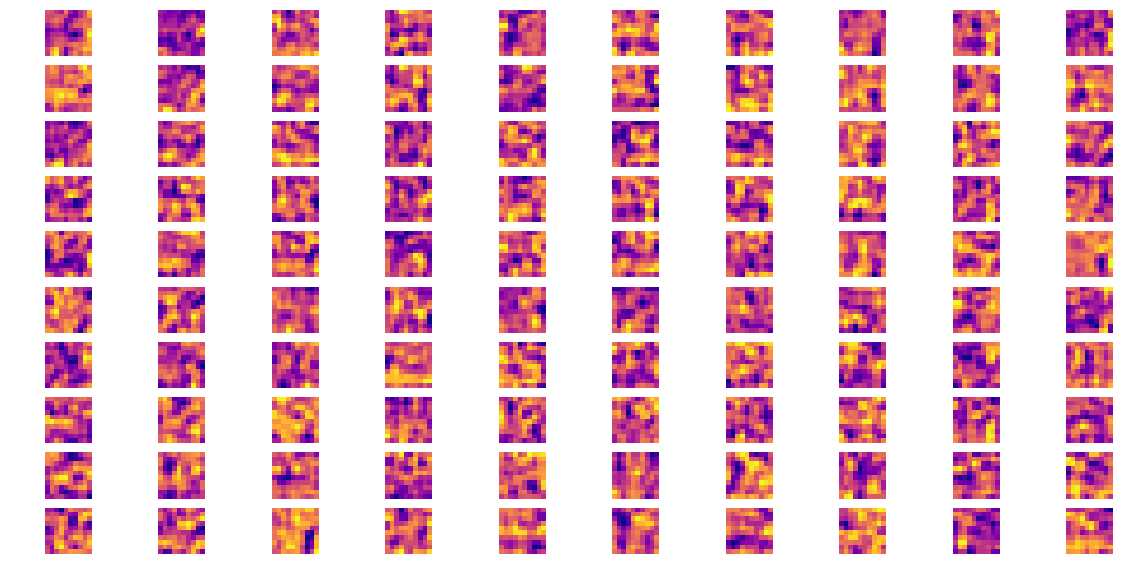

Basis functions after batch number #28


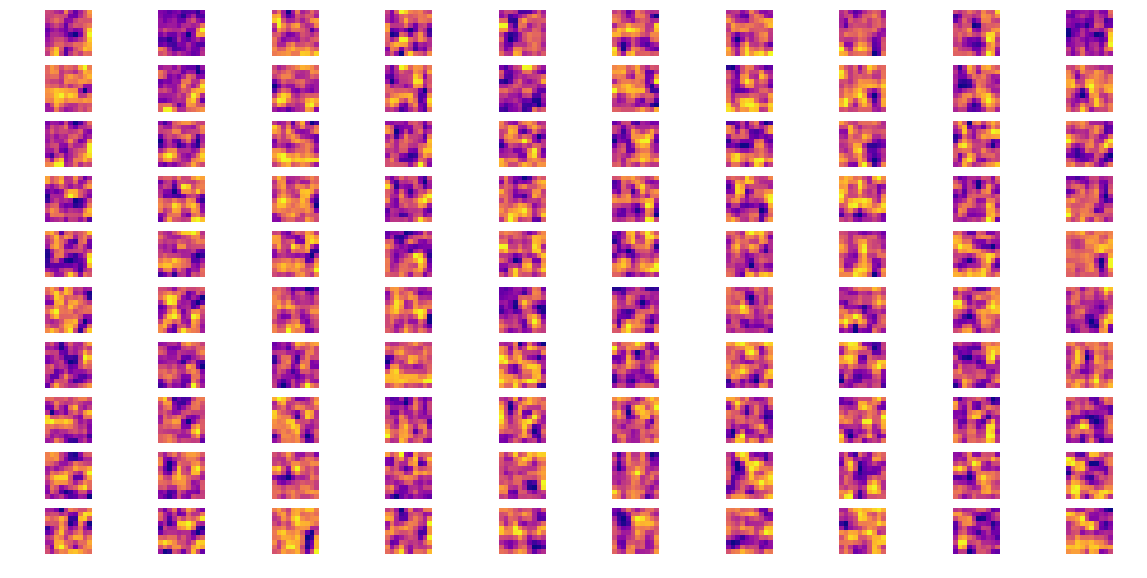

Basis functions after batch number #29


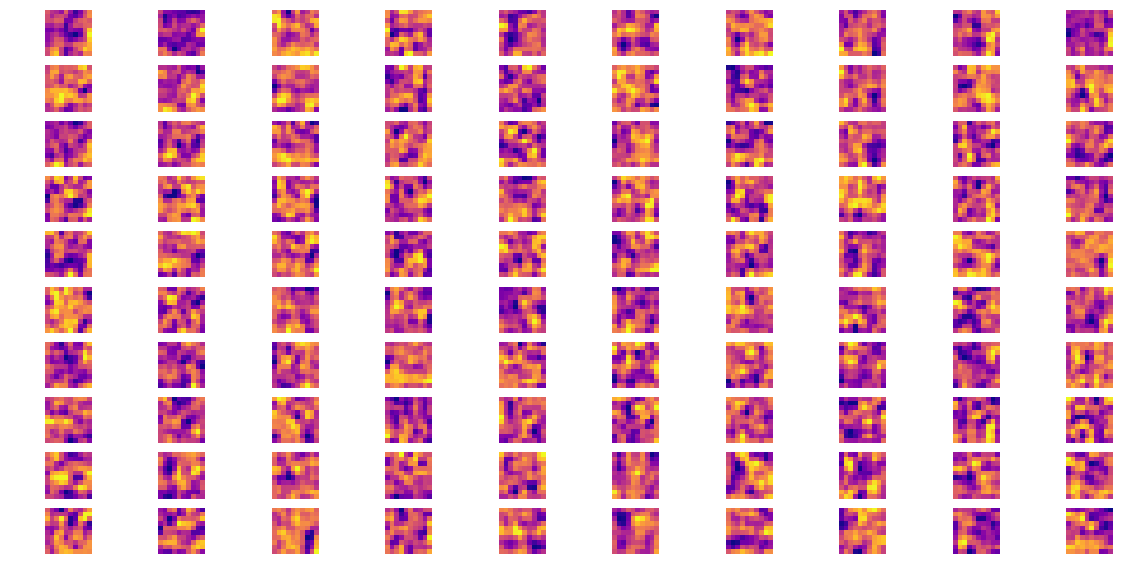

Basis functions after batch number #30


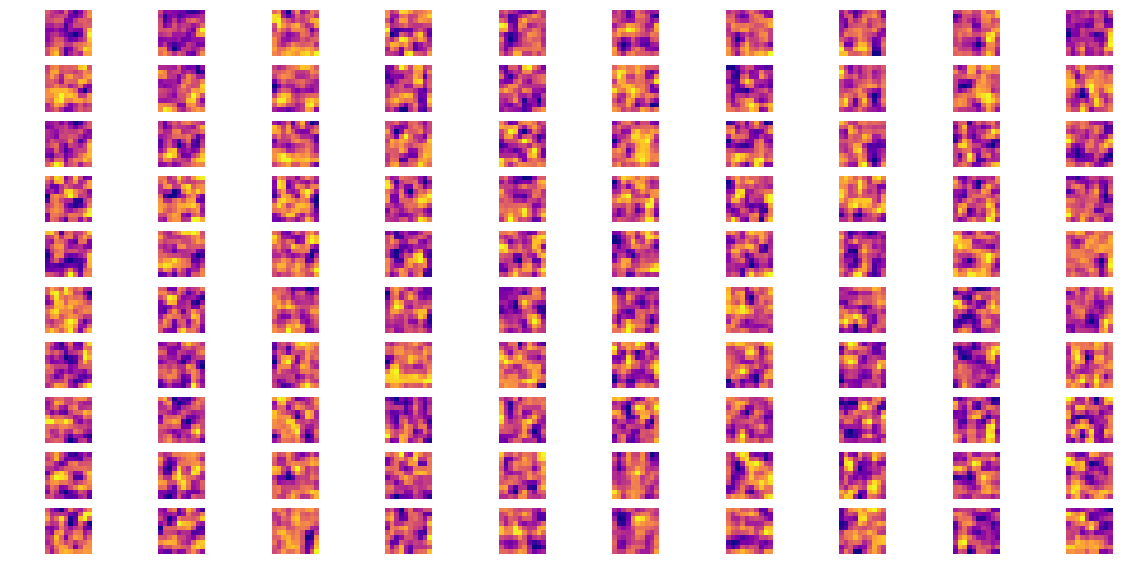

Basis functions after batch number #31


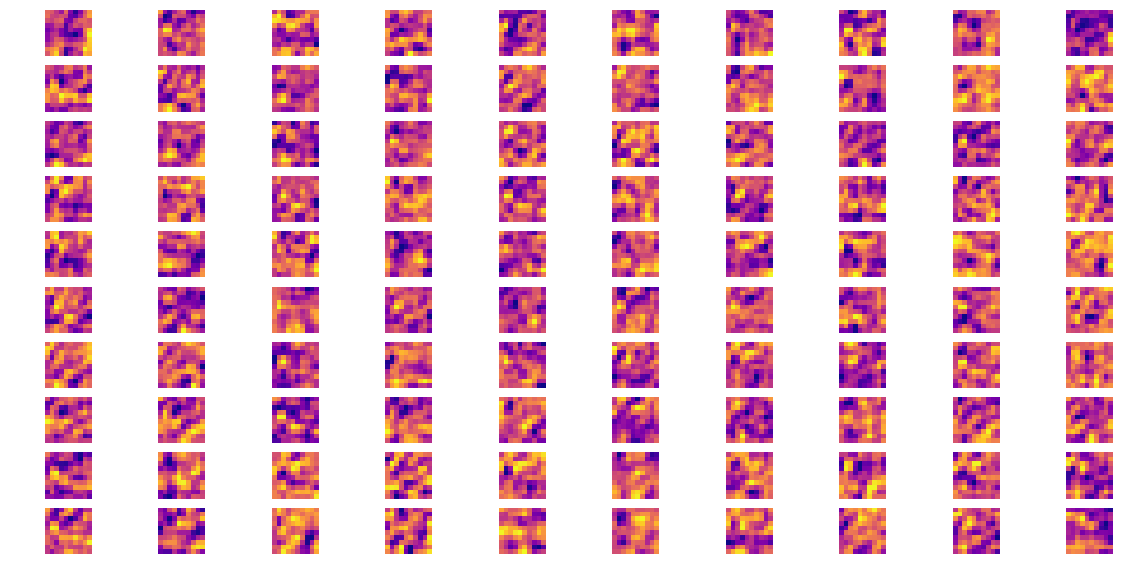

Basis functions after batch number #32


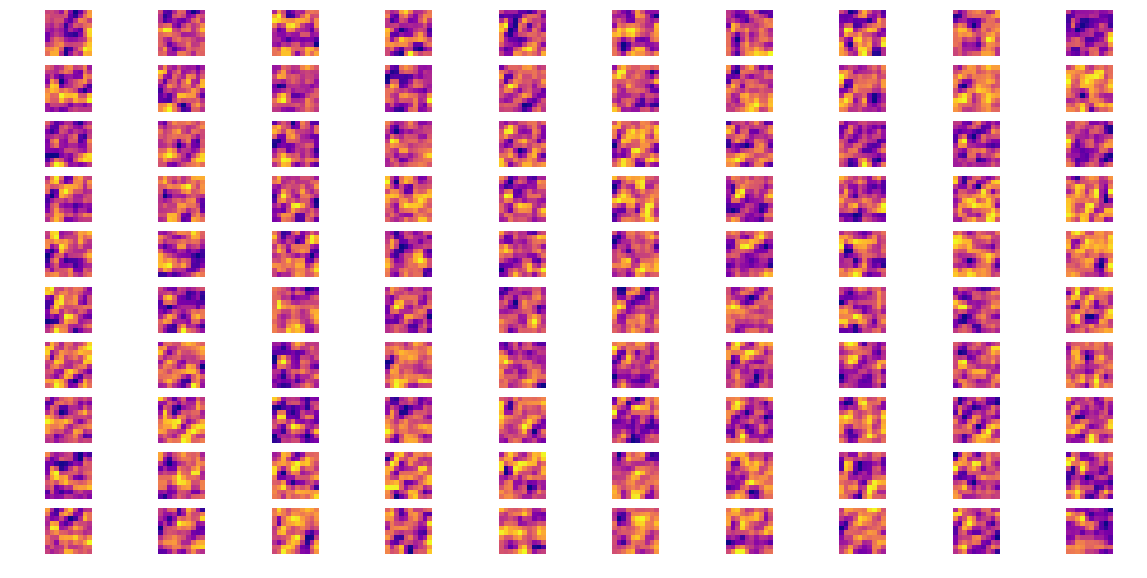

Basis functions after batch number #33


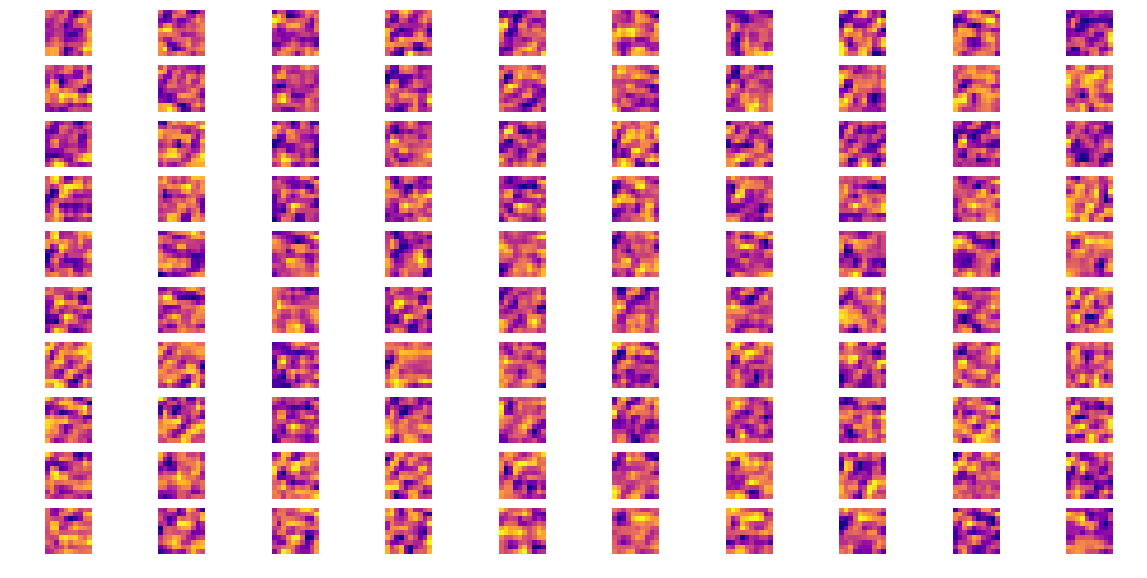

Basis functions after batch number #34


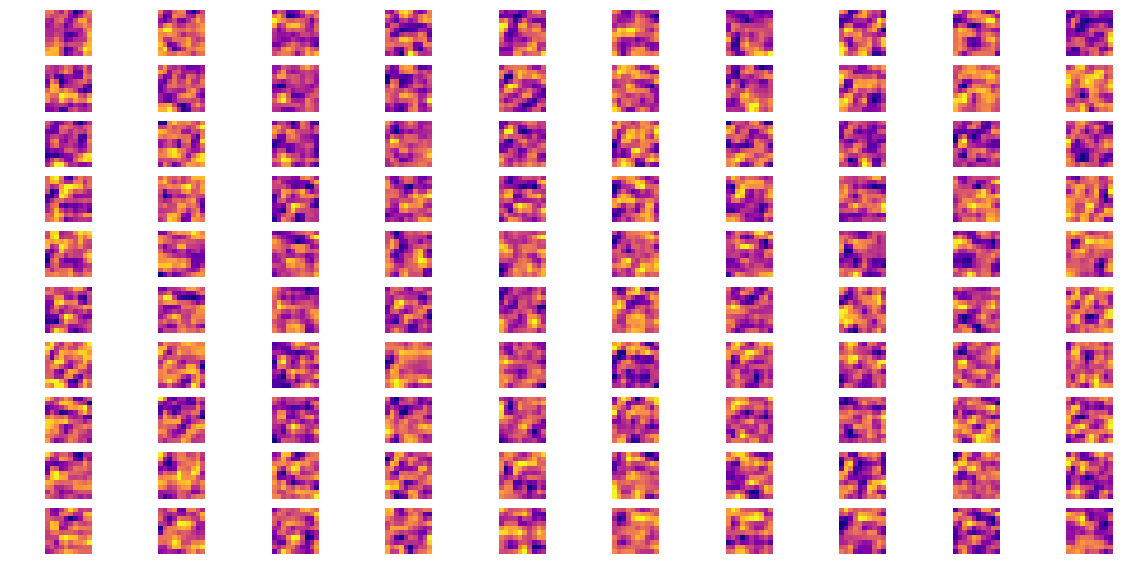

Basis functions after batch number #35


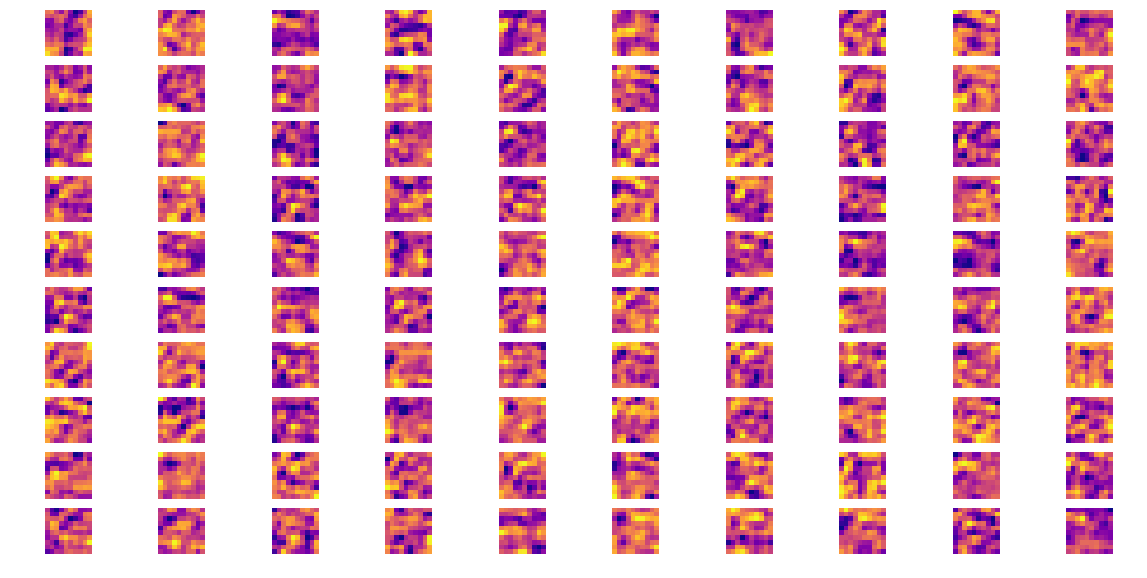

Basis functions after batch number #36


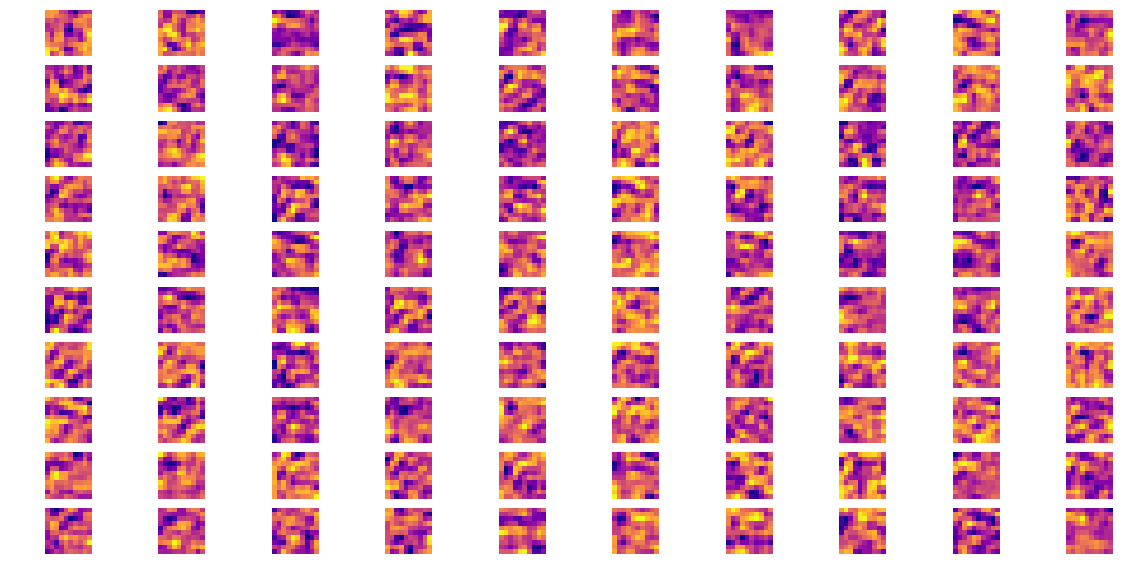

Basis functions after batch number #37


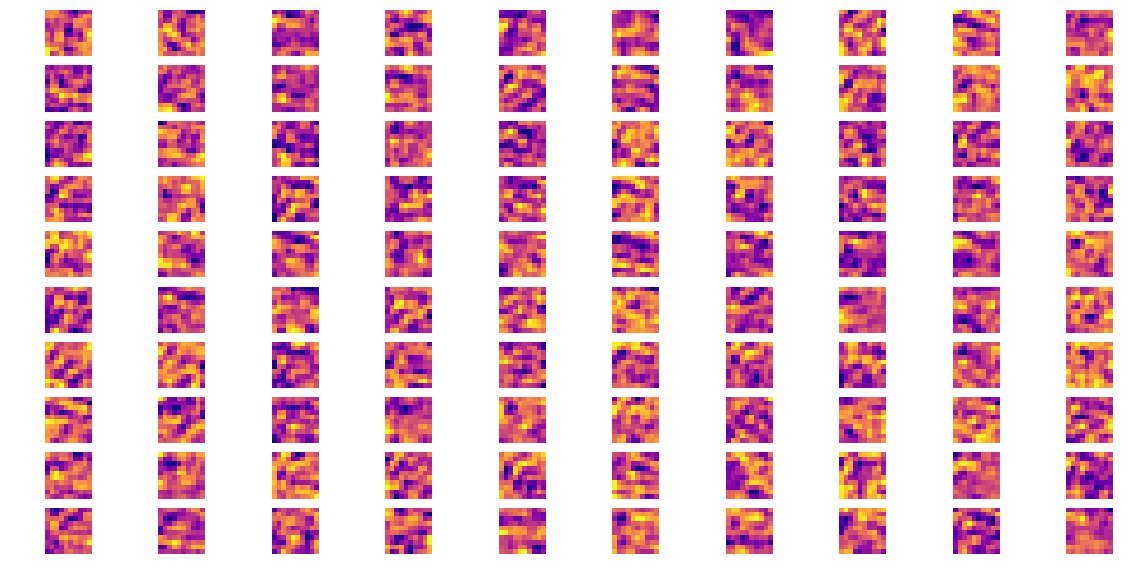

Basis functions after batch number #38


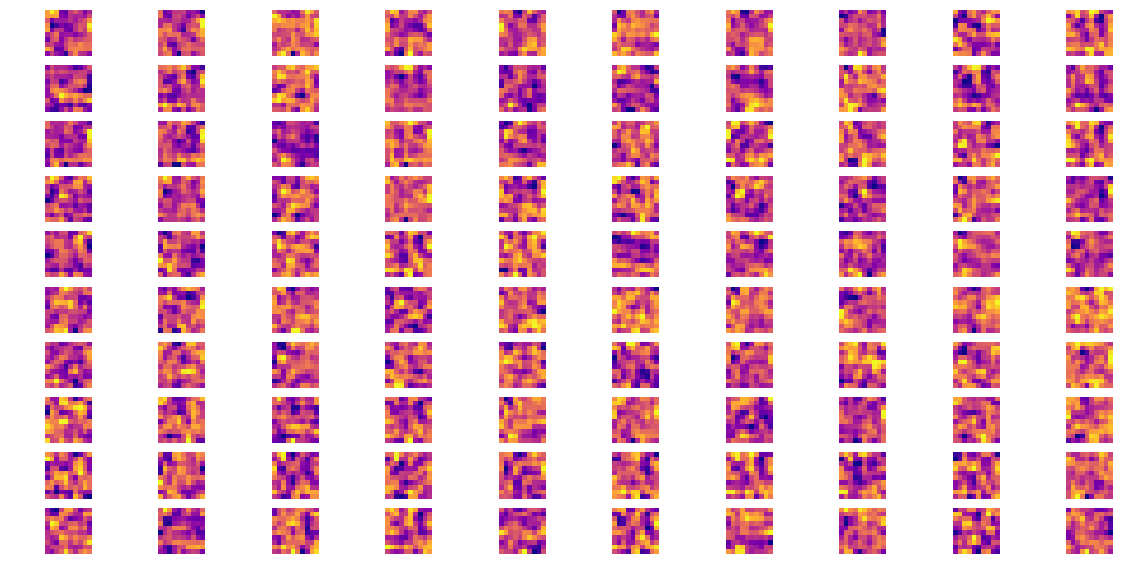

Basis functions after batch number #39


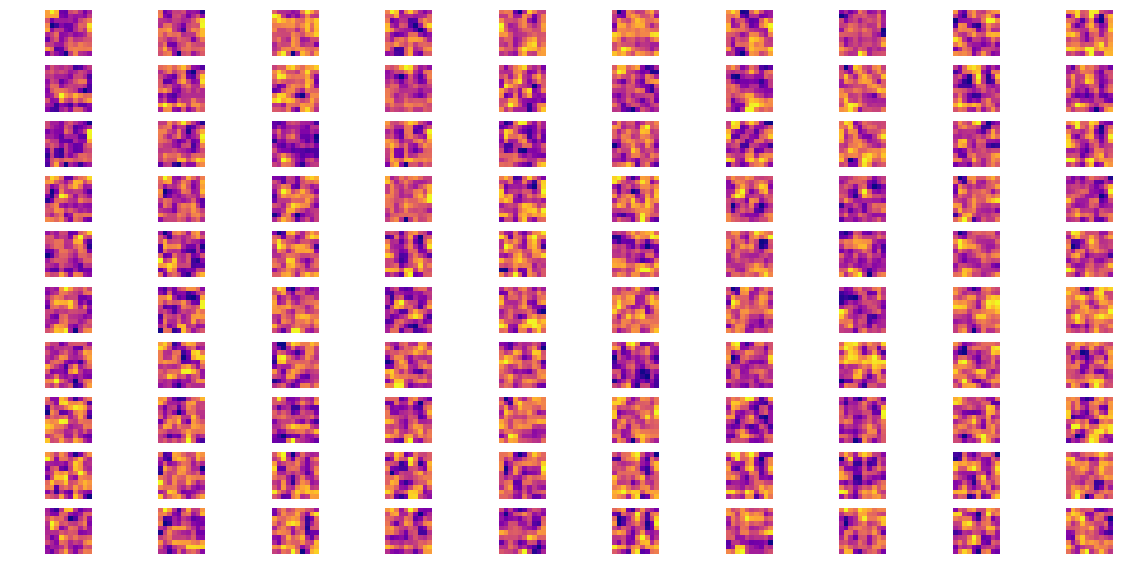

Basis functions after batch number #40


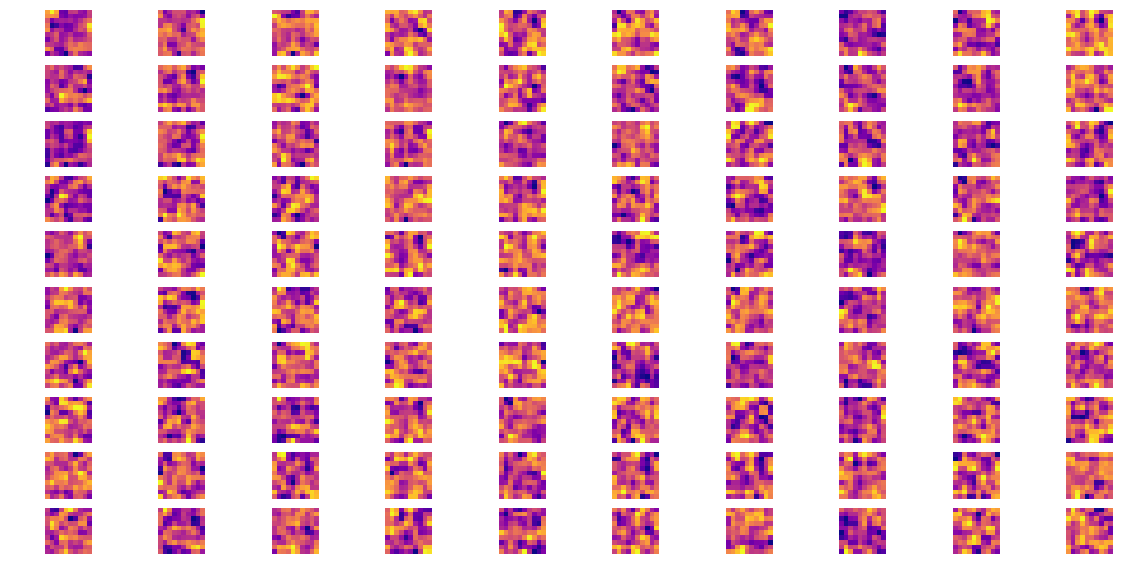

Basis functions after batch number #41


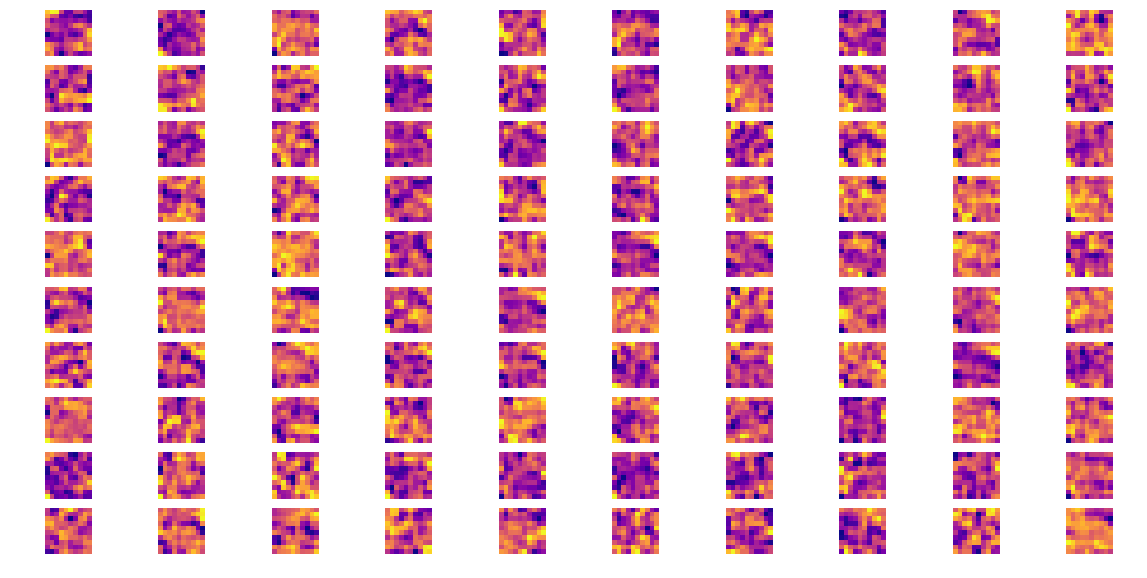

Basis functions after batch number #42


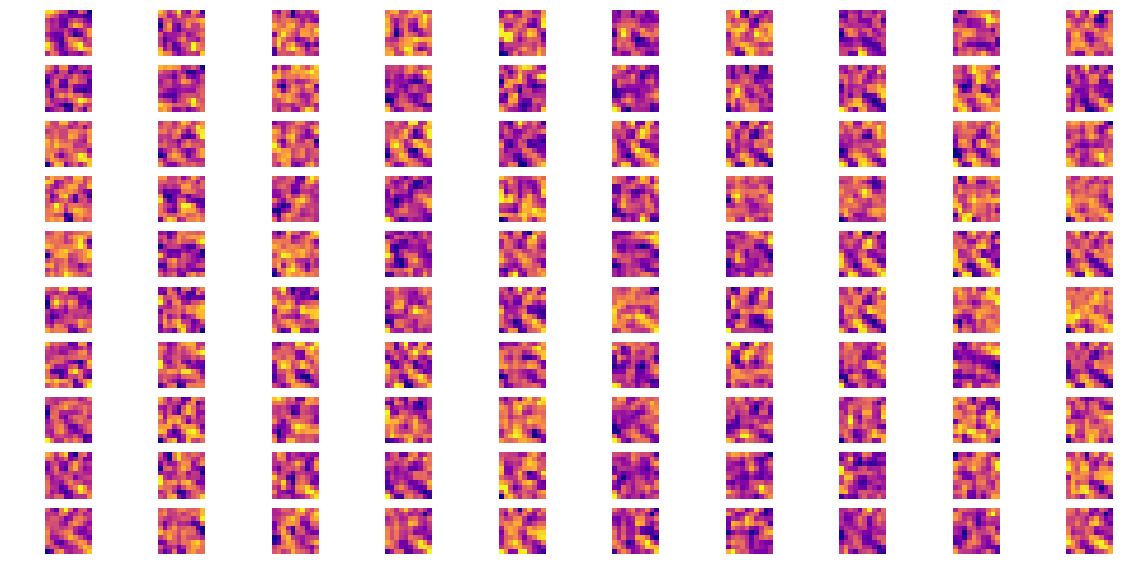

Basis functions after batch number #43


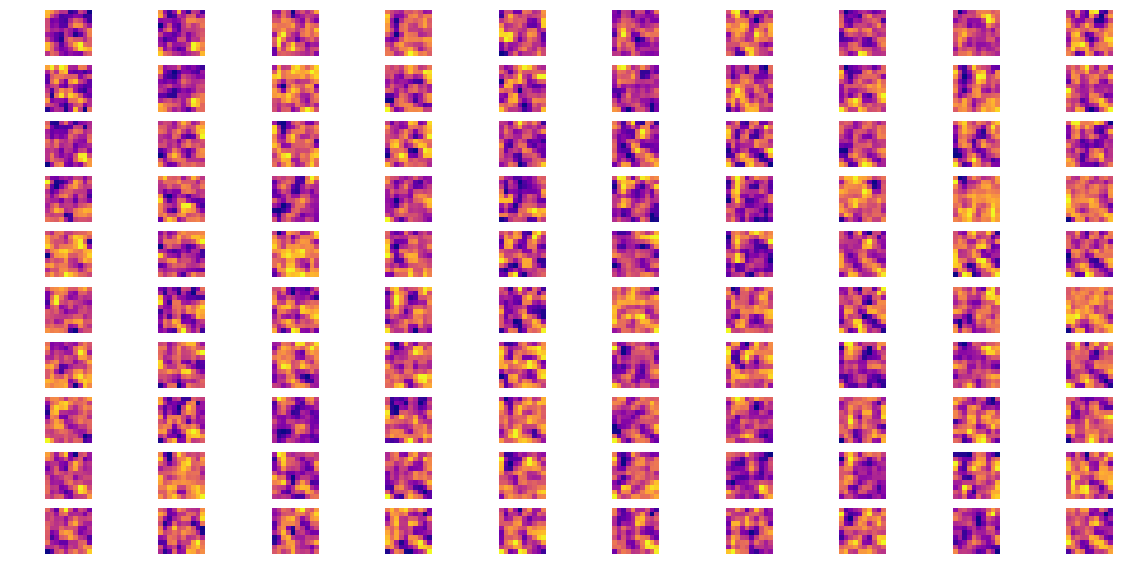

Basis functions after batch number #44


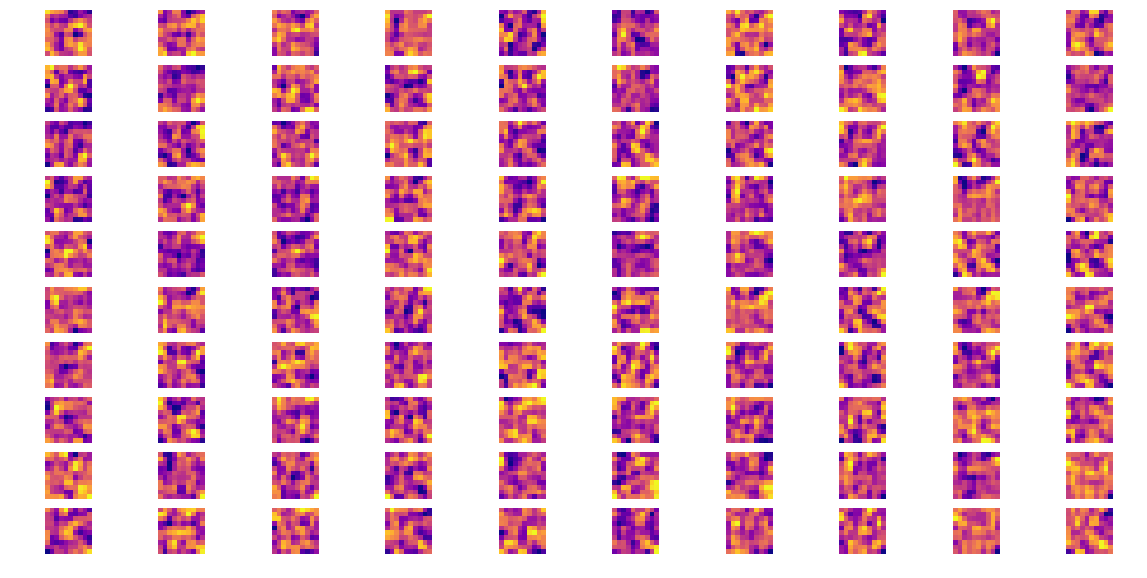

Basis functions after batch number #45


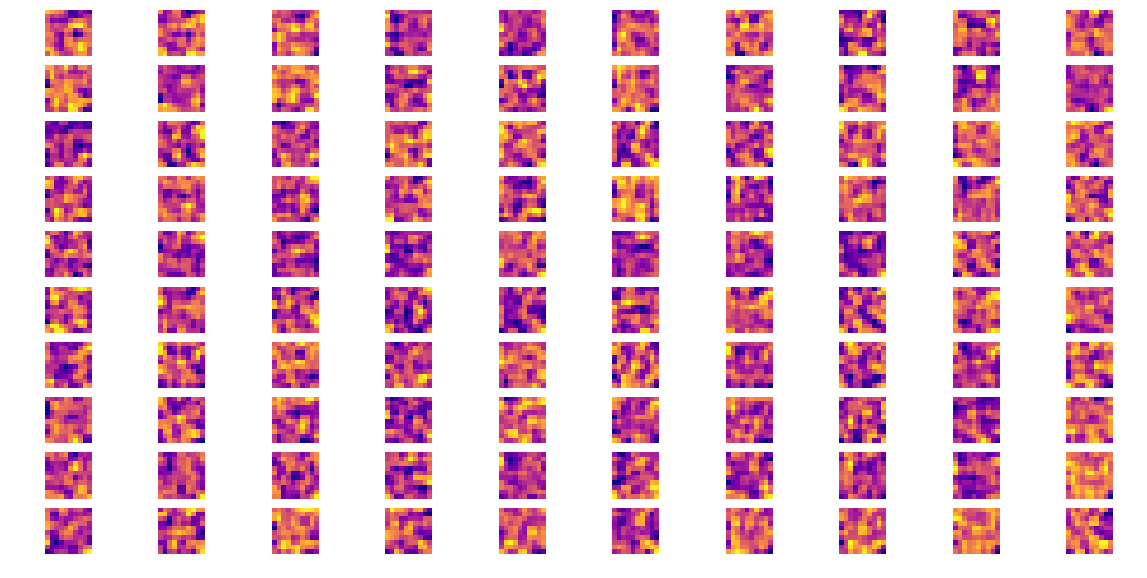

Basis functions after batch number #46


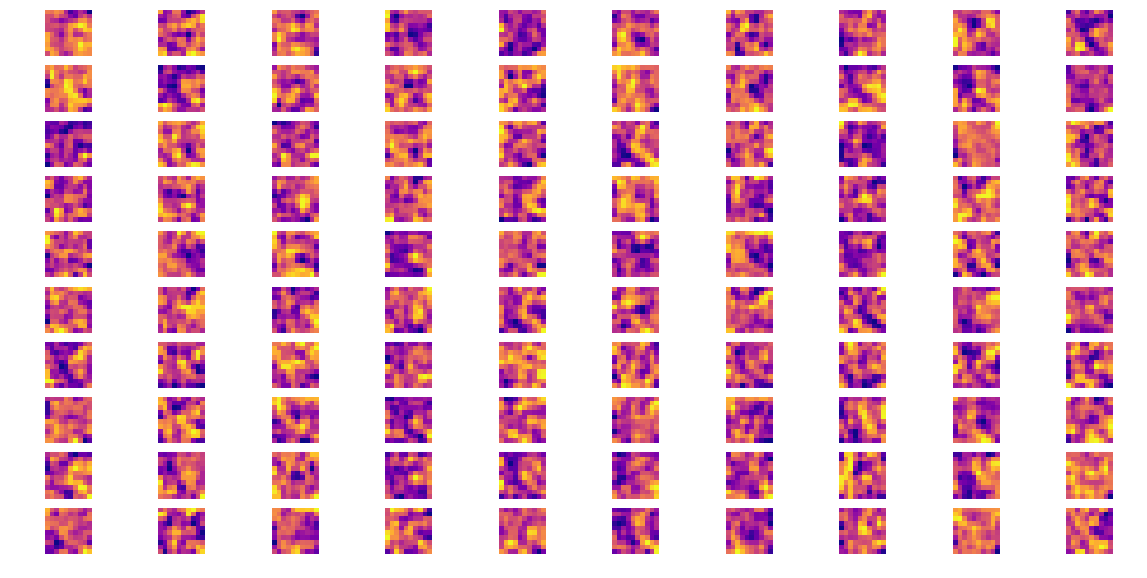

Basis functions after batch number #47


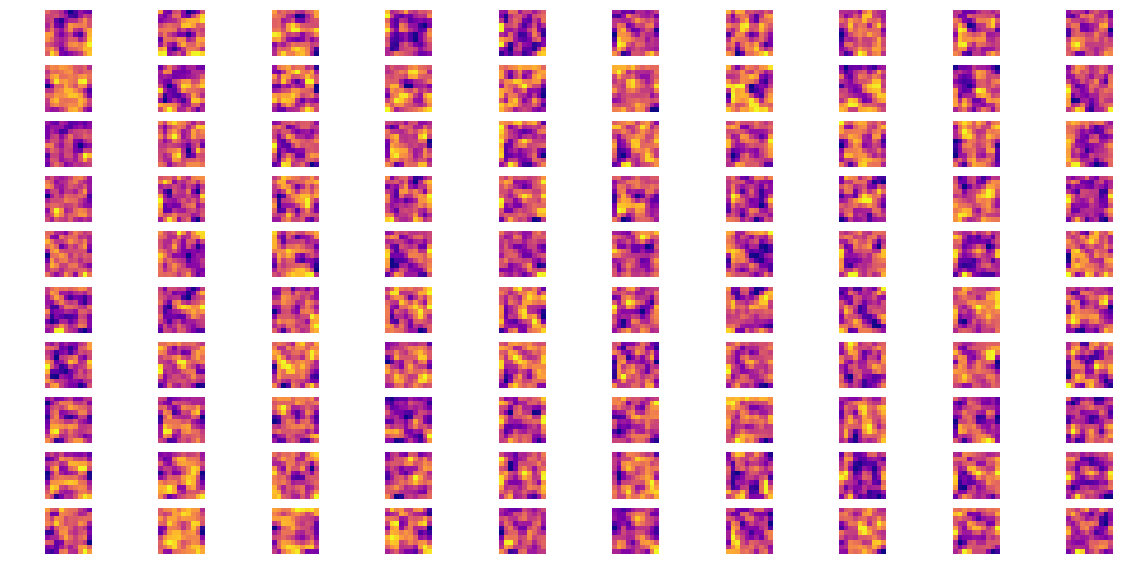

Basis functions after batch number #48


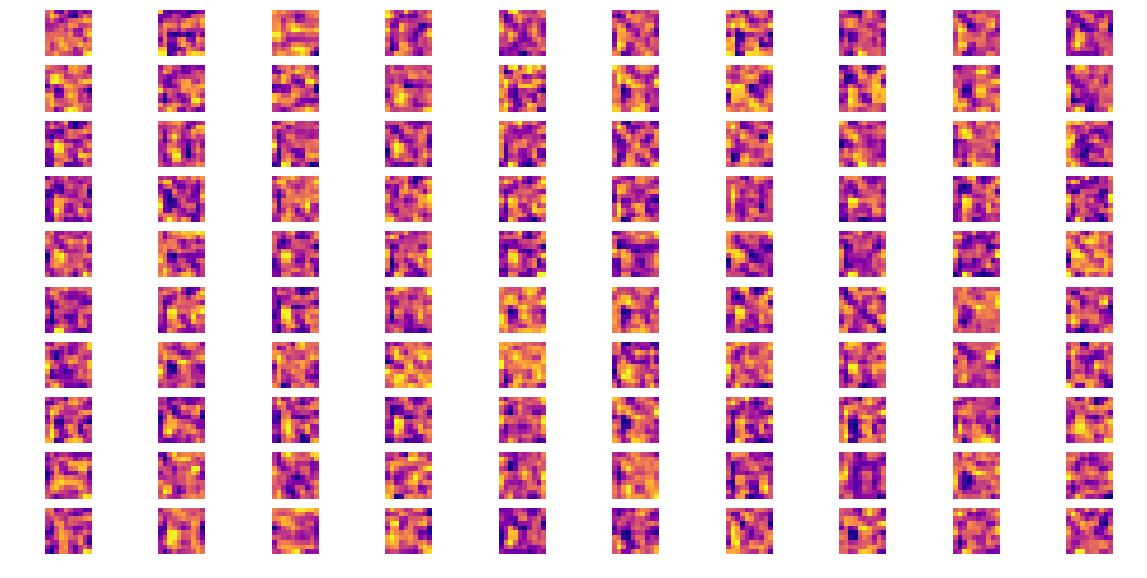

Basis functions after batch number #49


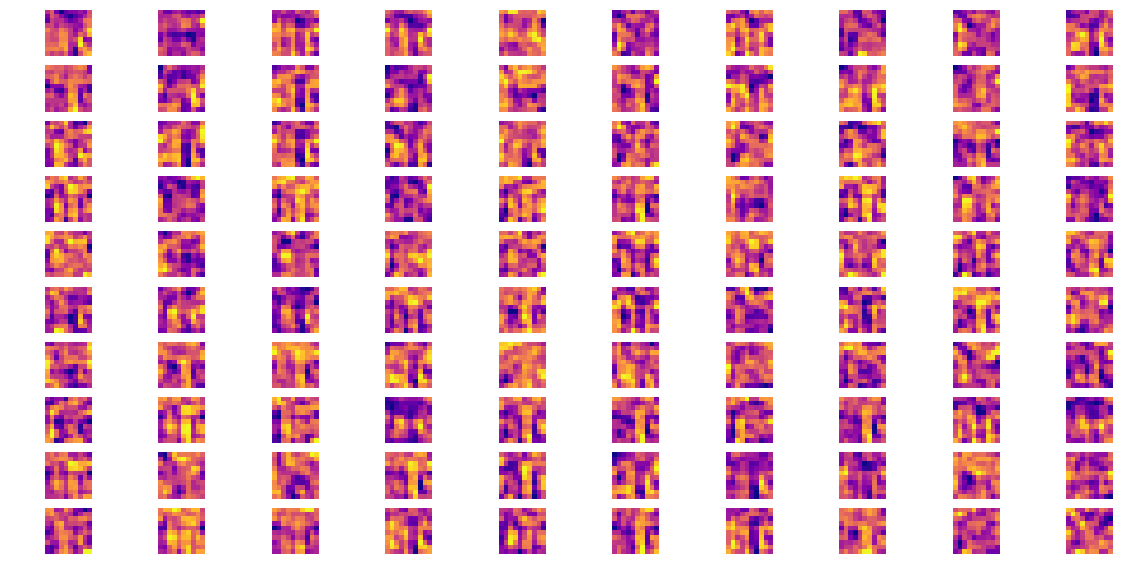

Basis functions after batch number #50


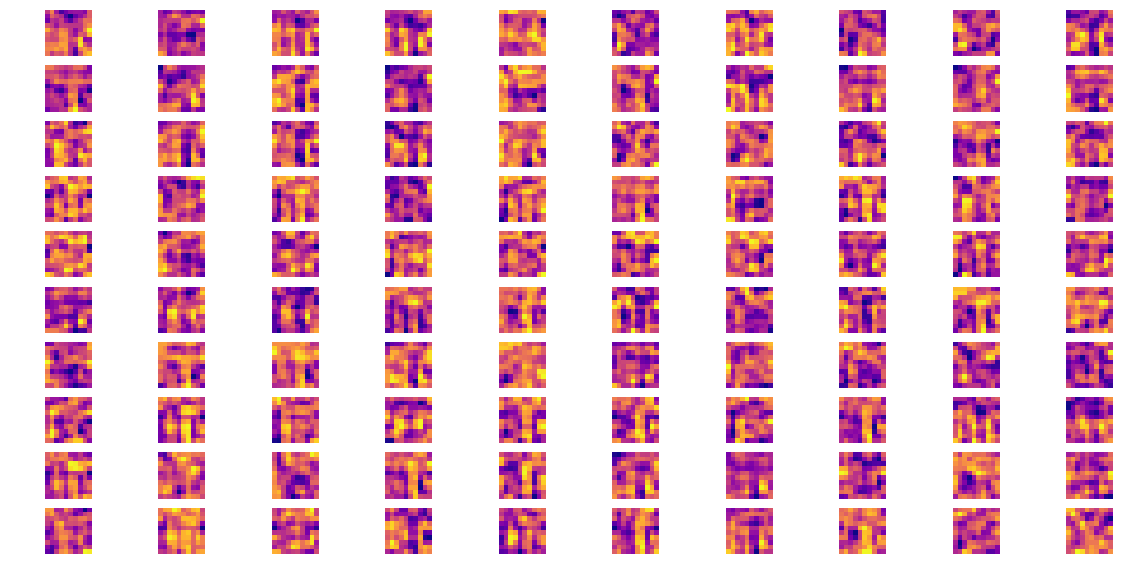

Basis functions after batch number #51


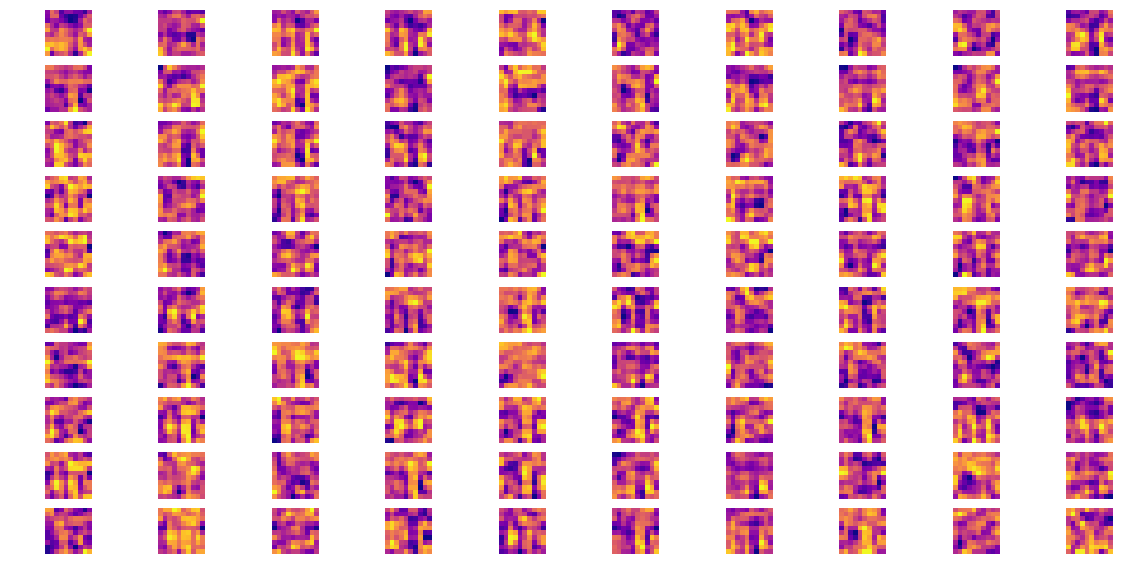

Basis functions after batch number #52


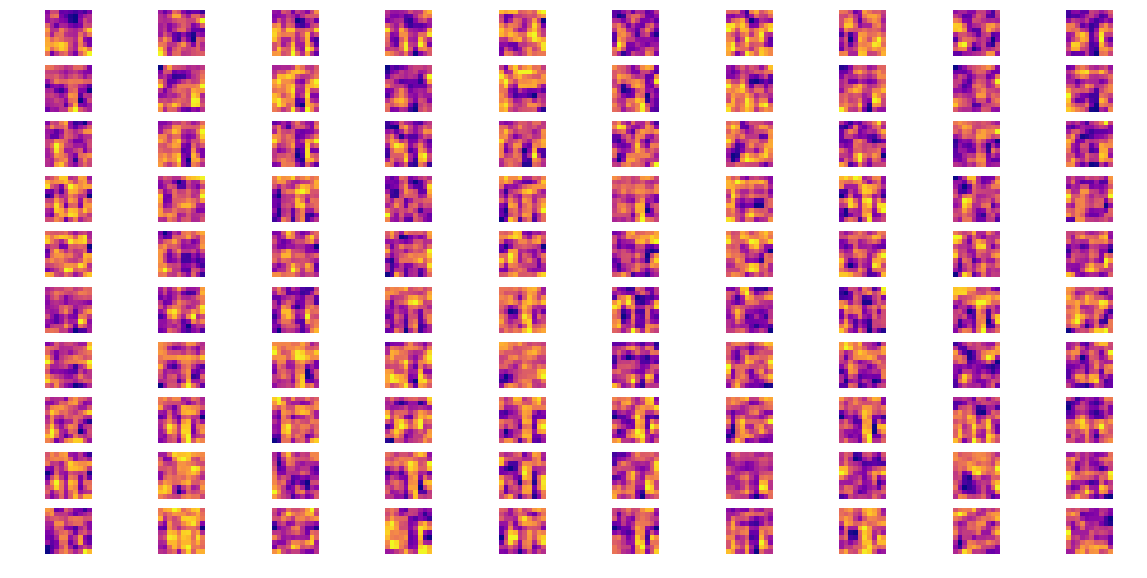

Basis functions after batch number #53


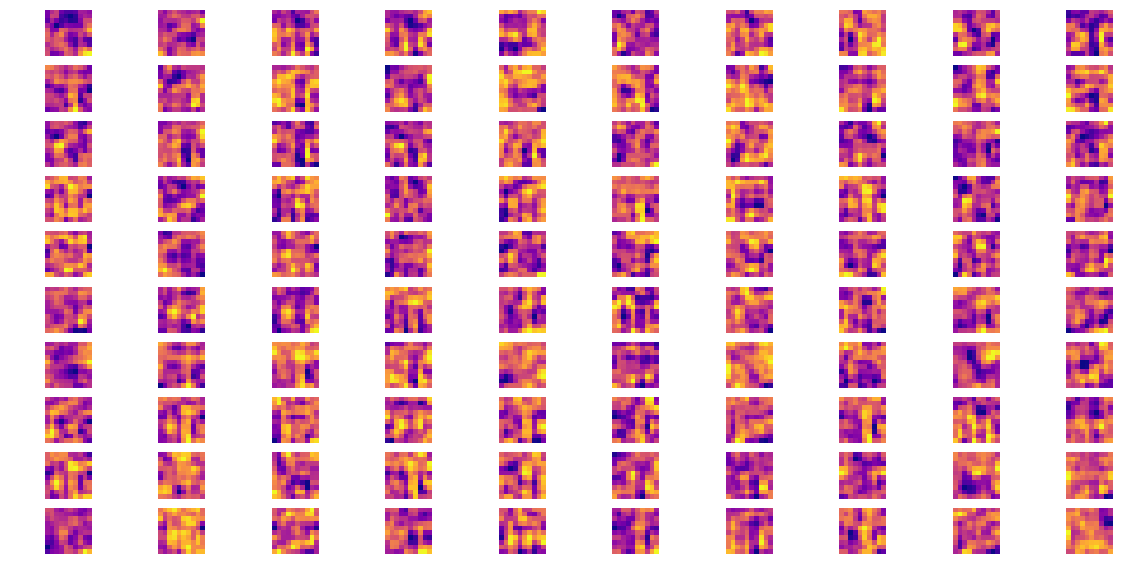

Basis functions after batch number #54


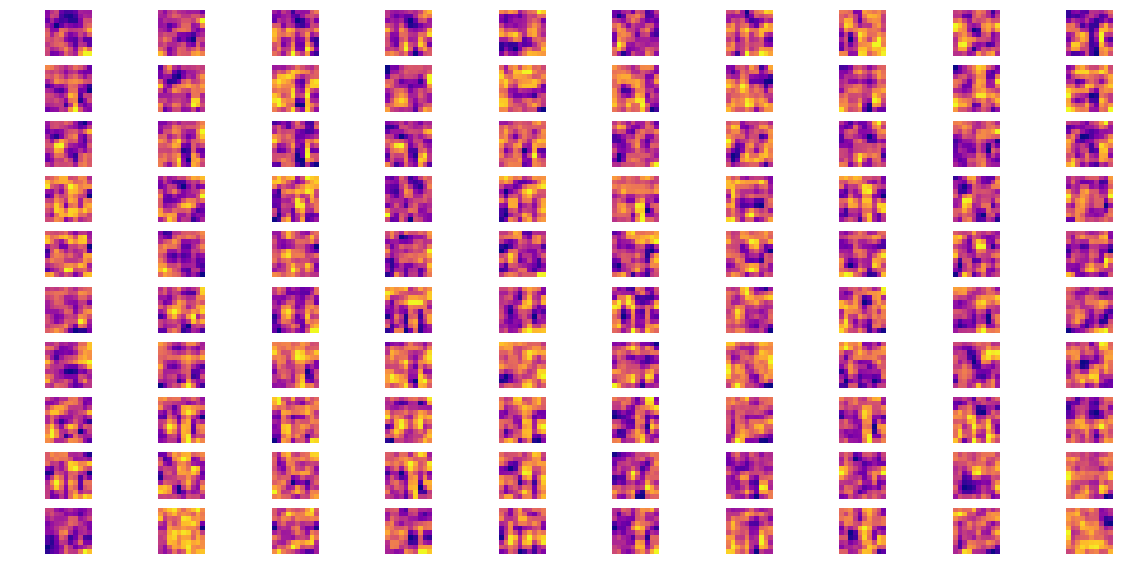

Basis functions after batch number #55


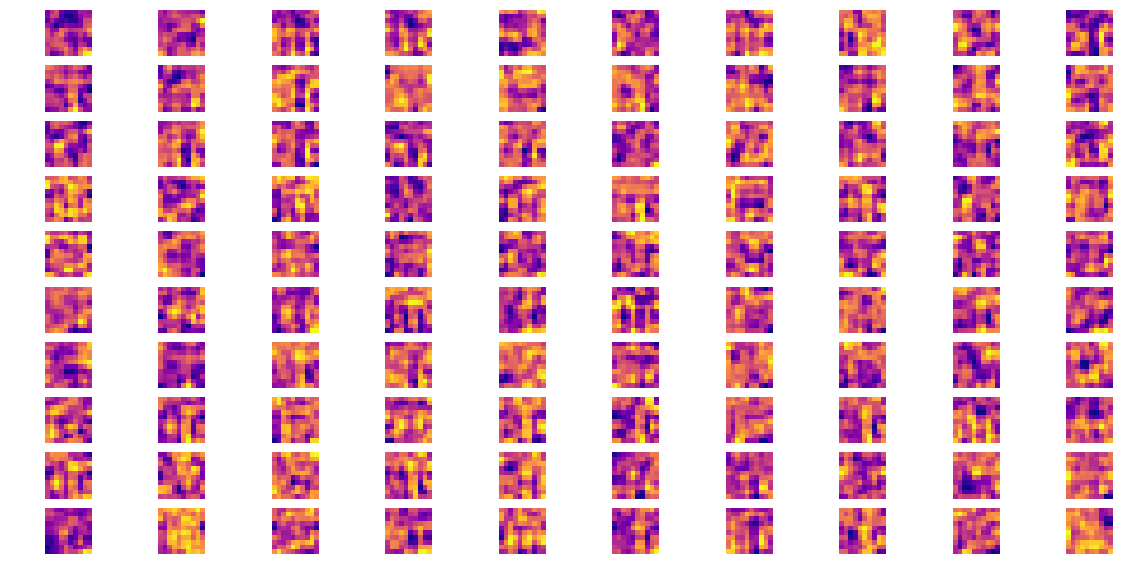

Basis functions after batch number #56


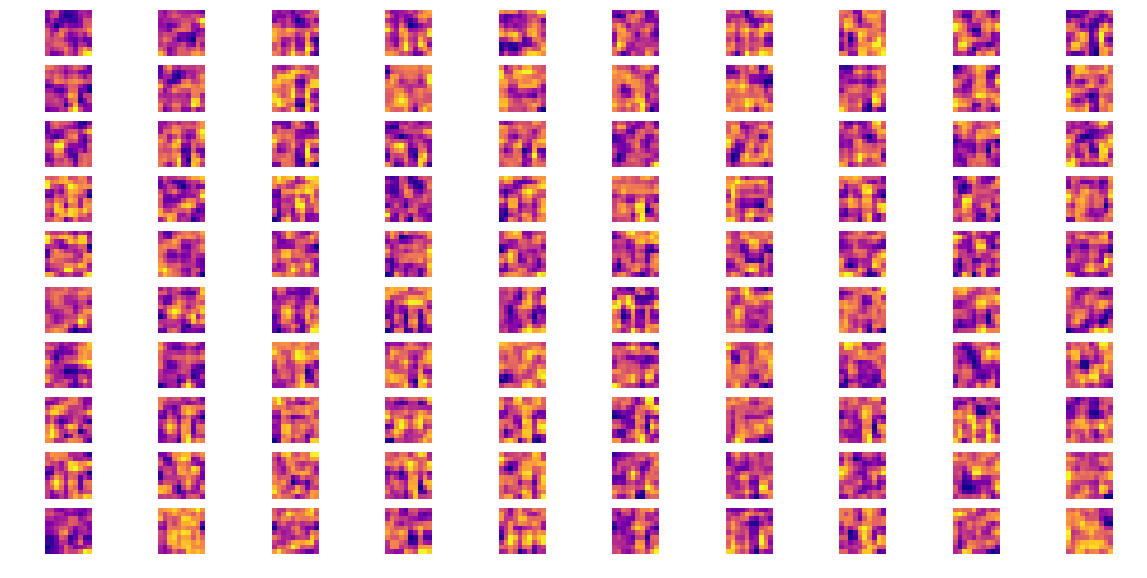

Basis functions after batch number #57


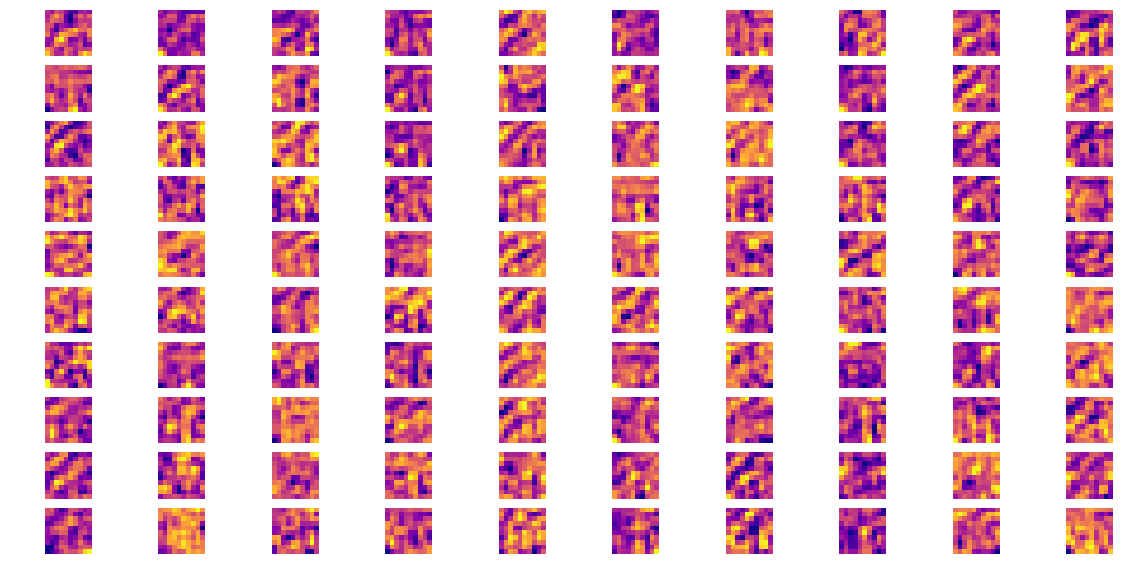

Basis functions after batch number #58


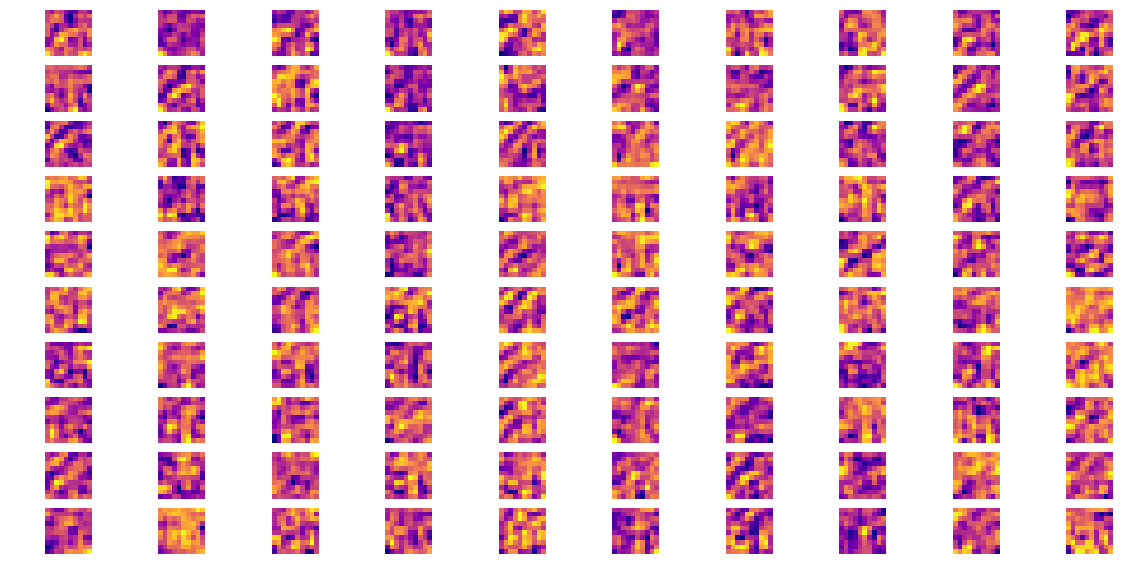

Basis functions after batch number #59


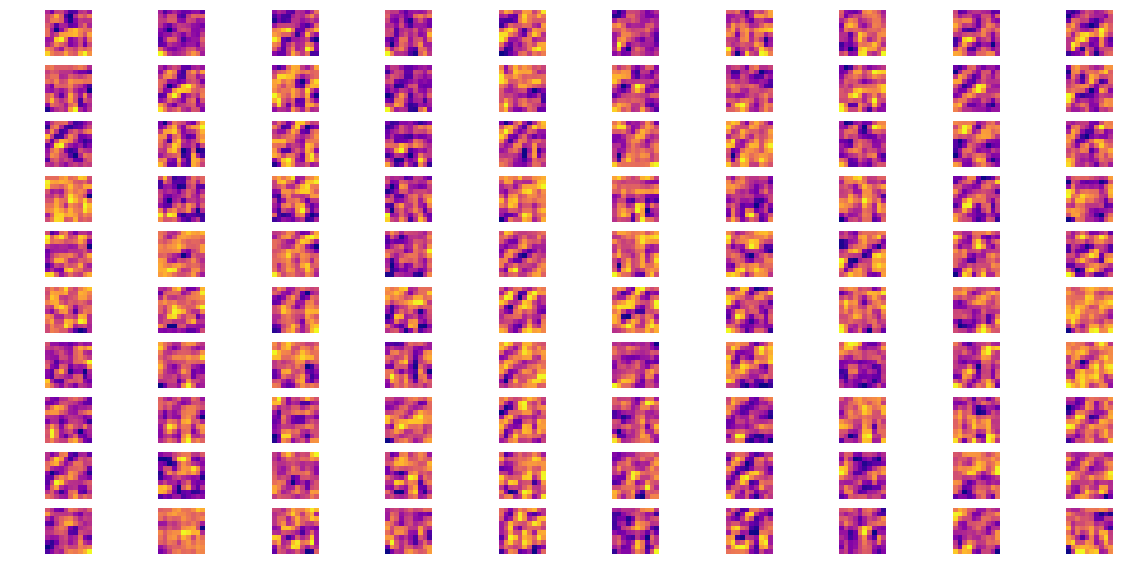

Basis functions after batch number #60


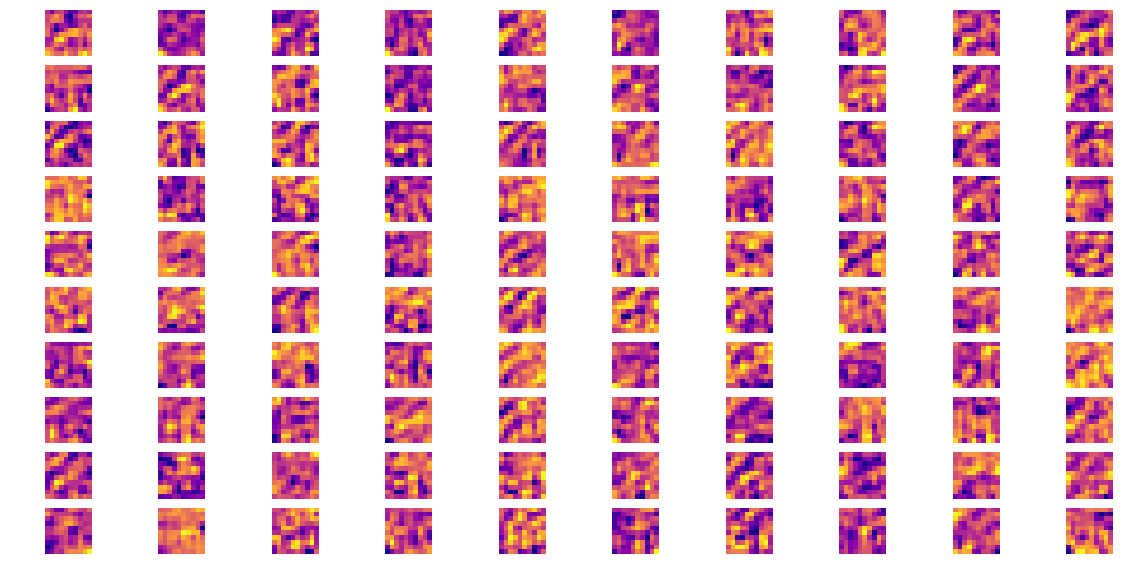

Basis functions after batch number #61


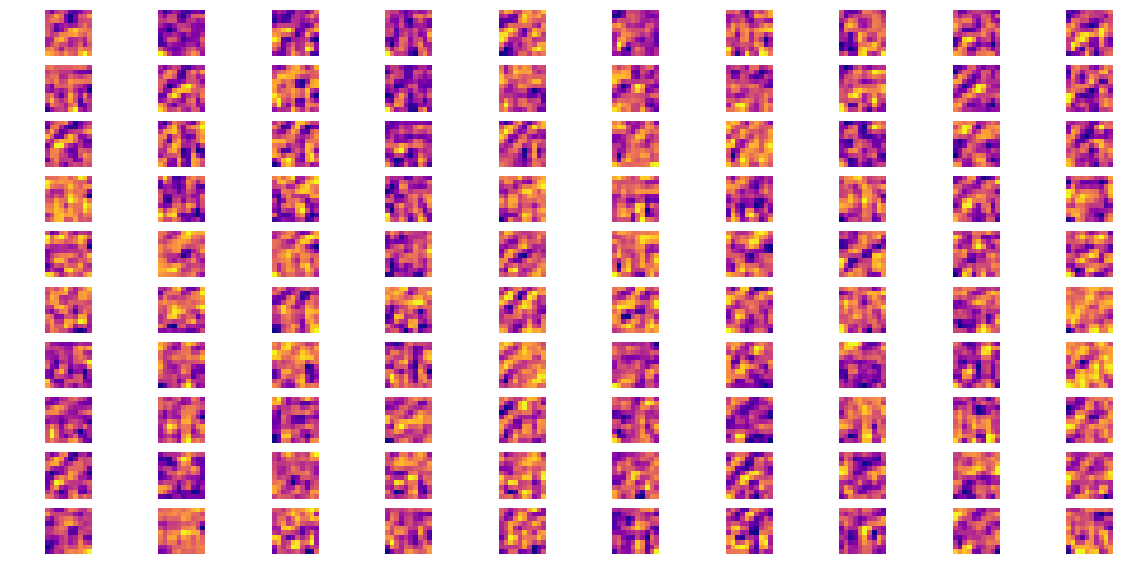

Basis functions after batch number #62


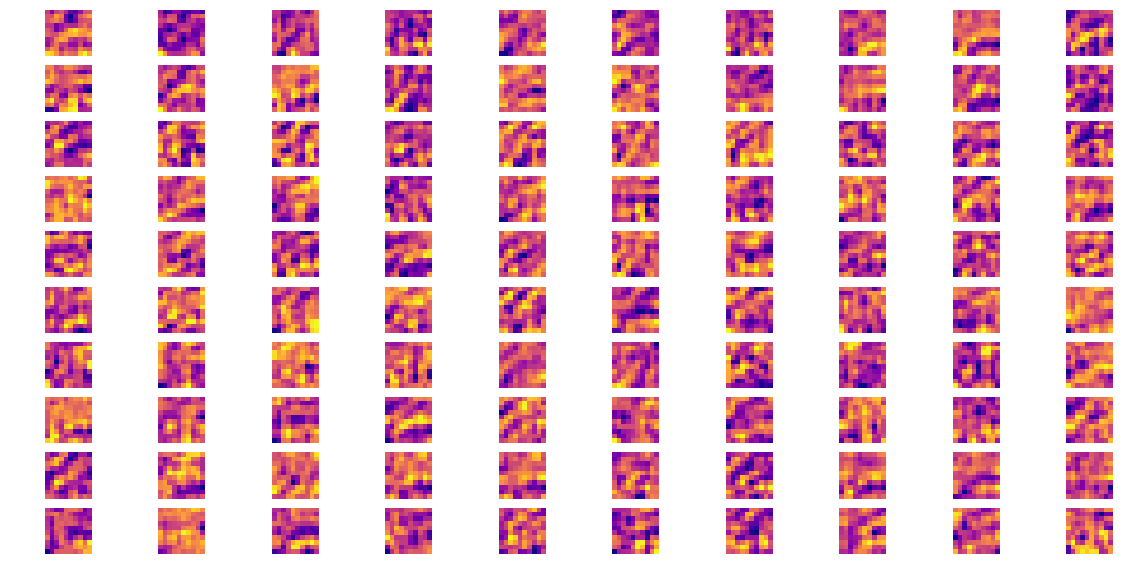

Basis functions after batch number #63


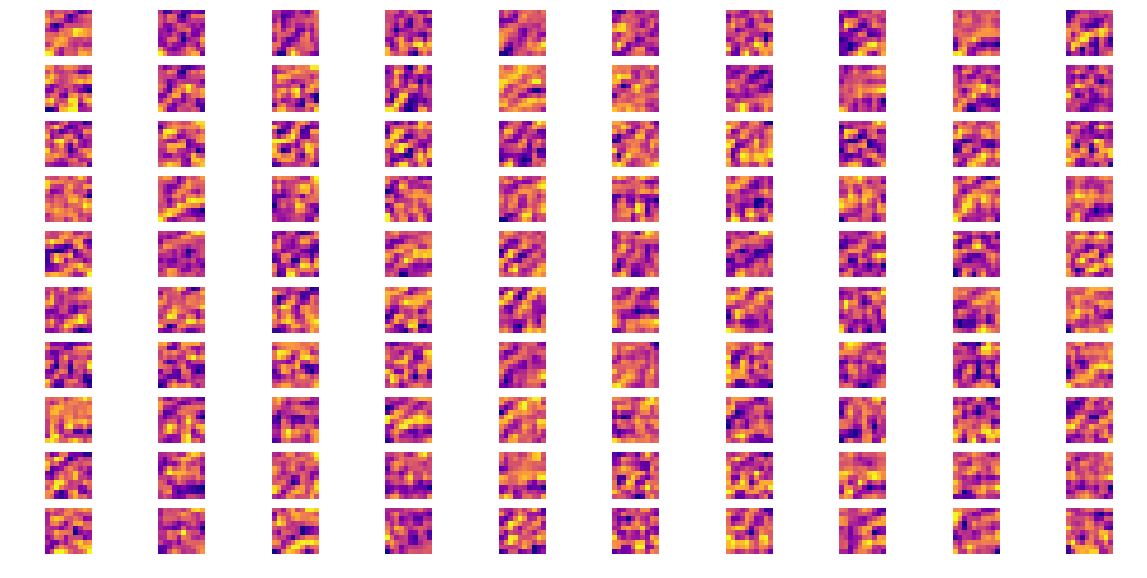

Basis functions after batch number #64


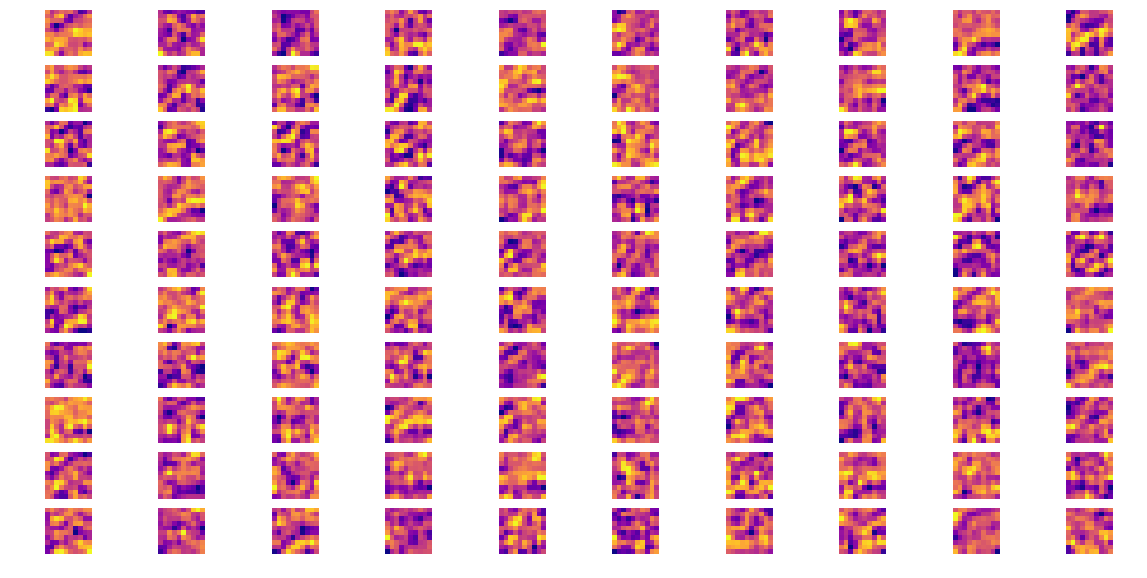

Basis functions after batch number #65


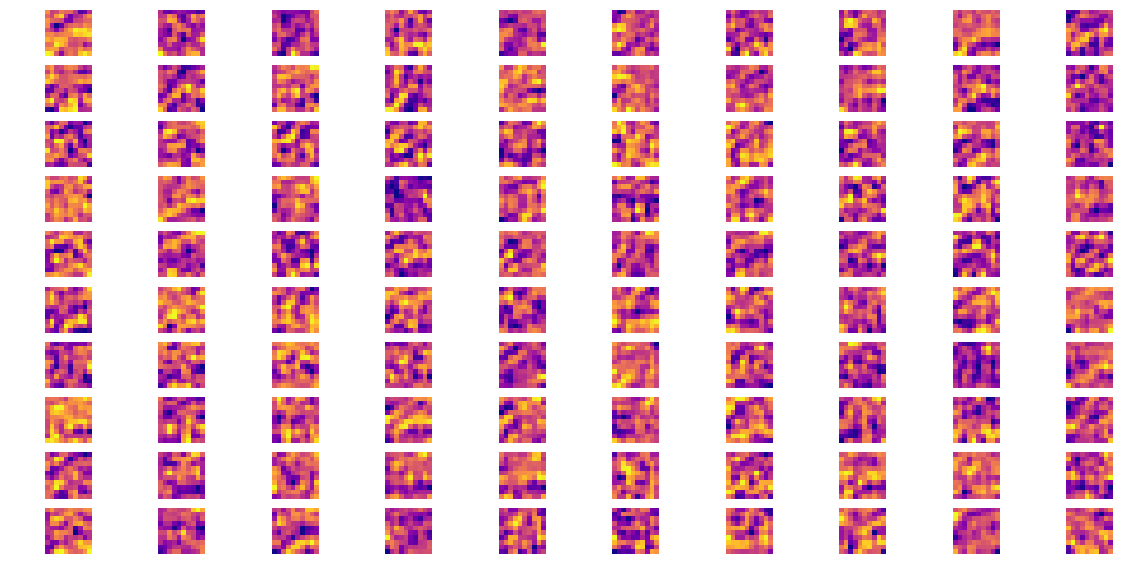

Basis functions after batch number #66


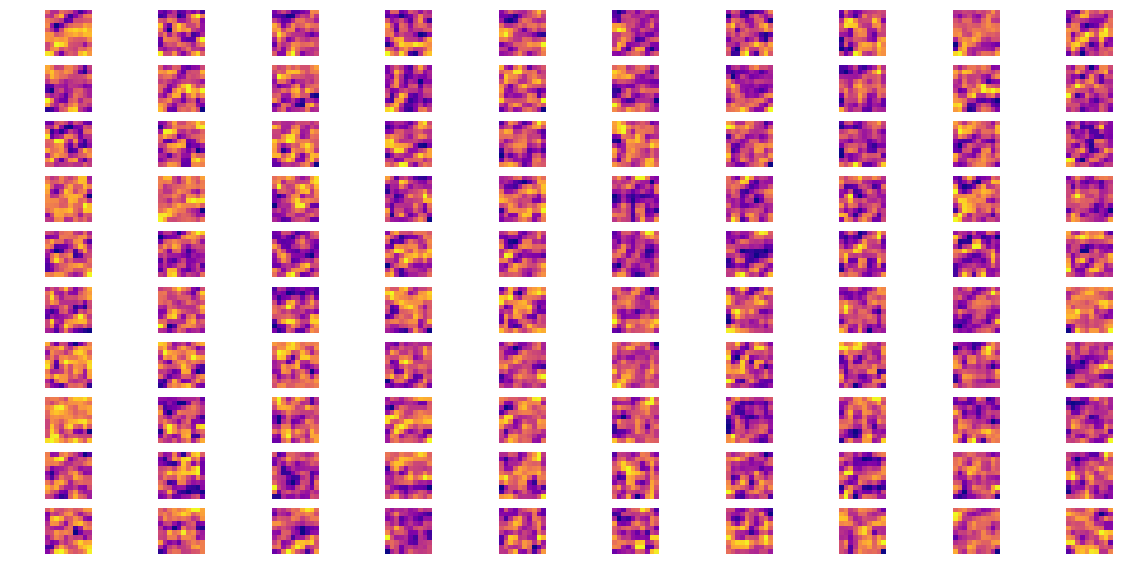

Basis functions after batch number #67


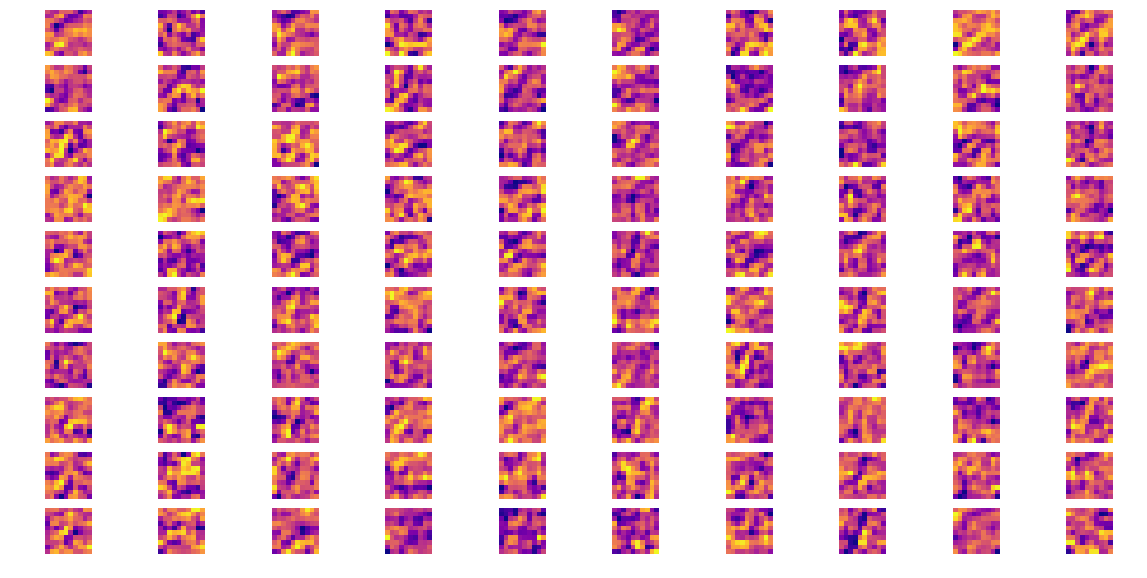

Basis functions after batch number #68


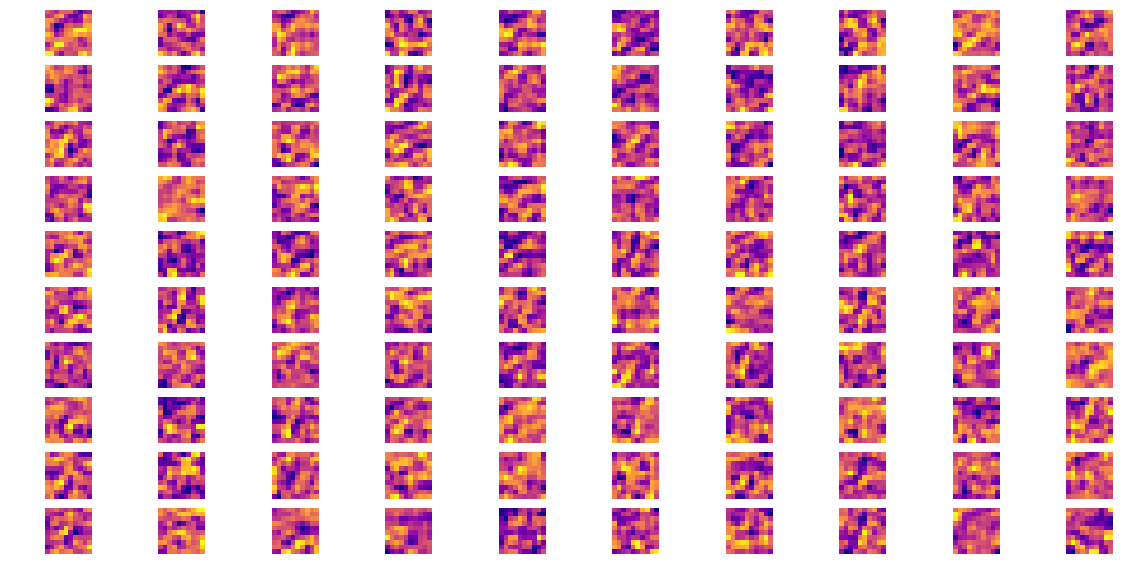

Basis functions after batch number #69


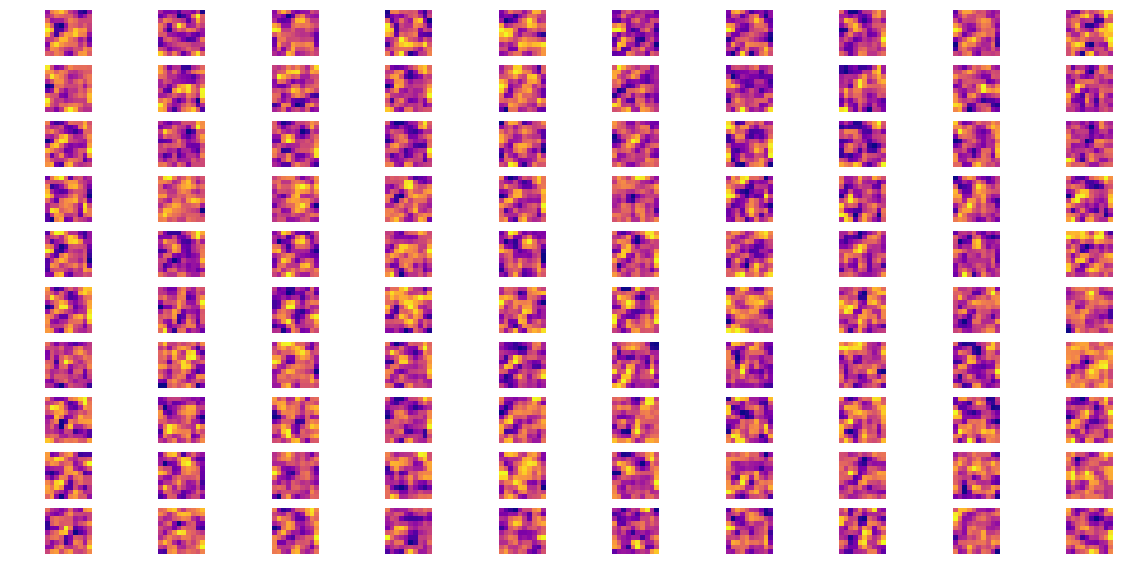

Basis functions after batch number #70


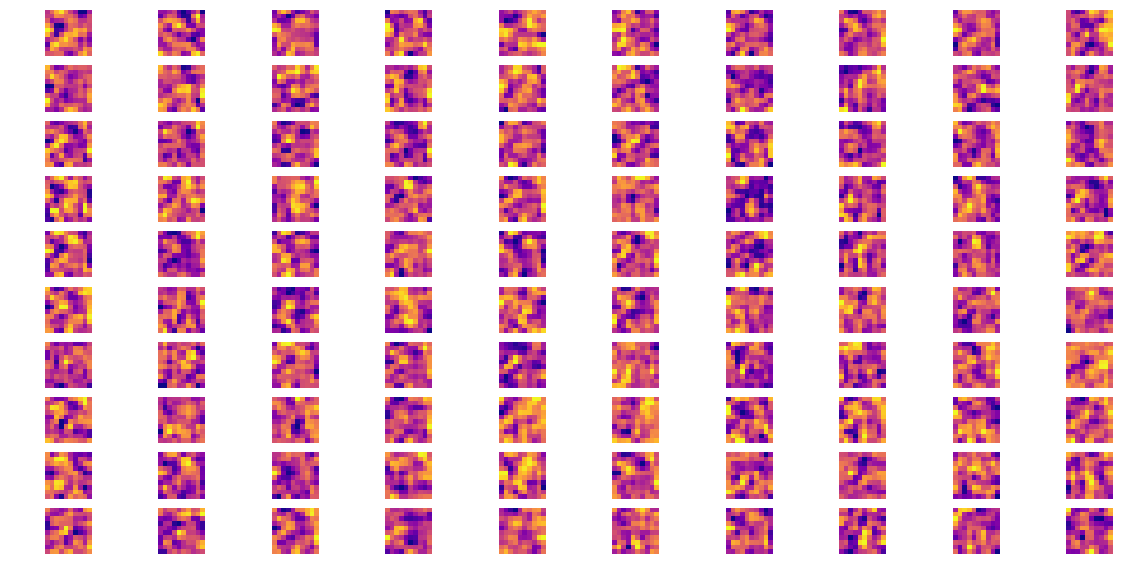

Basis functions after batch number #71


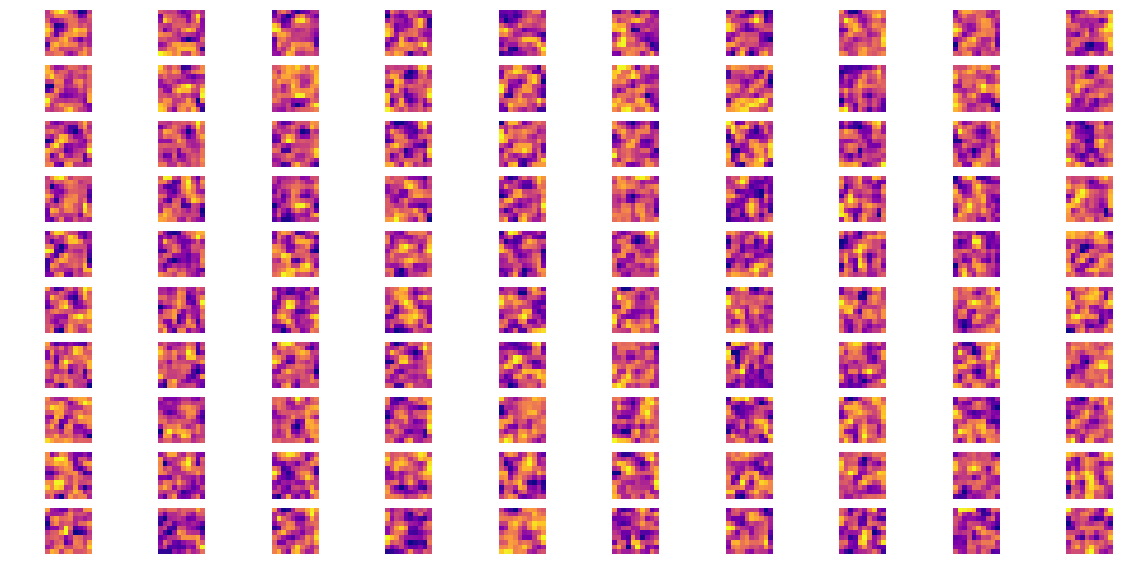

Basis functions after batch number #72


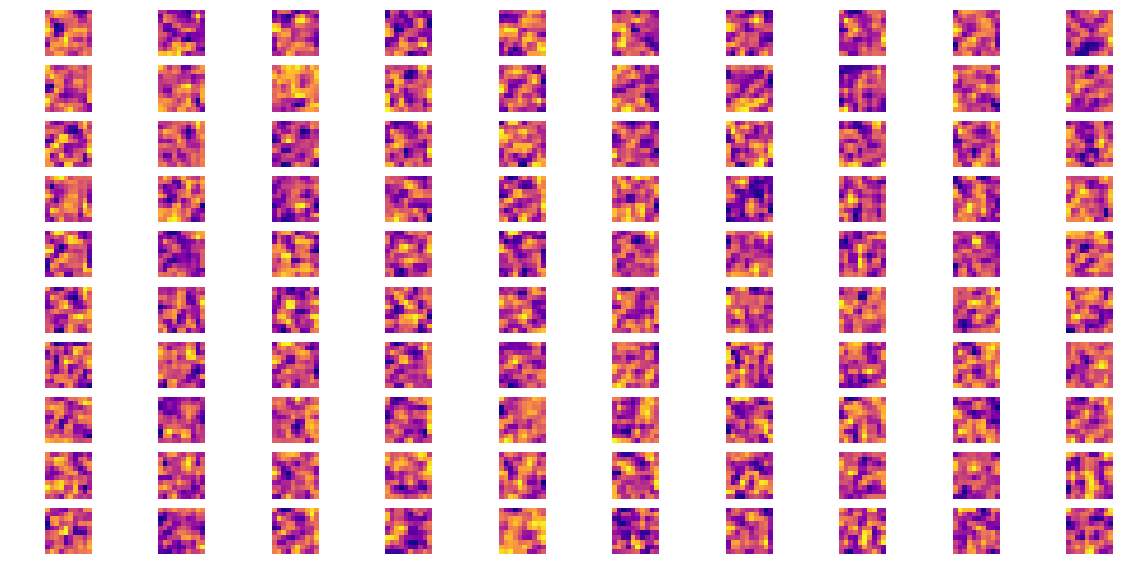

Basis functions after batch number #73


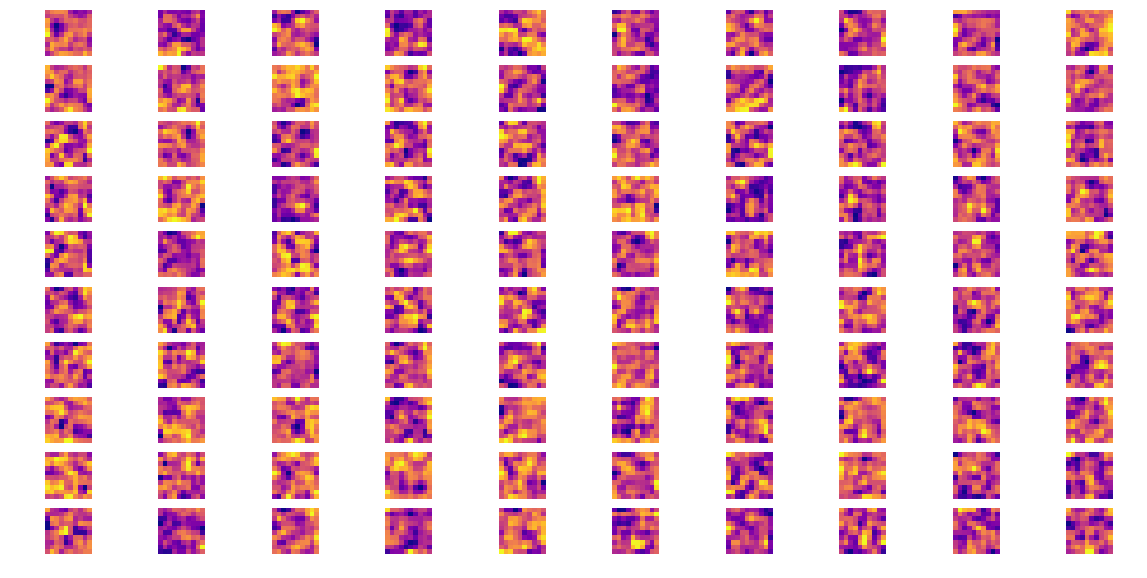

Basis functions after batch number #74


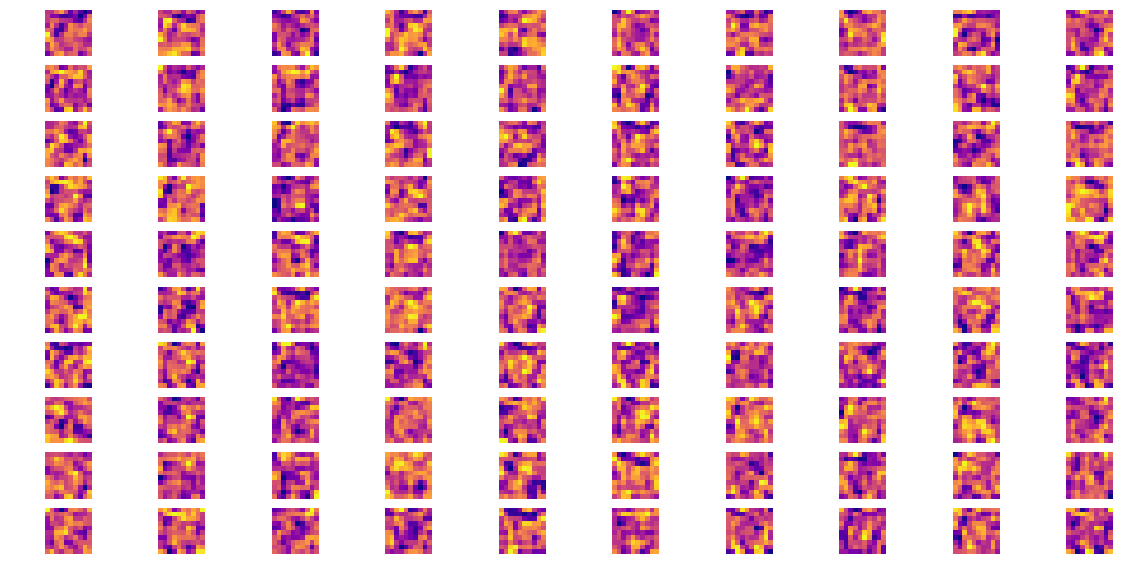

Basis functions after batch number #75


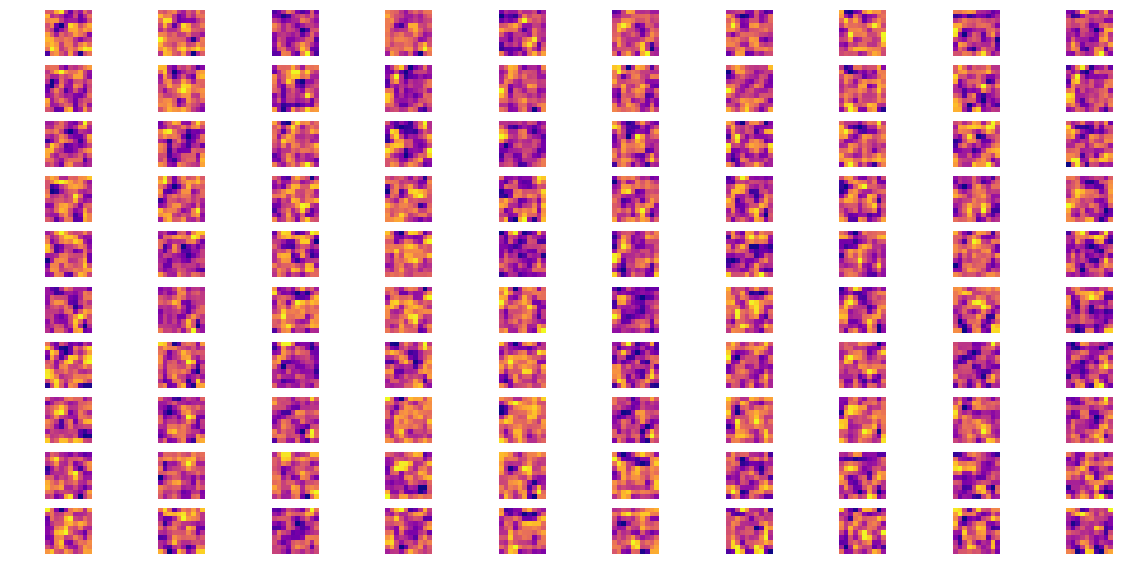

Basis functions after batch number #76


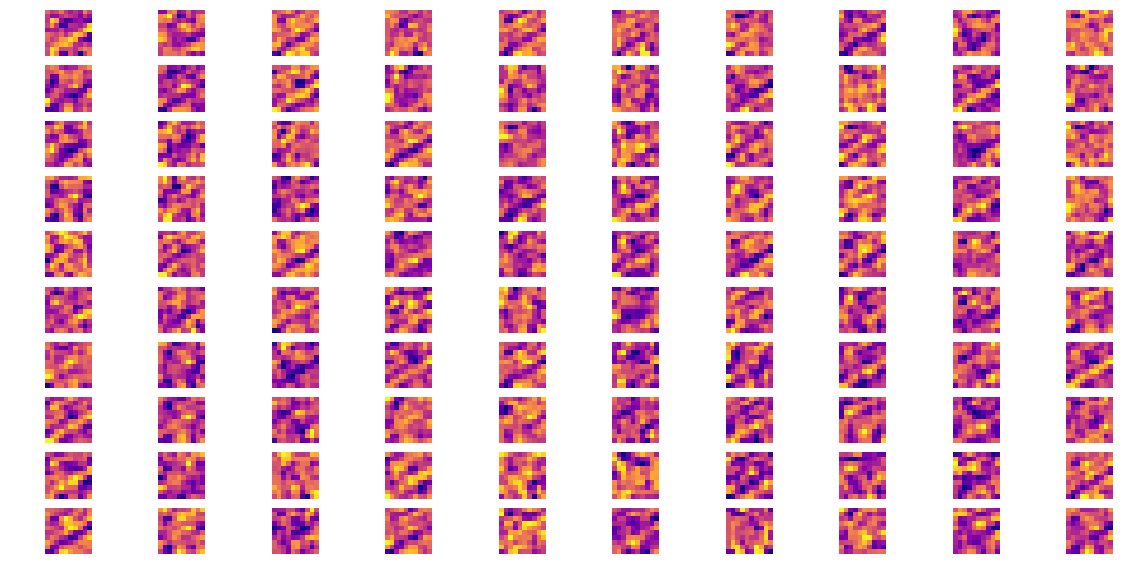

Basis functions after batch number #77


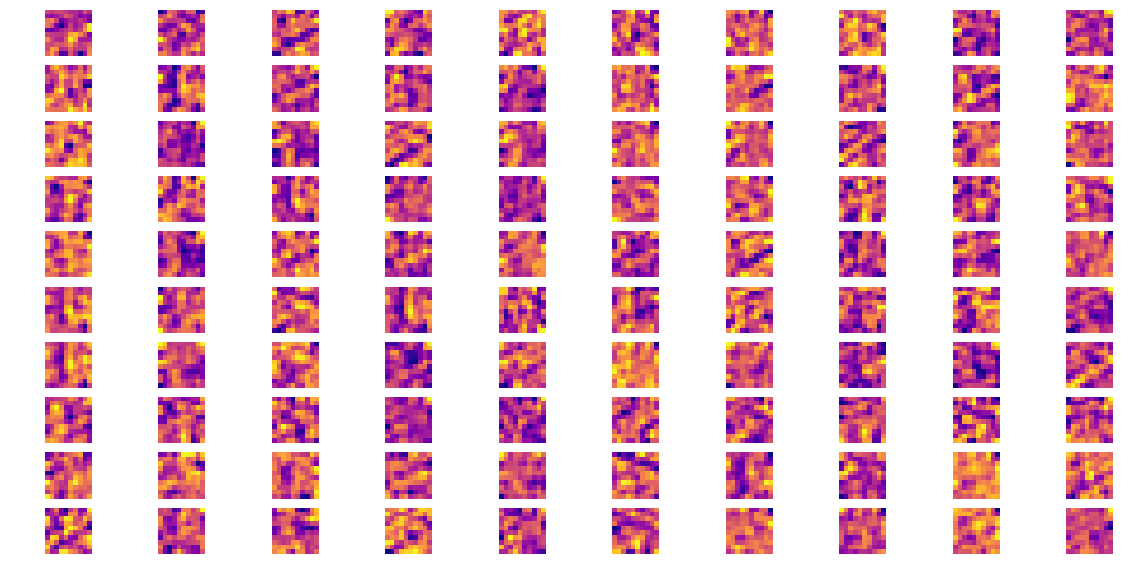

Basis functions after batch number #78


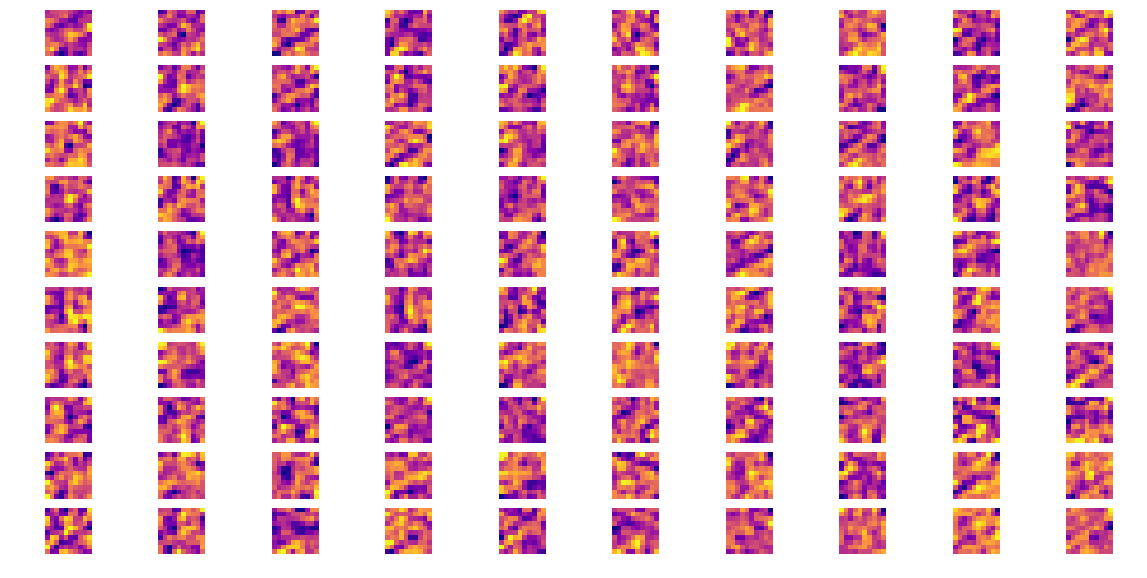

Basis functions after batch number #79


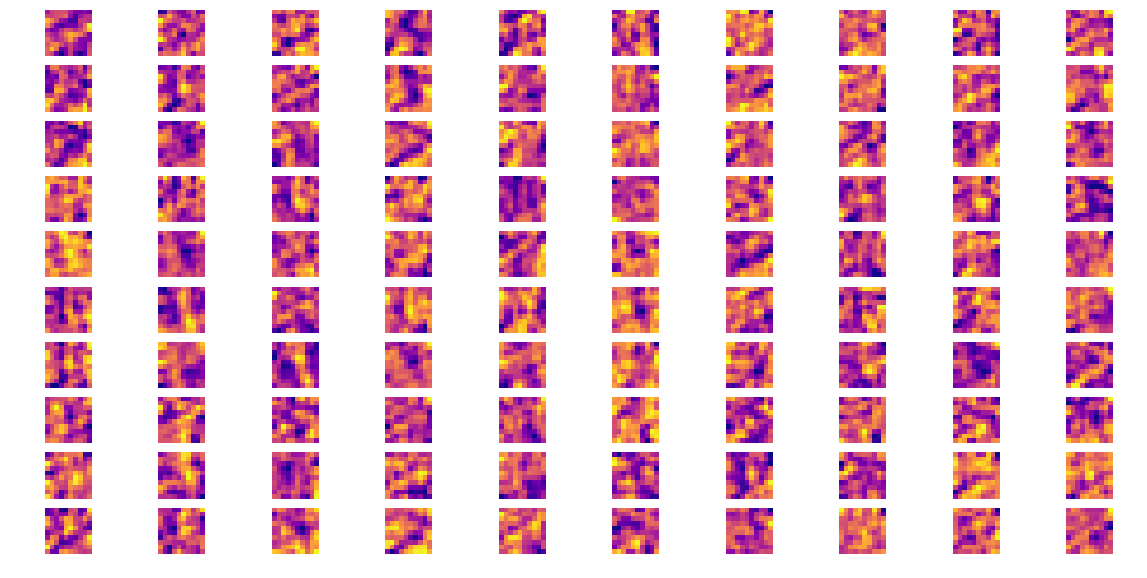

Basis functions after batch number #80


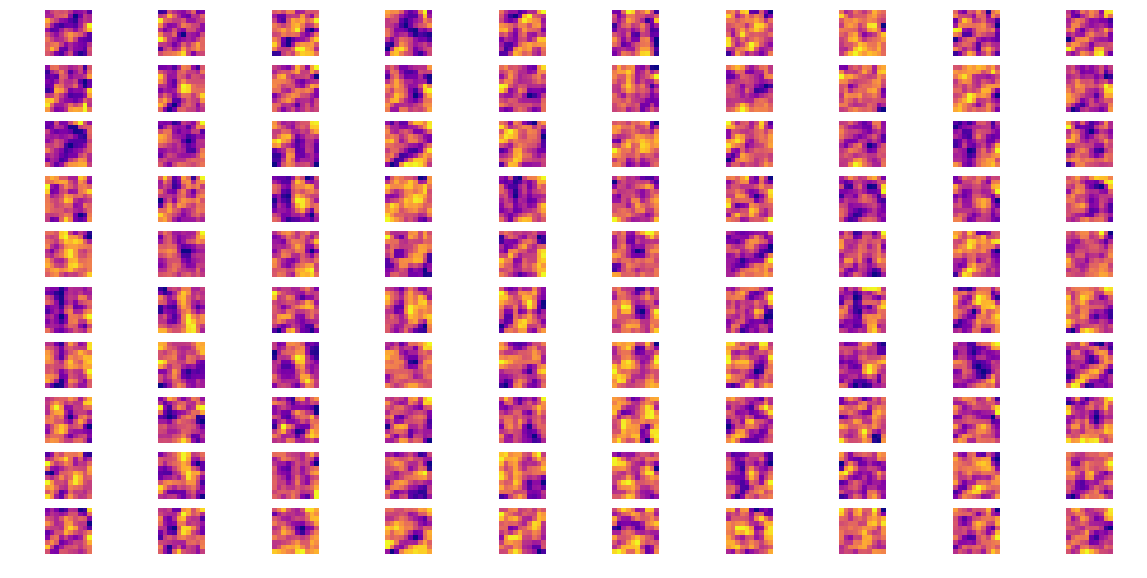

Basis functions after batch number #81


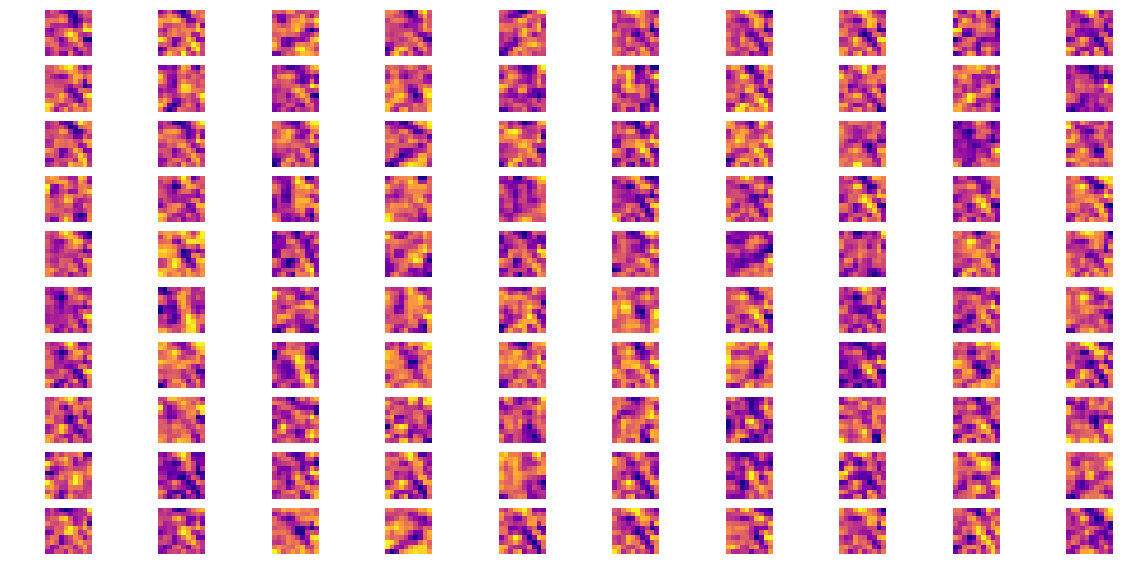

Basis functions after batch number #82


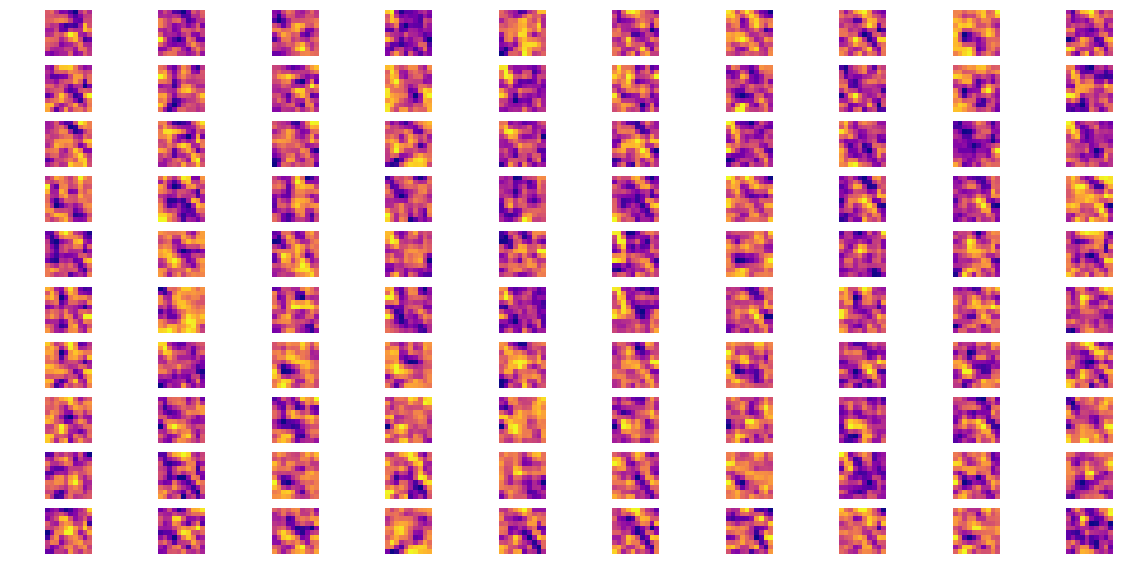

Basis functions after batch number #83


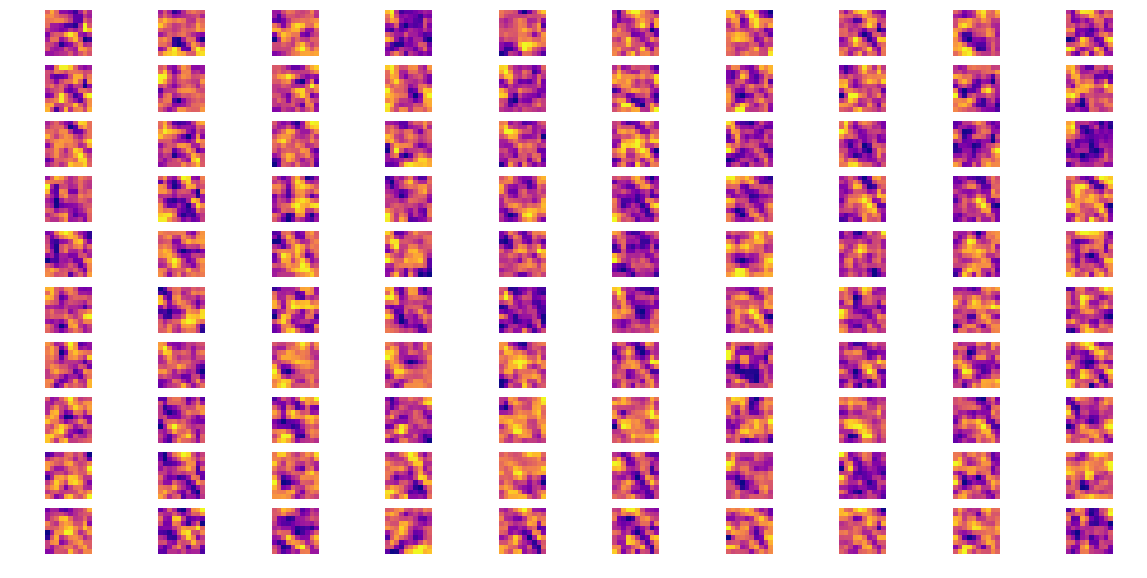

Basis functions after batch number #84


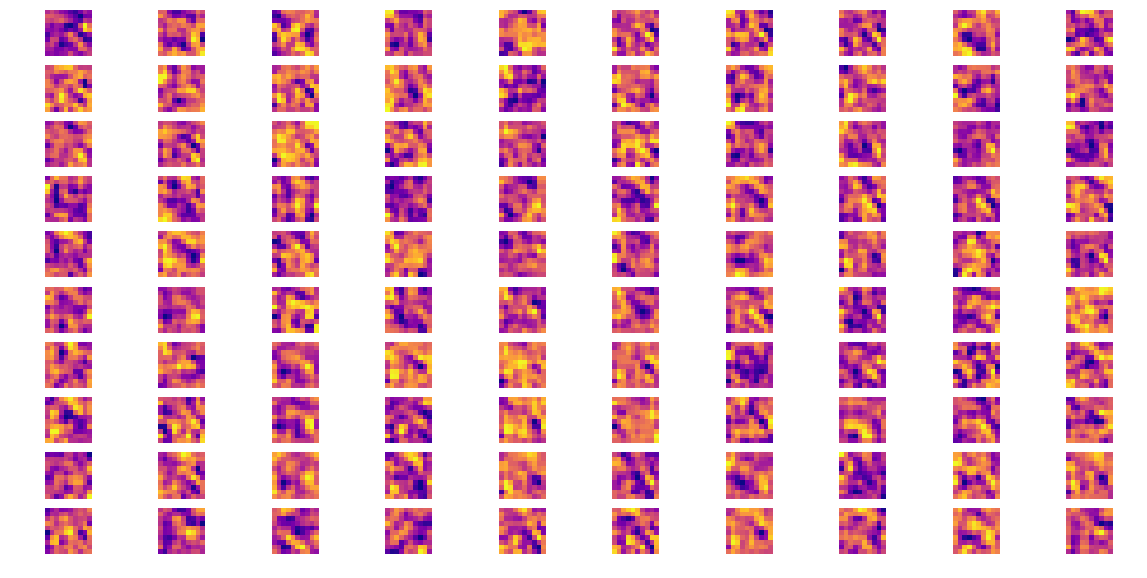

Basis functions after batch number #85


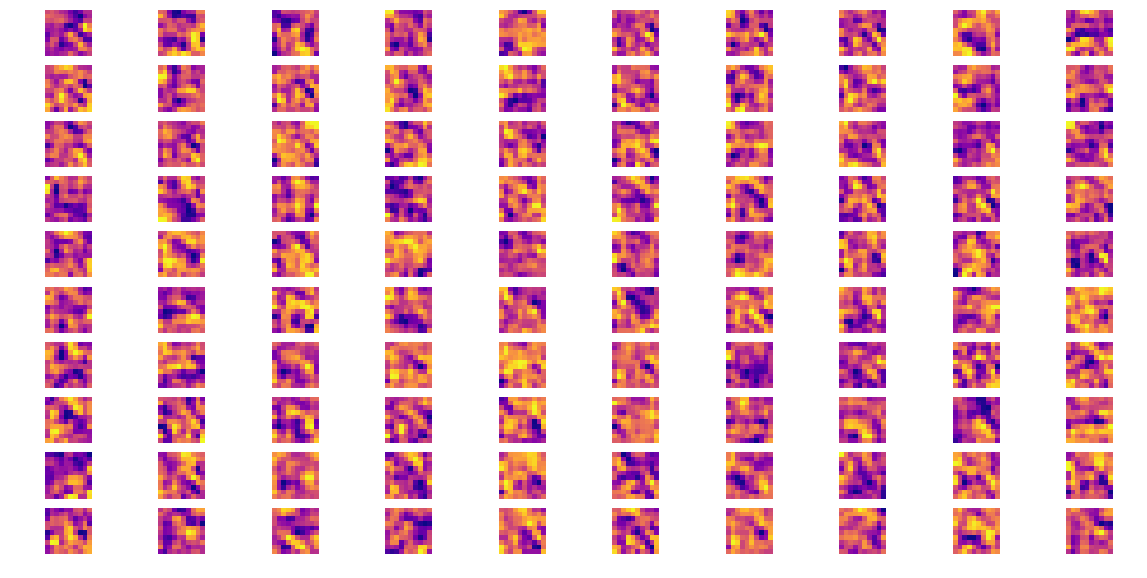

Basis functions after batch number #86


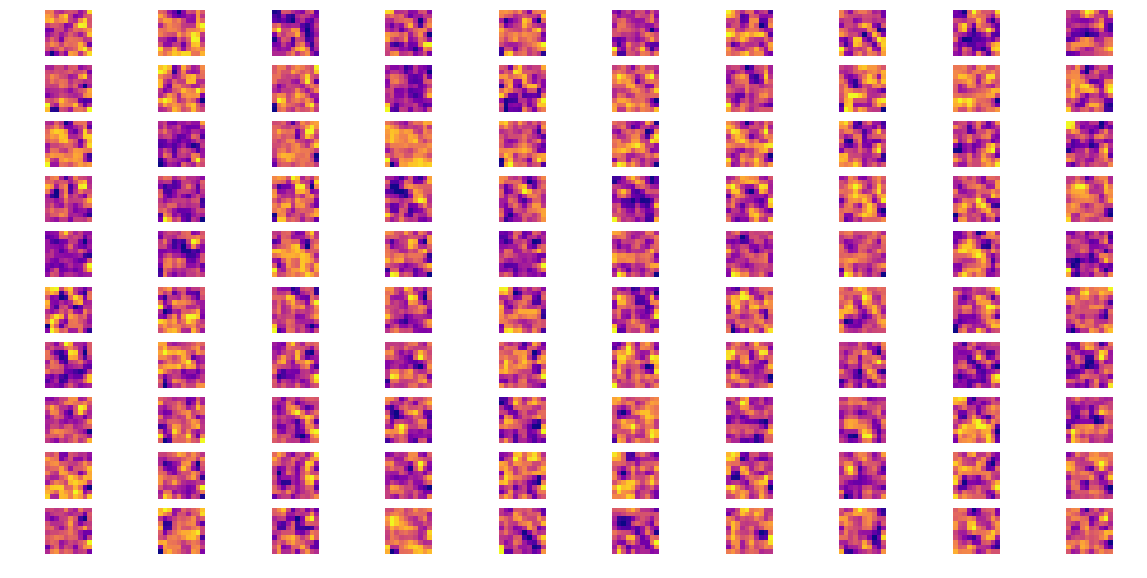

Basis functions after batch number #87


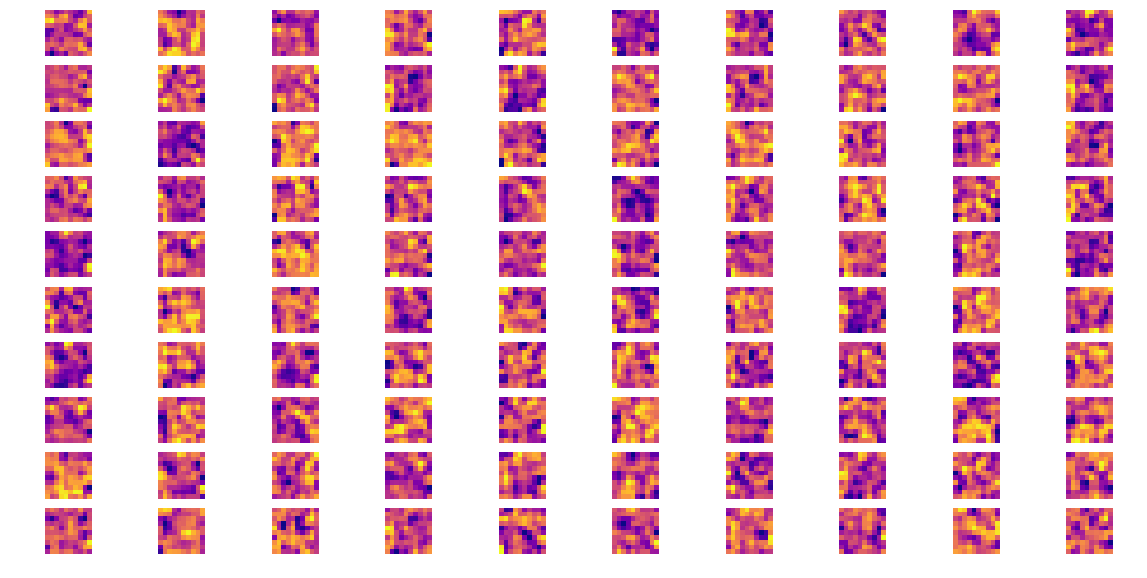

Basis functions after batch number #88


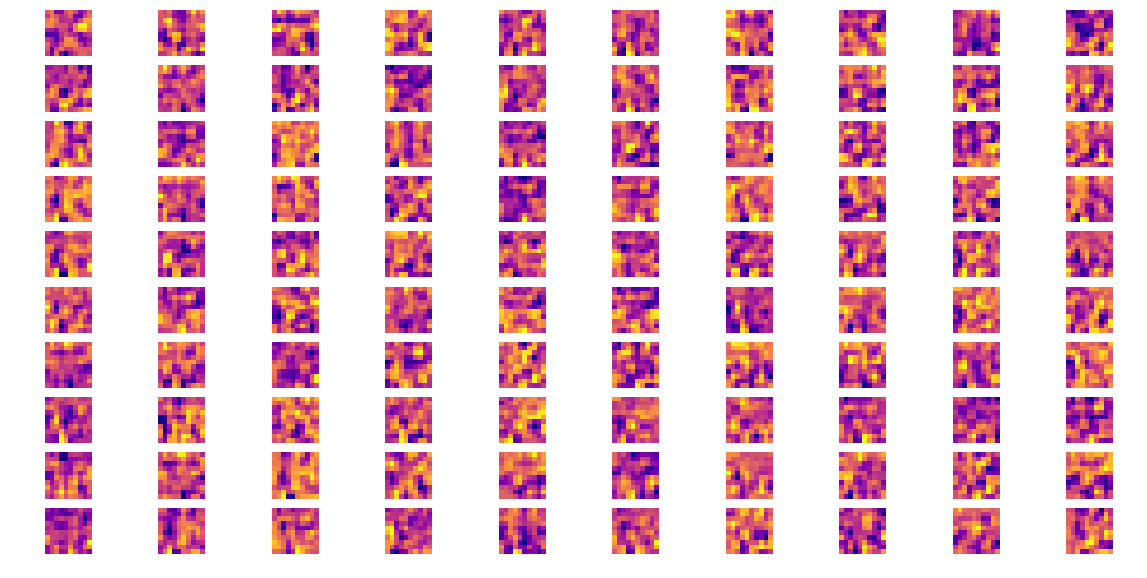

Basis functions after batch number #89


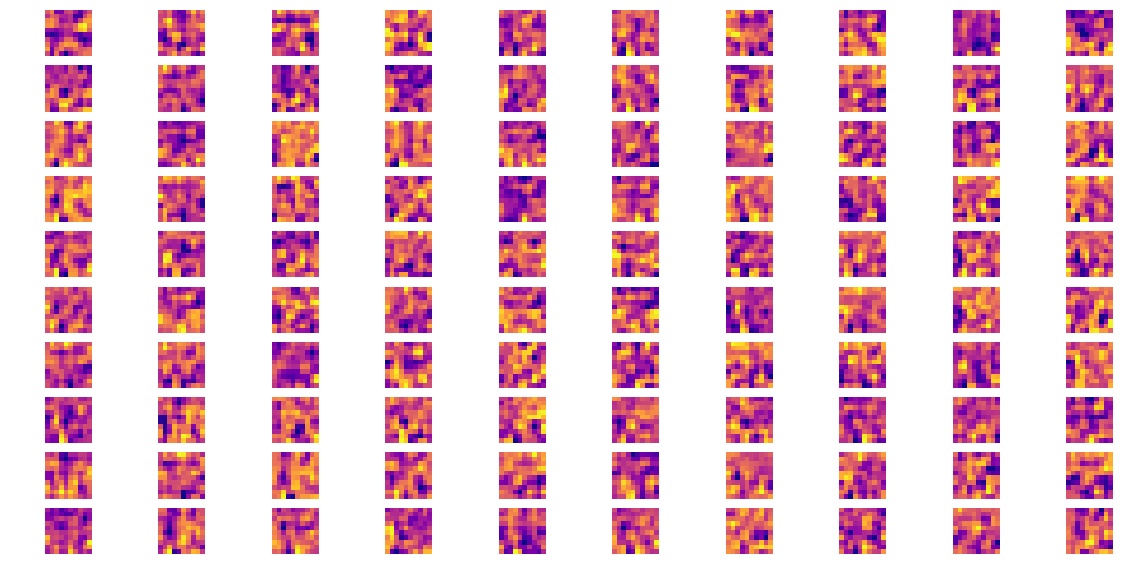

Basis functions after batch number #90


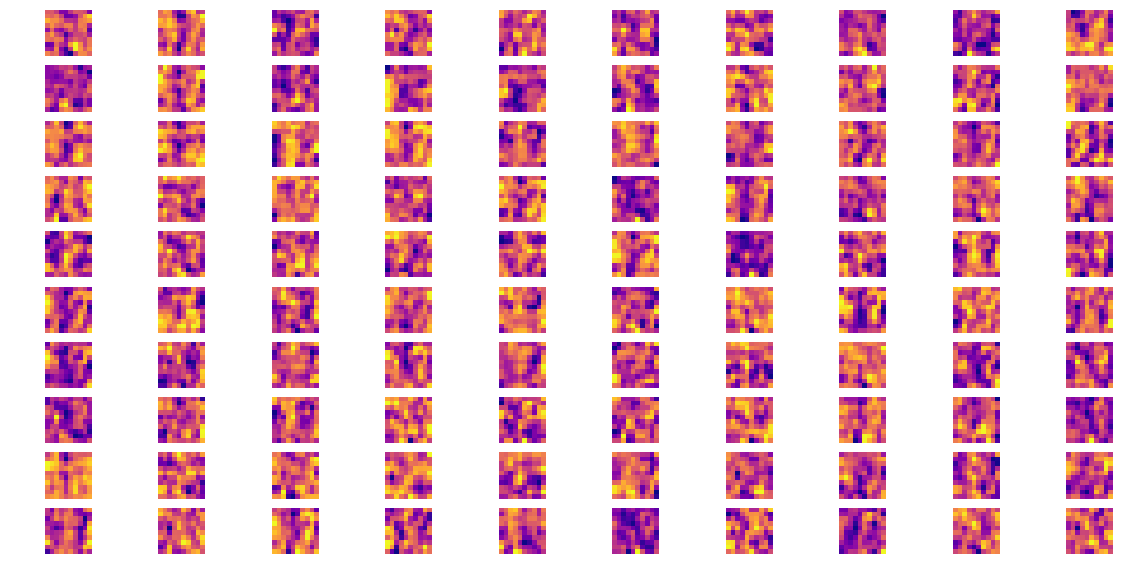

Basis functions after batch number #91


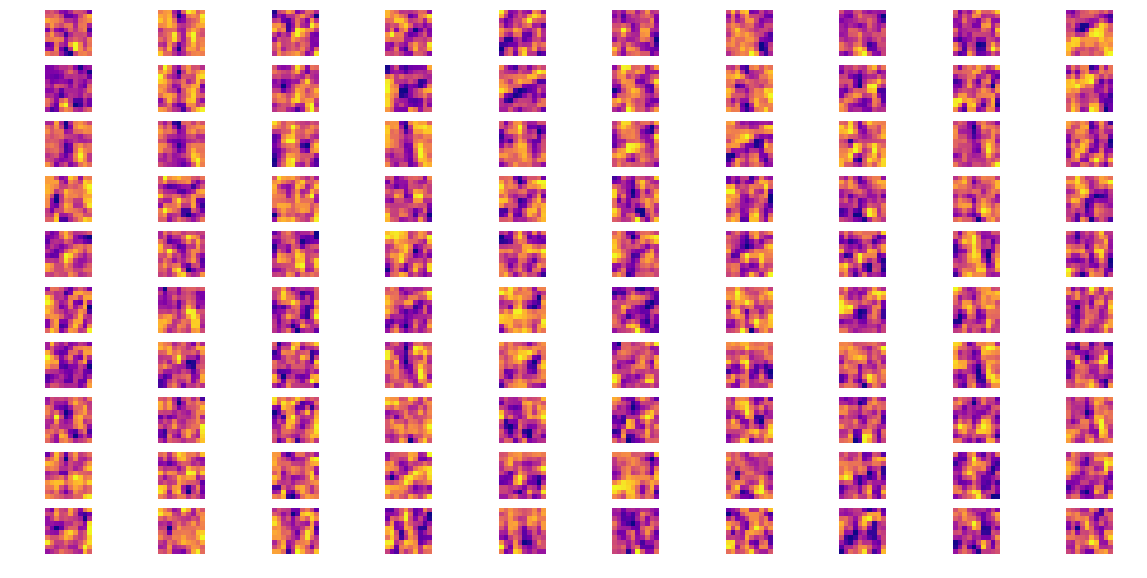

Basis functions after batch number #92


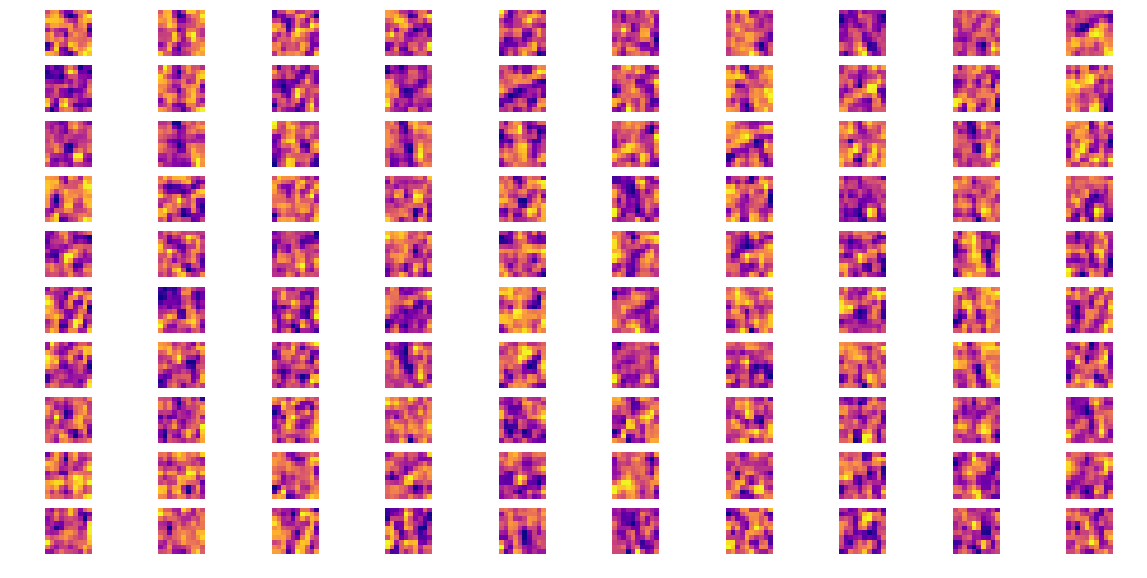

Basis functions after batch number #93


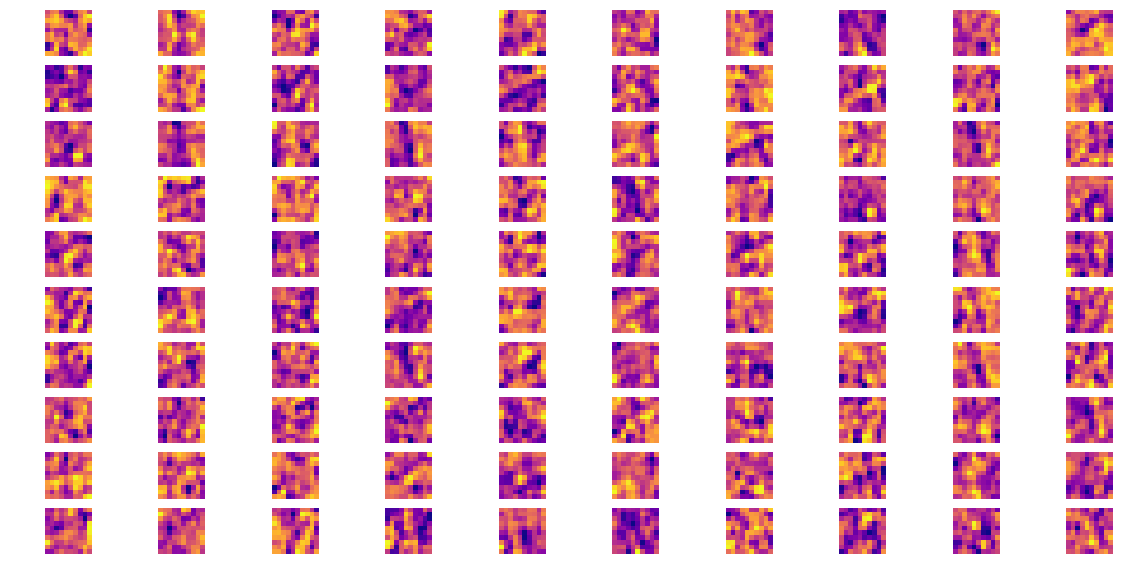

Basis functions after batch number #94


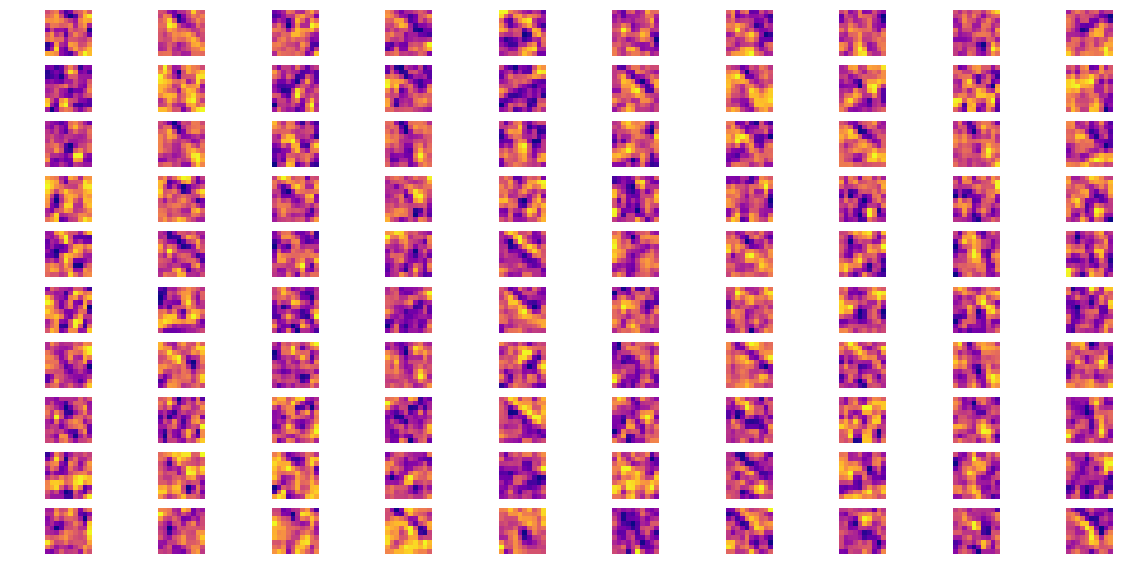

Basis functions after batch number #95


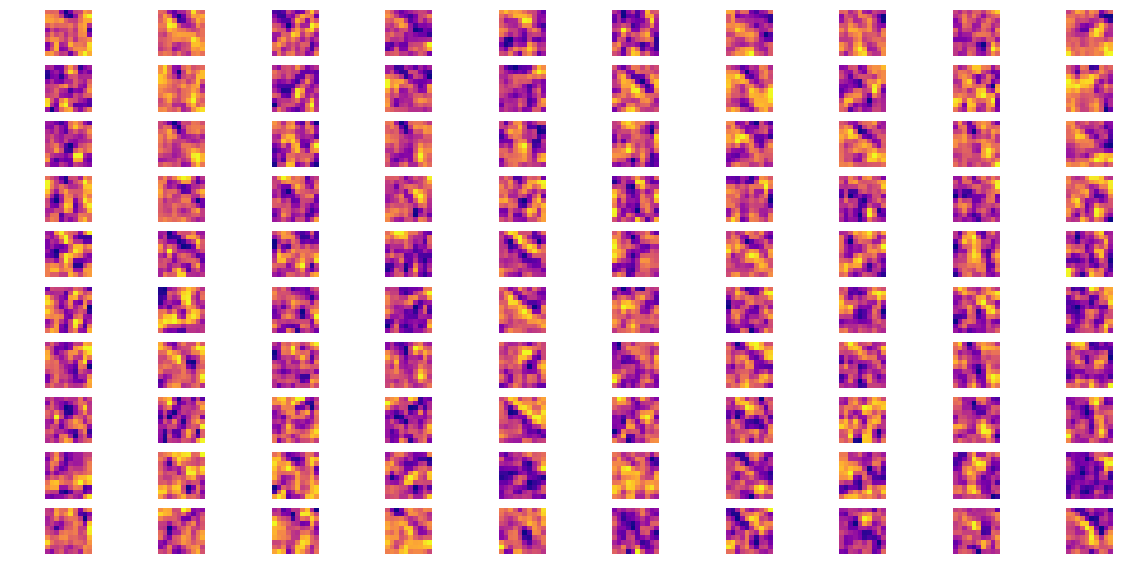

Basis functions after batch number #96


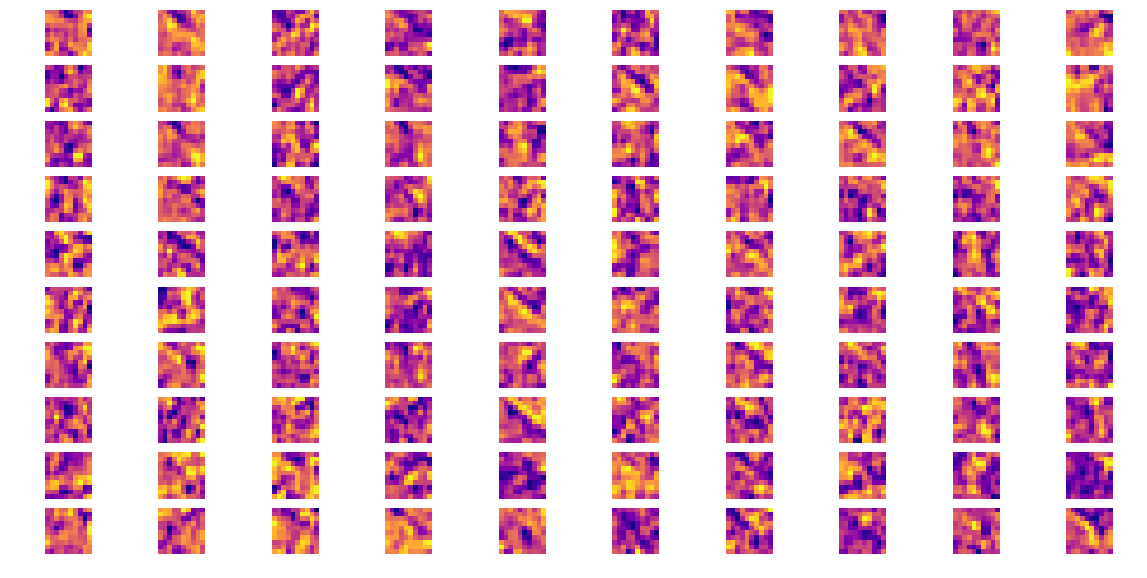

Basis functions after batch number #97


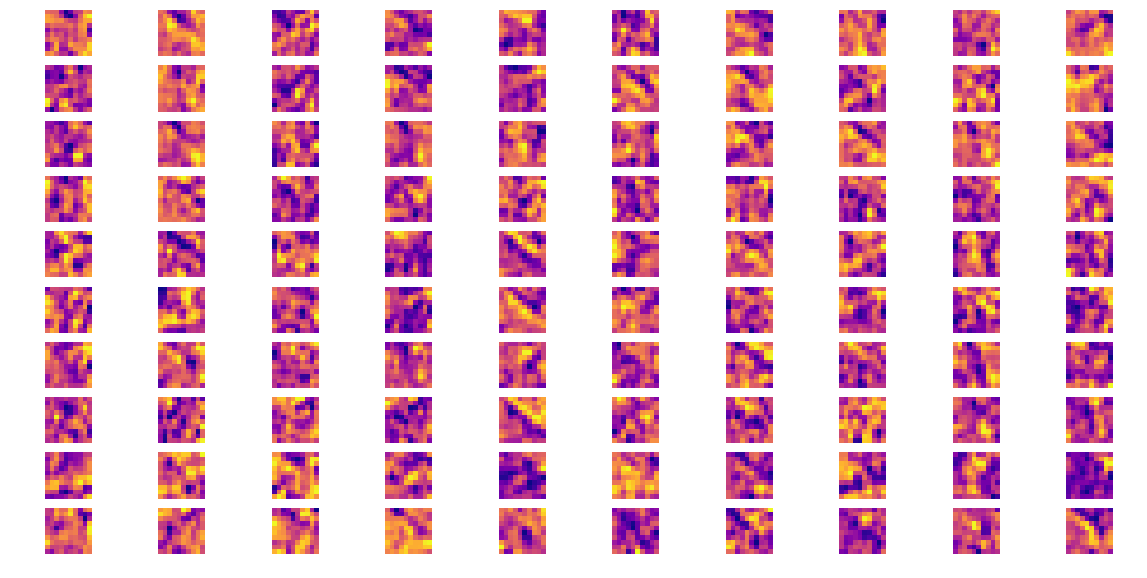

Basis functions after batch number #98


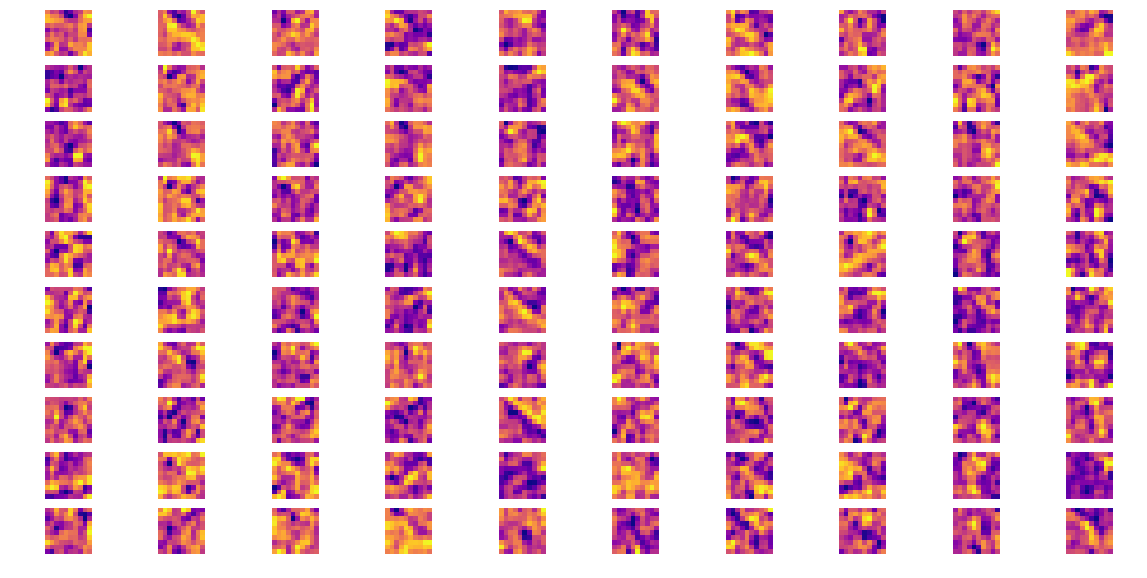

Basis functions after batch number #99


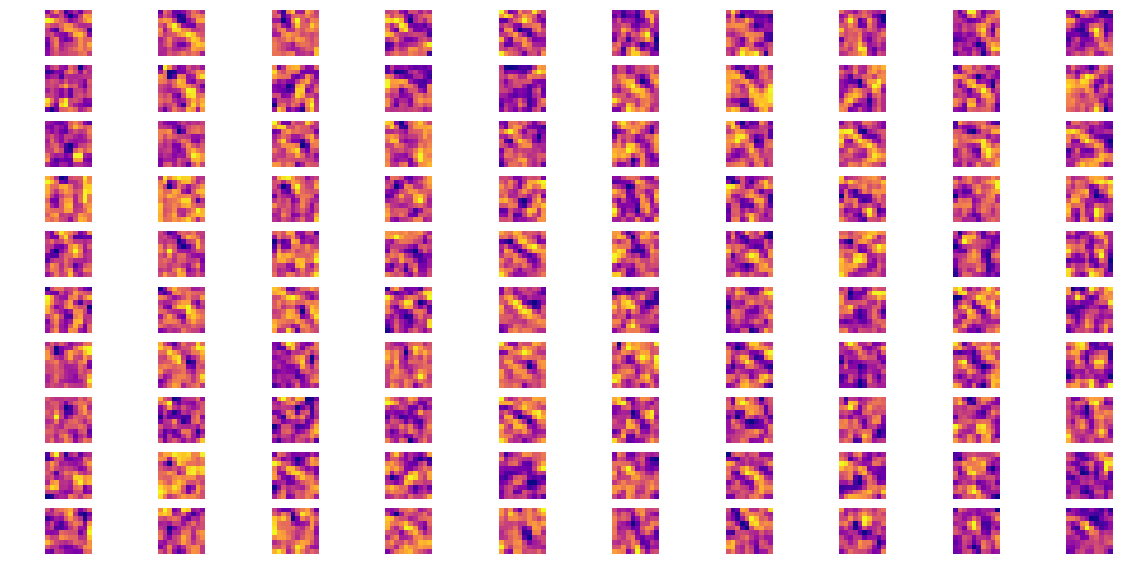

In [131]:
bases = sparse_net(bases, 100)  #sparse coding algorithm returns basis functions after 100 batches

## Plot current basis functions

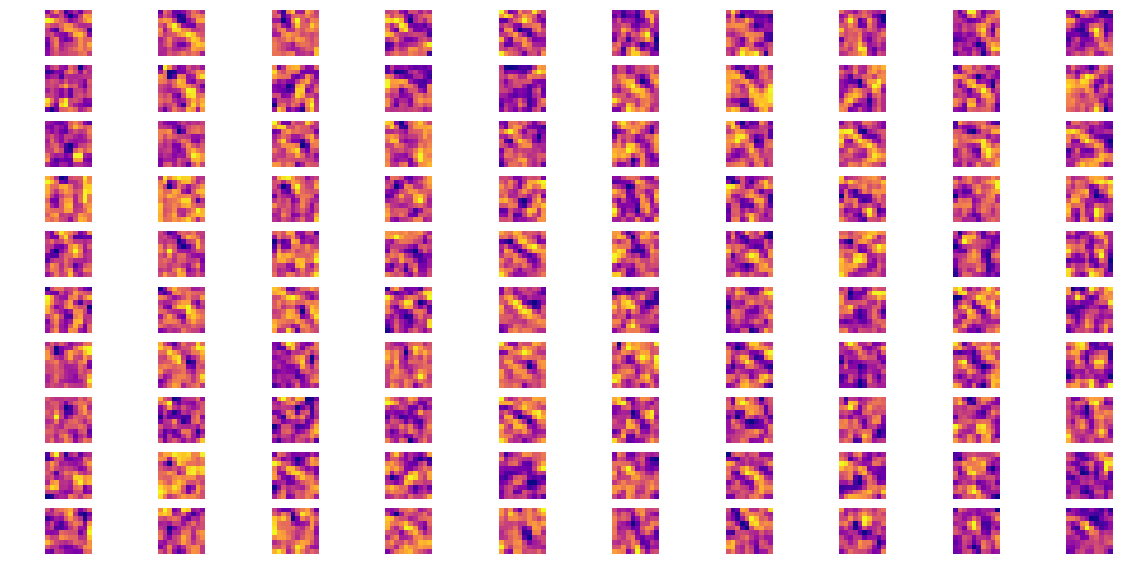

In [132]:
plot_bases(bases, 10)

## Some extra functions

In [ ]:
from scipy import ndimage
from scipy import optimize
from math import log

def S(x):
    return(log(1 + x*x))

def Sprime(x):
    return(2*x/(1 + x*x))

def get_sparseness(weights,sigma):
    sparseness = 0
    for i in range(len(weights)):
        sparseness += S(weights[i]/sigma)
    return(-sparseness)

def get_preservation(image, weights, bases):
    info = 0
    for x in range(image.shape[0]):
        model = 0
        for i in range(bases.shape[1]):
            model += weights[i]*bases[x][i]
        info += (image[x] - model)**2
    return(-info)
    
def get_energy(weights, *args):
    patch, bases, sigma, lam = args
    sparseness = get_sparseness(weights,sigma)
    preservation = get_preservation(patch,weights,bases)
    return(-preservation-lam*sparseness)

def matrix_product(A,B):
    product = 0
    for x in range(A.shape[0]):
        for y in range(A.shape[0]):
            product += A[x][y]*B[x][y]
    return(product)
            
def get_gradient(weights, *args):
    image, bases, sigma, lam = args
    grad = []
    for i in range(len(weights)):
        grad_i = 0
        grad_i -= 2*np.dot(bases[:,i], image)
        for j in range(len(weights)):
            grad_i += weights[j]*np.dot(bases[:,i], bases[:,j])
        grad_i += lam*Sprime(weights[i]/sigma)/sigma
        
        grad.append(grad_i)
    return(np.array(grad))

def minimize_energy(patch, weights, bases, sigma, lam):
    args = (patch, bases, sigma, lam)
    x0 = np.zeros(size)
    res1 = optimize.fmin_cg(get_energy, x0, fprime=get_gradient,args=args,epsilon = 1, gtol = 0.1, maxiter = 5)
    return(res1)   
    
def update_bases(bases,averages,eta):
    for i in range(bases.shape[1]):
        for x in range(bases.shape[0]):
            bases[x][i] += eta*averages[x][i]
    bases = np.dot(bases, np.diag(1/np.sqrt(np.sum(bases**2, axis = 0))))
    return(bases)
    